In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Funtion to perform camera calibration

def calibrate_camera(nx, ny, input_calib_img_path):
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Make a list of calibration images
    images = glob.glob(input_calib_img_path)
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = (gray.shape[1], gray.shape[0])
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            if(show_debug_images == True):
                write_name = './debug_dir/01_corners_found'+str(idx)+'.jpg'
                cv2.imwrite(write_name, img)

    print('Found chess board corners: ', ret)

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    return ret, mtx, dist

In [3]:
# Perform distorion correction
def correct_distortion(img, dst, mtx):
    dst = cv2.undistort(img, mtx, dst, None, mtx)
    return dst

In [25]:
# Binarization Pipeline
def binarization_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSL color space and separate H, S and L channels
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
        
    # Stack each channel   
    combined = np.zeros_like(sxbinary)    
    combined[((s_binary == 1) | (sxbinary == 1))] = 255
    
    return combined

In [5]:
# correct perspective distortion and generate bird's eye view
def correct_perspective(undist):
    # Grab the image shape
    img_size = (undist.shape[1], undist.shape[0])
    print('image size: ', img_size)
    
    offset_x = 290
    offset_y = 0
    
    # For source points:  Manually setting four points by eye balling in staight image 'project_test1.jpg'.
 
    perspective_top_left     = (578, 467)
    perspective_top_right    = (724, 467)
    perspective_bottom_right = (1175, 720)
    perspective_bottom_left  = (250, 720)

    src = np.float32([perspective_top_left, perspective_top_right, perspective_bottom_right, perspective_bottom_left])
    
    orthographic_top_left      = (offset_x               , offset_y)
    orthographic_top_right     = (img_size[0] - offset_x , offset_y) 
    orthographic_bottom_right  = (img_size[0] - offset_x , img_size[1])
    orthographic_bottom_left   = (offset_x               , img_size[1])
    
    dst = np.float32([orthographic_top_left, orthographic_top_right, orthographic_bottom_right, orthographic_bottom_left])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    MInv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    
    if(show_debug_images == True):
        # Create an image to draw the lines on
        original_draw = np.zeros_like(undist).astype(np.uint8)
        orig_color = np.dstack((undist, original_draw, original_draw))
        
        cv2.line(orig_color,perspective_bottom_left, perspective_bottom_right, (0,0,255),2)
        cv2.line(orig_color,perspective_bottom_left, perspective_top_left, (0,0,255),2)
        cv2.line(orig_color,perspective_top_left, perspective_top_right, (0,0,255),2)
        cv2.line(orig_color,perspective_bottom_right, perspective_top_right, (0,0,255),2)
   
        write_name = './debug_dir/03_warped_image'+str(0)+'.jpg'
        cv2.imwrite(write_name, orig_color)

        f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,10))
    
        ax1.imshow(cv2.cvtColor(orig_color,cv2.COLOR_BGR2RGB))
        ax1.set_title('Corr- Orig Image', fontsize=30)
    
        ax2.imshow(warped,cmap='gray')
        ax2.set_title('Corr- warped Image', fontsize=30)
    
    
    return M, MInv, warped

In [6]:
# use previous frame polynomial fit to locate lane lines in the current frame
def locate_lane_using_previous_fits(binary_warped, last_left_fit, last_right_fit):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    associated_left_x = last_left_fit[0]*(nonzeroy**2) + last_left_fit[1]*nonzeroy + last_left_fit[2]
    left_lane_inds = ((nonzerox > ( associated_left_x - margin)) & (nonzerox < (associated_left_x + margin)))
    
    associated_right_x = last_right_fit[0]*(nonzeroy**2) + last_right_fit[1]*nonzeroy + last_right_fit[2]
    right_lane_inds = ((nonzerox > ( associated_right_x - margin)) & (nonzerox < (associated_right_x + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if(show_debug_images == True):
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        write_name = './debug_dir/05_lane_pixels.jpg'
        cv2.imwrite(write_name, out_img)

    return left_fit, right_fit

In [7]:
# perform Window based search for locate lane pixels in image. Seed the search using peak of histogram
def lacate_lane_exhaustive_search(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 70

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if(show_debug_images == True):
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if(show_debug_images == True):
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        write_name = './debug_dir/05_lane_pixels.jpg'
        cv2.imwrite(write_name, out_img)
    
    return left_fit, right_fit


In [8]:
# wrapper function to finding lane pixels in the image
def locate_lane_pos(binary_warped, use_previous_line, last_left_fit, last_right_fit):
    
    # Assuming we have created a warped binary image called "binary_warped"
    
    if(use_previous_line):
        left_fit, right_fit = locate_lane_using_previous_fits(binary_warped, last_left_fit, last_right_fit)
    else:
        left_fit, right_fit = lacate_lane_exhaustive_search(binary_warped)    
    
    return left_fit, right_fit

In [9]:
# Find radius of curvature in the image in meter units
def get_curvature_mt(left_line, right_line, img_size):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    #The last point where curvature would be evaluated
    y_eval = (img_size[1]-1)*ym_per_pix
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_size[1]-1, img_size[1])
    
    leftx = left_line[0]*ploty**2 + left_line[1]*ploty + left_line[2]
    rightx = right_line[0]*ploty**2 + right_line[1]*ploty + right_line[2]
    
    leftx = leftx*xm_per_pix
    rightx = rightx*xm_per_pix
    
    ploty = ploty*ym_per_pix
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty, leftx, 2)
    right_fit_cr = np.polyfit(ploty, rightx, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad, right_curverad

In [10]:
# Draw output image for visualization
def draw_lanes_on_input(undist, left_line, right_line, MInv, left_curv, right_curv, offset, draw_lanes_on_input): 
    img_size = (undist.shape[1], undist.shape[0])
    
    color_warp = np.zeros_like(undist).astype(np.uint8)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_size[1]-1, img_size[1] )
    
    left_fitx = left_line[0]*ploty**2 + left_line[1]*ploty + left_line[2]
    right_fitx = right_line[0]*ploty**2 + right_line[1]*ploty + right_line[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the filled poly image back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, MInv, img_size) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Put Curvature and Offset info on image
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Left Radius of Curvature: {} mt'.format(int(left_curv)), (10,30), font, 1,(255,255,255),1,cv2.LINE_AA)
    cv2.putText(result,'Right Radius of Curvature: {} mt'.format(int(right_curv)), (10,70), font, 1,(255,255,255),1,cv2.LINE_AA)
    cv2.putText(result,'Offset of Car from Center: {} mt'.format(round(offset,3)), (10,110), font, 1,(255,255,255),1,cv2.LINE_AA)
    
    if(draw_lanes_on_input == True):
        cv2.circle(result,(1240,40), 10, (0,255,0), -1)
    else:
        cv2.circle(result,(1240,40), 10, (0,0,255), -1)
        
    if(show_debug_images == True):
        write_name = './debug_dir/06_poly_image.jpg'
        cv2.imwrite(write_name, color_warp)
    
    return result

In [11]:
# Show/save intermediate results for debugging/visualization

def show_save_debug_info(input_image, undist, bin_img, warped, warped_eroded, result):
    write_name = './debug_dir/00_input_image.jpg'
    cv2.imwrite(write_name, input_image)
        
    write_name = './debug_dir/01_undist_image.jpg'
    cv2.imwrite(write_name, undist)
    
    write_name = './debug_dir/02_bin_image.jpg'
    cv2.imwrite(write_name, bin_img)
    
    write_name = './debug_dir/04_warped_image.jpg'
    cv2.imwrite(write_name, warped)
    
    write_name = './debug_dir/04_warped_eroeded_image.jpg'
    cv2.imwrite(write_name, warped_eroded)
              
    write_name = './debug_dir/07_final_image.jpg'
    cv2.imwrite(write_name, result)
        
    # Visualize intermediate results
    f, ((ax1, ax2), (ax3,ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(20,10))
    ax1.imshow(cv2.cvtColor(input_image,cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)
    
    ax2.imshow(cv2.cvtColor(undist,cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted Image', fontsize=20)
    
    ax3.imshow(bin_img, cmap='gray')
    ax3.set_title('Binary image', fontsize=20)
    
    ax4.imshow(warped,cmap='gray')
    ax4.set_title('Bird Eye', fontsize=20)
    
    ax5.imshow(warped_eroded,cmap='gray')
    ax5.set_title('After Erosion', fontsize=20)
        
    ax6.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))
    ax6.set_title('Final Result', fontsize=20)

In [12]:
# Find ego vehicle location in the lane as offset from center of lane
def find_car_offset(left_line, right_line, img_size):
   
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Intercept of left and right lane polynomial at end of Field of View(FOV)
    y_eval = img_size[1]-1
    
    left_lane_intercept = left_line[0]*y_eval**2 + left_line[1]*y_eval + left_line[2]
    right_lane_intercept = right_line[0]*y_eval**2 + right_line[1]*y_eval + right_line[2]
    
    image_center = img_size[0]/2
    car_center   = (left_lane_intercept + right_lane_intercept)/2
    
    offset = (image_center - car_center) * xm_per_pix
    
    print ("offset: ", offset)
    return offset, left_lane_intercept, right_lane_intercept

In [13]:
# Check validity of lane detection measurement
def check_lane_detection_validity(curv_rad_left, curv_rad_right, left_lane_intercept, right_lane_intercept):
    is_valid_lane_detection = False
    
    # distance between two lanes should be in a range [600,800], This would depend on perspective transform. 
    # if perpective transform threshold changes this creteria also needs to change.
    
    dist_bet_lanes_pixel = (right_lane_intercept - left_lane_intercept)
    if((dist_bet_lanes_pixel < 600) or (dist_bet_lanes_pixel > 800)):
        return is_valid_lane_detection
    
    # Curvature parallelism: absolute difference between two lane curvature should be less than threshold
    abs_diff_curvature = abs(curv_rad_left - curv_rad_right)
    if(abs_diff_curvature > 1000):
        return is_valid_lane_detection
    
    # current curvature should be in a range of last few curvature measurement: To be implemented
    
    is_valid_lane_detection = True;
    
    return is_valid_lane_detection 

In [14]:
# Wrapper function for image pipeline for lane detection
def process_image(input_image):
    # Correct image distortion using Distortion coefficients and Camera matrix parameters
    undist = correct_distortion(input_image,dist_coff,cam_matrix)
    
    # Binarize image to mask out lane pixels.
    bin_img = binarization_pipeline(undist,(170,255),(20,100))
    
    # Apply perspective transformation to get bird eye view
    M, MInv, warped = correct_perspective(bin_img)
    
    # Apply morphological Erosion to remove noise (small island - area wise)   
    kernel = np.ones((5,5),np.uint8)
    warped_eroded = cv2.erode(warped,kernel,iterations = 1)
    
    # Find parameters of sencond degree polinomials related to Left and Right lane
    global use_last_lane_fit
    global last_stable_left_fit
    global last_stable_right_fit
    
    global last_n_stable_left_fits
    global last_n_stable_right_fits
    
    global last_n_curv_rad_left
    global last_n_curv_rad_right
    
    if(use_last_lane_fit == True):
        left_line, right_line = locate_lane_pos(warped_eroded, True, last_stable_left_fit, last_stable_right_fit)
    else:
        left_line, right_line = locate_lane_pos(warped_eroded, False, last_stable_left_fit, last_stable_right_fit)
    
    # Find Radius of curvature(in meters) for left and right lane
    curv_rad_left, curv_rad_right = get_curvature_mt(left_line, right_line, (undist.shape[1], undist.shape[0]))
    
    # Find Offset of Car from lane center, assumming camera is mounted at the center of car
    offset, left_lane_intercept, right_lane_intercept = find_car_offset(left_line, right_line, (undist.shape[1], undist.shape[0]))
    
    is_valid_lane_detection = check_lane_detection_validity(curv_rad_left, curv_rad_right, left_lane_intercept, right_lane_intercept) 
    
    if(is_valid_lane_detection):
        use_last_lane_fit = True
        
        last_stable_left_fit = left_line
        last_stable_right_fit = right_line
        
        last_n_stable_left_fits.append(left_line)
        last_n_stable_right_fits.append(right_line)
        
        last_n_curv_rad_left.append(curv_rad_left)
        last_n_curv_rad_right.append(curv_rad_right)
    
    if(len(last_n_stable_left_fits)>=5):
        best_left_fit_to_draw = np.mean(last_n_stable_left_fits[-5:], axis=0)
        best_right_fit_to_draw = np.mean(last_n_stable_right_fits[-5:], axis=0)
        
        best_cur_rad_left_to_draw = np.mean(last_n_curv_rad_left[-5:], axis=0)
        best_cur_rad_right_to_draw = np.mean(last_n_curv_rad_right[-5:], axis=0)
    else:
        best_left_fit_to_draw = left_line
        best_right_fit_to_draw = right_line
        
        best_cur_rad_left_to_draw = curv_rad_left
        best_cur_rad_right_to_draw = curv_rad_right
        
    # Prepare result image for visualization - Lanes pixels overlayed on input image
    result = draw_lanes_on_input(undist, best_left_fit_to_draw, best_right_fit_to_draw, MInv, best_cur_rad_left_to_draw, best_cur_rad_right_to_draw, offset, is_valid_lane_detection)
       
    if(show_debug_images == True): 
        show_save_debug_info(input_image, undist, bin_img, warped, warped_eroded, result)    
    return result

In [17]:
# 1. Calibrate the camera using pre stored images of calibration pattern, ~20 images should be good.

nx = 9 # number of inner chess board corners in x direction
ny = 6 # number of inner chess board corners in y direction

re_proj_err, cam_matrix, dist_coff = calibrate_camera(nx, ny, 'camera_cal/calibration*.jpg')
print('Reprojection Error after calibration: ', re_proj_err)

Found chess board corners:  True
Reprojection Error after calibration:  1.1696553264915341


True

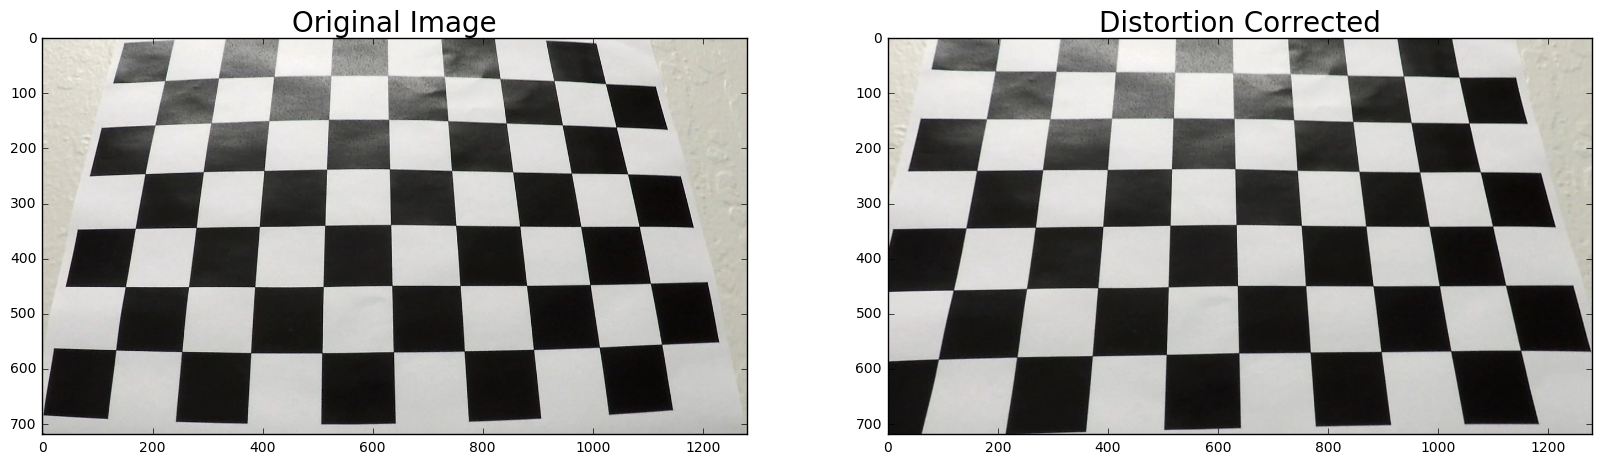

In [18]:
# Test Camera Calibration
img = cv2.imread('camera_cal/test_img_calib1.jpg')
undist = correct_distortion(img,dist_coff,cam_matrix)

# Visualize intermediate results
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(cv2.cvtColor(undist,cv2.COLOR_BGR2RGB))
ax2.set_title('Distortion Corrected', fontsize=20)

write_name = './debug_dir/01_Input_Chess_Image.jpg'
cv2.imwrite(write_name, img)

write_name = './debug_dir/02_Dist_Corrected_Image.jpg'
cv2.imwrite(write_name, undist)

image size:  (1280, 720)
1285.9731593 m 6341.07125635 m
offset:  0.00707380728895


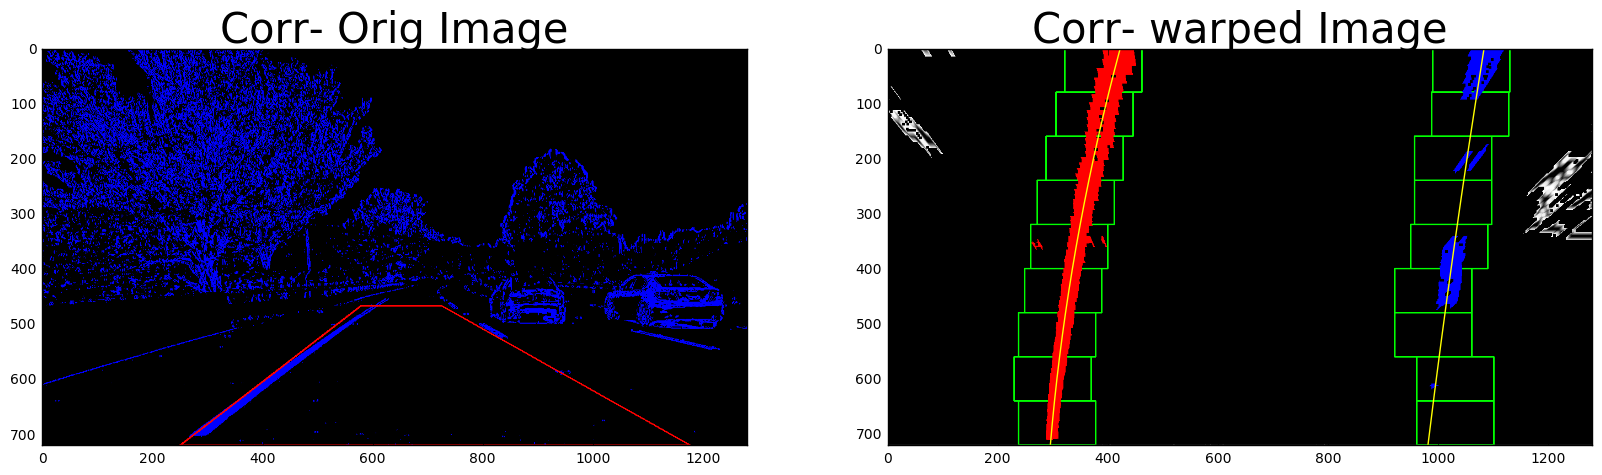

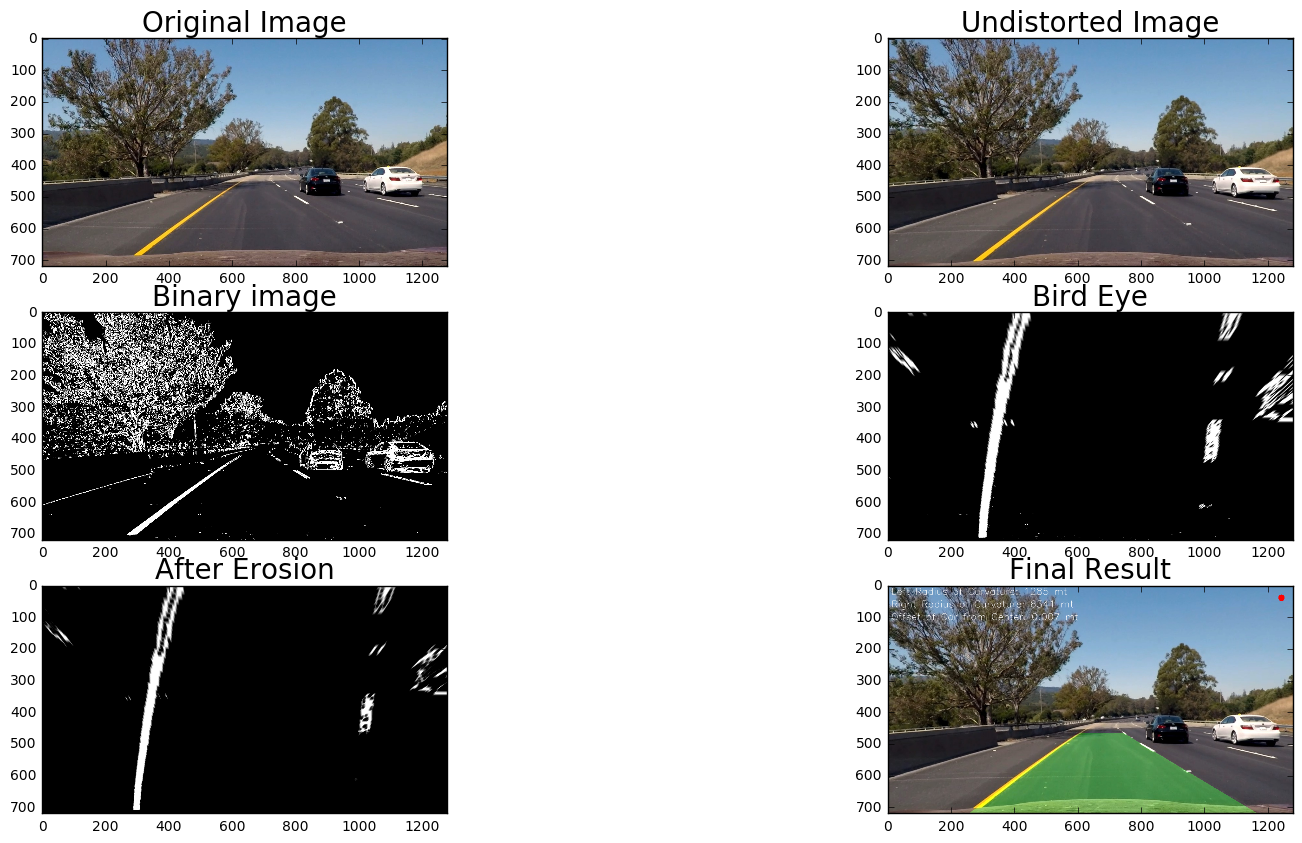

In [24]:
# Test run pipeline on image
show_debug_images = True
use_last_lane_fit = False

last_stable_left_fit = []
last_stable_right_fit = []

last_n_stable_left_fits = []
last_n_stable_right_fits = []

last_n_curv_rad_left = []
last_n_curv_rad_right = []

input_img = cv2.imread('test_images/test6.jpg')
result = process_image(input_img)

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
# Test run on videos

video_output = 'project_video_out.mp4'
video_input  = VideoFileClip('project_video.mp4')
video_clip = video_input.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

image size:  (1280, 720)
1055.59307726 m 1215.88457523 m
offset:  -0.189099781293
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


  0%|                                                 | 0/1261 [00:00<?, ?it/s]

image size:  (1280, 720)
1103.54401395 m 1215.88457523 m
offset:  -0.188868541061


  0%|                                         | 1/1261 [00:00<03:49,  5.49it/s]

image size:  (1280, 720)
919.927652927 m 1508.00662422 m
offset:  -0.16221533072


  0%|                                         | 2/1261 [00:00<04:00,  5.24it/s]

image size:  (1280, 720)
921.903599284 m 1295.00691169 m
offset:  -0.105022783252


  0%|                                         | 3/1261 [00:00<03:57,  5.30it/s]

image size:  (1280, 720)
850.347512947 m 994.358609824 m
offset:  -0.104714315281


  0%|▏                                        | 4/1261 [00:00<03:54,  5.36it/s]

image size:  (1280, 720)
870.703030996 m 1387.19330523 m
offset:  -0.116566497948


  0%|▏                                        | 5/1261 [00:00<03:49,  5.47it/s]

image size:  (1280, 720)
897.016417663 m 960.206347059 m
offset:  -0.114123318515


  0%|▏                                        | 6/1261 [00:01<03:47,  5.52it/s]

image size:  (1280, 720)
957.850428116 m 690.833964214 m
offset:  -0.111118209835


  1%|▏                                        | 7/1261 [00:01<03:53,  5.38it/s]

image size:  (1280, 720)
1045.05288836 m 506.089810548 m
offset:  -0.0518094078103


  1%|▎                                        | 8/1261 [00:01<03:58,  5.24it/s]

image size:  (1280, 720)
933.283120913 m 722.657411101 m
offset:  -0.0992421275


  1%|▎                                        | 9/1261 [00:01<04:03,  5.15it/s]

image size:  (1280, 720)
969.77337563 m 2524.90808365 m
offset:  -0.181700313728


  1%|▎                                       | 10/1261 [00:01<04:06,  5.08it/s]

image size:  (1280, 720)
903.324428123 m 12103.3916376 m
offset:  -0.201518348932


  1%|▎                                       | 11/1261 [00:02<04:10,  4.99it/s]

image size:  (1280, 720)
943.067935485 m 5316.57390298 m
offset:  -0.196121706638


  1%|▍                                       | 12/1261 [00:02<04:13,  4.93it/s]

image size:  (1280, 720)
959.913862091 m 1046.74783297 m
offset:  -0.223533498157


  1%|▍                                       | 13/1261 [00:02<04:17,  4.84it/s]

image size:  (1280, 720)
1020.6526973 m 965.874335596 m
offset:  -0.205603100141


  1%|▍                                       | 14/1261 [00:02<04:22,  4.75it/s]

image size:  (1280, 720)
1077.68678077 m 3123.73903508 m
offset:  -0.140574478193


  1%|▍                                       | 15/1261 [00:02<04:20,  4.79it/s]

image size:  (1280, 720)
1195.37759392 m 2420.22942437 m
offset:  -0.130352412835


  1%|▌                                       | 16/1261 [00:03<04:17,  4.84it/s]

image size:  (1280, 720)
1452.94478954 m 4348.7517825 m
offset:  -0.128345129322


  1%|▌                                       | 17/1261 [00:03<04:16,  4.85it/s]

image size:  (1280, 720)
1496.35864802 m 4863.88987511 m
offset:  -0.120693344486


  1%|▌                                       | 18/1261 [00:03<04:06,  5.04it/s]

image size:  (1280, 720)
1683.09559865 m 1081.05094835 m
offset:  -0.101677403529


  2%|▌                                       | 19/1261 [00:03<04:00,  5.16it/s]

image size:  (1280, 720)
2738.21757881 m 654.547584481 m
offset:  -0.058022714368


  2%|▋                                       | 20/1261 [00:03<03:59,  5.19it/s]

image size:  (1280, 720)
3654.23493368 m 350.091128812 m
offset:  0.0746874583462


  2%|▋                                       | 21/1261 [00:04<04:09,  4.96it/s]

image size:  (1280, 720)
4056.31890561 m 452.042927559 m
offset:  0.0181155718843


  2%|▋                                       | 22/1261 [00:04<04:27,  4.64it/s]

image size:  (1280, 720)
4739.36278409 m 741.726902793 m
offset:  -0.0495275387476


  2%|▋                                       | 23/1261 [00:04<04:49,  4.28it/s]

image size:  (1280, 720)
2374.06184259 m 1503.736558 m
offset:  -0.0887162477894


  2%|▊                                       | 24/1261 [00:04<04:24,  4.68it/s]

image size:  (1280, 720)
1742.15287825 m 3424.42155179 m
offset:  -0.0982776594514


  2%|▊                                       | 25/1261 [00:05<04:03,  5.08it/s]

image size:  (1280, 720)
1751.72787088 m 1879.75977898 m
offset:  -0.138975396295


  2%|▊                                       | 26/1261 [00:05<03:49,  5.38it/s]

image size:  (1280, 720)
1654.88640391 m 1898.09680275 m
offset:  -0.12147485064


  2%|▊                                       | 27/1261 [00:05<03:37,  5.67it/s]

image size:  (1280, 720)
1583.05131629 m 1483.27348832 m
offset:  -0.106725900032


  2%|▉                                       | 28/1261 [00:05<03:32,  5.81it/s]

image size:  (1280, 720)
1477.01848171 m 1412.33101914 m
offset:  -0.0577387940265


  2%|▉                                       | 29/1261 [00:05<03:27,  5.93it/s]

image size:  (1280, 720)
1283.99212959 m 1266.48825452 m
offset:  -0.0531230542013


  2%|▉                                       | 30/1261 [00:05<03:22,  6.09it/s]

image size:  (1280, 720)
1209.67570166 m 1910.10556711 m
offset:  -0.0551650558831


  2%|▉                                       | 31/1261 [00:05<03:20,  6.12it/s]

image size:  (1280, 720)
1073.63027055 m 838.97866212 m
offset:  -0.0404350745273


  3%|█                                       | 32/1261 [00:06<03:20,  6.14it/s]

image size:  (1280, 720)
1242.50496809 m 407.016069487 m
offset:  0.0785894894731


  3%|█                                       | 33/1261 [00:06<03:16,  6.24it/s]

image size:  (1280, 720)
1243.75063398 m 478.894836715 m
offset:  0.0409164746187


  3%|█                                       | 34/1261 [00:06<03:17,  6.21it/s]

image size:  (1280, 720)
1120.30332843 m 811.063623289 m
offset:  -0.0419922077896


  3%|█                                       | 35/1261 [00:06<03:19,  6.15it/s]

image size:  (1280, 720)
970.27744843 m 9309.81364972 m
offset:  -0.132667826222


  3%|█▏                                      | 36/1261 [00:06<03:20,  6.12it/s]

image size:  (1280, 720)
879.54441891 m 3247.92876768 m
offset:  -0.137692090741


  3%|█▏                                      | 37/1261 [00:06<03:20,  6.10it/s]

image size:  (1280, 720)
800.684121063 m 1661.99574169 m
offset:  -0.145009786803


  3%|█▏                                      | 38/1261 [00:07<03:21,  6.06it/s]

image size:  (1280, 720)
733.343343269 m 75581.5508955 m
offset:  -0.0912756510507


  3%|█▏                                      | 39/1261 [00:07<03:24,  5.97it/s]

image size:  (1280, 720)
742.032739662 m 1014.19593727 m
offset:  -0.0538321723808


  3%|█▎                                      | 40/1261 [00:07<03:21,  6.06it/s]

image size:  (1280, 720)
748.002234673 m 1085.05108283 m
offset:  -0.0599767336216


  3%|█▎                                      | 41/1261 [00:07<03:19,  6.12it/s]

image size:  (1280, 720)
764.762641397 m 1681.64742179 m
offset:  -0.0692414559326


  3%|█▎                                      | 42/1261 [00:07<03:17,  6.16it/s]

image size:  (1280, 720)
759.388006199 m 1641.80526302 m
offset:  -0.0780279406187


  3%|█▎                                      | 43/1261 [00:07<03:33,  5.70it/s]

image size:  (1280, 720)
784.452551793 m 1540.97229675 m
offset:  -0.0768873858584


  3%|█▍                                      | 44/1261 [00:08<03:39,  5.54it/s]

image size:  (1280, 720)
786.364680245 m 864.943986404 m
offset:  -0.0704250089728


  4%|█▍                                      | 45/1261 [00:08<03:37,  5.59it/s]

image size:  (1280, 720)
816.169395281 m 346.235576153 m
offset:  0.0845850552384


  4%|█▍                                      | 46/1261 [00:08<03:30,  5.76it/s]

image size:  (1280, 720)
851.251741088 m 503.610525761 m
offset:  -0.0130195759351


  4%|█▍                                      | 47/1261 [00:08<03:31,  5.74it/s]

image size:  (1280, 720)
835.417919545 m 1030.86872138 m
offset:  -0.0941371601414


  4%|█▌                                      | 48/1261 [00:08<03:36,  5.61it/s]

image size:  (1280, 720)
819.428416672 m 1097.75336878 m
offset:  -0.0887806505847


  4%|█▌                                      | 49/1261 [00:09<03:40,  5.51it/s]

image size:  (1280, 720)
835.425404101 m 17681.400896 m
offset:  -0.146392563113


  4%|█▌                                      | 50/1261 [00:09<04:07,  4.89it/s]

image size:  (1280, 720)
909.464367029 m 1857.60473765 m
offset:  -0.1659068704


  4%|█▌                                      | 51/1261 [00:09<04:11,  4.81it/s]

image size:  (1280, 720)
992.64764956 m 3246.98500199 m
offset:  -0.142726632076


  4%|█▋                                      | 52/1261 [00:09<04:07,  4.88it/s]

image size:  (1280, 720)
1091.10968927 m 1126.92286869 m
offset:  -0.0893383738163


  4%|█▋                                      | 53/1261 [00:09<04:09,  4.84it/s]

image size:  (1280, 720)
1149.16070847 m 1061.01920256 m
offset:  -0.0839538280245


  4%|█▋                                      | 54/1261 [00:10<04:00,  5.01it/s]

image size:  (1280, 720)
1370.9898165 m 1485.64774155 m
offset:  -0.0942434292008


  4%|█▋                                      | 55/1261 [00:10<03:46,  5.33it/s]

image size:  (1280, 720)
1830.94989718 m 1696.1828839 m
offset:  -0.0962716437202


  4%|█▊                                      | 56/1261 [00:10<04:00,  5.00it/s]

image size:  (1280, 720)
1982.76796743 m 1308.50213919 m
offset:  -0.0906132857419


  5%|█▊                                      | 57/1261 [00:10<03:57,  5.06it/s]

image size:  (1280, 720)
2446.35202598 m 510.4791577 m
offset:  -0.0249719161561


  5%|█▊                                      | 58/1261 [00:10<03:53,  5.16it/s]

image size:  (1280, 720)
2630.6738662 m 562.360669725 m
offset:  -0.0288821512052


  5%|█▊                                      | 59/1261 [00:11<03:38,  5.51it/s]

image size:  (1280, 720)
2244.87133133 m 1789.96715112 m
offset:  -0.112004650194


  5%|█▉                                      | 60/1261 [00:11<03:32,  5.64it/s]

image size:  (1280, 720)
1751.91345778 m 16376.4825005 m
offset:  -0.123645893089


  5%|█▉                                      | 61/1261 [00:11<03:26,  5.80it/s]

image size:  (1280, 720)
1511.43658448 m 3817.906013 m
offset:  -0.119941563426


  5%|█▉                                      | 62/1261 [00:11<03:25,  5.84it/s]

image size:  (1280, 720)
1362.02669515 m 1751.12857415 m
offset:  -0.112404876704


  5%|█▉                                      | 63/1261 [00:11<03:22,  5.91it/s]

image size:  (1280, 720)
1223.91918315 m 1564.52368353 m
offset:  -0.0412181401127


  5%|██                                      | 64/1261 [00:11<03:21,  5.93it/s]

image size:  (1280, 720)
1157.70533386 m 1299.87555355 m
offset:  -0.0238778663106


  5%|██                                      | 65/1261 [00:12<03:20,  5.96it/s]

image size:  (1280, 720)
1045.56988629 m 5279.91744415 m
offset:  -0.0276990860893


  5%|██                                      | 66/1261 [00:12<03:26,  5.79it/s]

image size:  (1280, 720)
988.862548602 m 9507.0743227 m
offset:  -0.0140457974179


  5%|██▏                                     | 67/1261 [00:12<03:23,  5.88it/s]

image size:  (1280, 720)
1056.54160825 m 6613.71888428 m
offset:  -0.00672705573617


  5%|██▏                                     | 68/1261 [00:12<03:22,  5.89it/s]

image size:  (1280, 720)
926.511240659 m 957.013716157 m
offset:  0.0157866400509


  5%|██▏                                     | 69/1261 [00:12<03:19,  5.98it/s]

image size:  (1280, 720)
961.819875697 m 799.986419387 m
offset:  0.0312397108642


  6%|██▏                                     | 70/1261 [00:12<03:16,  6.05it/s]

image size:  (1280, 720)
1028.00869374 m 605.640971929 m
offset:  0.0932091844607


  6%|██▎                                     | 71/1261 [00:13<03:18,  5.99it/s]

image size:  (1280, 720)
1123.33242513 m 1008.71415318 m
offset:  0.0393795683946


  6%|██▎                                     | 72/1261 [00:13<03:25,  5.78it/s]

image size:  (1280, 720)
1165.74649655 m 1614.12121939 m
offset:  0.0105817300672


  6%|██▎                                     | 73/1261 [00:13<03:36,  5.48it/s]

image size:  (1280, 720)
1305.4949724 m 2978.86353019 m
offset:  0.00105057369127


  6%|██▎                                     | 74/1261 [00:13<03:30,  5.64it/s]

image size:  (1280, 720)
1327.71401148 m 4516.66598137 m
offset:  -0.0278356544608


  6%|██▍                                     | 75/1261 [00:13<03:25,  5.77it/s]

image size:  (1280, 720)
1683.26938737 m 4618.3488888 m
offset:  -0.0216149958016


  6%|██▍                                     | 76/1261 [00:13<03:21,  5.88it/s]

image size:  (1280, 720)
2053.94790322 m 9727.2754661 m
offset:  -0.00908538697563


  6%|██▍                                     | 77/1261 [00:14<03:24,  5.78it/s]

image size:  (1280, 720)
2226.98697824 m 3289.44706764 m
offset:  -0.00524369804357


  6%|██▍                                     | 78/1261 [00:14<03:20,  5.89it/s]

image size:  (1280, 720)
2345.1409949 m 1172.80328447 m
offset:  0.0378535226147


  6%|██▌                                     | 79/1261 [00:14<03:18,  5.95it/s]

image size:  (1280, 720)
3490.37311546 m 1217.90357989 m
offset:  0.0389135630306


  6%|██▌                                     | 80/1261 [00:14<03:13,  6.11it/s]

image size:  (1280, 720)
5668.16412284 m 1726.91040417 m
offset:  0.0382582204476


  6%|██▌                                     | 81/1261 [00:14<03:14,  6.08it/s]

image size:  (1280, 720)
5394.67226061 m 1855.57108723 m
offset:  0.0509023839257


  7%|██▌                                     | 82/1261 [00:14<03:13,  6.10it/s]

image size:  (1280, 720)
4280.29029191 m 646.426145145 m
offset:  0.0973793593037


  7%|██▋                                     | 83/1261 [00:15<03:12,  6.11it/s]

image size:  (1280, 720)
4325.87622265 m 391.796517337 m
offset:  0.204266436935


  7%|██▋                                     | 84/1261 [00:15<03:10,  6.17it/s]

image size:  (1280, 720)
28747.6382201 m 518.551624537 m
offset:  0.128613216305


  7%|██▋                                     | 85/1261 [00:15<03:14,  6.06it/s]

image size:  (1280, 720)
3455.62160885 m 778.04572565 m
offset:  0.0873697327438


  7%|██▋                                     | 86/1261 [00:15<03:10,  6.16it/s]

image size:  (1280, 720)
2120.91490741 m 140820.802358 m
offset:  0.00757752535058


  7%|██▊                                     | 87/1261 [00:15<03:12,  6.10it/s]

image size:  (1280, 720)
1585.13650114 m 1255.97164272 m
offset:  -0.018713291586


  7%|██▊                                     | 88/1261 [00:15<03:14,  6.03it/s]

image size:  (1280, 720)
1233.24793009 m 1364.61099943 m
offset:  0.0116879541491


  7%|██▊                                     | 89/1261 [00:16<03:18,  5.89it/s]

image size:  (1280, 720)
1226.64144844 m 1446.57485764 m
offset:  0.0742280630351


  7%|██▊                                     | 90/1261 [00:16<03:13,  6.04it/s]

image size:  (1280, 720)
1231.48464169 m 1687.67282777 m
offset:  0.0752572485677


  7%|██▉                                     | 91/1261 [00:16<03:13,  6.04it/s]

image size:  (1280, 720)
1205.48075395 m 2406.87011329 m
offset:  0.072417538874


  7%|██▉                                     | 92/1261 [00:16<03:11,  6.09it/s]

image size:  (1280, 720)
1169.58136476 m 2422.72101942 m
offset:  0.0695876027273


  7%|██▉                                     | 93/1261 [00:16<03:12,  6.06it/s]

image size:  (1280, 720)
1039.07993036 m 1123.5830236 m
offset:  0.0781802456963


  7%|██▉                                     | 94/1261 [00:16<03:12,  6.05it/s]

image size:  (1280, 720)
1087.62718989 m 883.431693887 m
offset:  0.0890435211276


  8%|███                                     | 95/1261 [00:17<03:09,  6.14it/s]

image size:  (1280, 720)
1046.32142277 m 462.511132981 m
offset:  0.208041987229


  8%|███                                     | 96/1261 [00:17<03:05,  6.29it/s]

image size:  (1280, 720)
1057.80307711 m 807.704373995 m
offset:  0.111543449648


  8%|███                                     | 97/1261 [00:17<03:12,  6.06it/s]

image size:  (1280, 720)
1093.53629186 m 742.570287971 m
offset:  0.120717397881


  8%|███                                     | 98/1261 [00:17<03:22,  5.76it/s]

image size:  (1280, 720)
1064.35783128 m 2770.48085341 m
offset:  0.042314721155


  8%|███▏                                    | 99/1261 [00:17<03:38,  5.31it/s]

image size:  (1280, 720)
1112.1683262 m 7979.8291312 m
offset:  0.0355076194814


  8%|███                                    | 100/1261 [00:17<03:38,  5.32it/s]

image size:  (1280, 720)
1043.71622549 m 14605.180757 m
offset:  0.0273784787591


  8%|███                                    | 101/1261 [00:18<03:29,  5.54it/s]

image size:  (1280, 720)
1087.12581209 m 129640.151932 m
offset:  0.0406372067555


  8%|███▏                                   | 102/1261 [00:18<03:25,  5.63it/s]

image size:  (1280, 720)
1081.13537955 m 1229.24143144 m
offset:  0.0676041140335


  8%|███▏                                   | 103/1261 [00:18<03:34,  5.41it/s]

image size:  (1280, 720)
1196.59735303 m 1074.9144921 m
offset:  0.0625215845784


  8%|███▏                                   | 104/1261 [00:18<03:39,  5.28it/s]

image size:  (1280, 720)
1205.49615953 m 1421.10454209 m
offset:  0.0523982628334


  8%|███▏                                   | 105/1261 [00:18<03:36,  5.33it/s]

image size:  (1280, 720)
1435.76299683 m 2174.83272838 m
offset:  0.037922752676


  8%|███▎                                   | 106/1261 [00:19<03:25,  5.62it/s]

image size:  (1280, 720)
1335.8406823 m 1943.75074382 m
offset:  0.0337246140668


  8%|███▎                                   | 107/1261 [00:19<03:23,  5.67it/s]

image size:  (1280, 720)
1300.11650092 m 784.044399998 m
offset:  0.0641557036093


  9%|███▎                                   | 108/1261 [00:19<03:22,  5.69it/s]

image size:  (1280, 720)
1449.68789217 m 411.070353398 m
offset:  0.158412144637


  9%|███▎                                   | 109/1261 [00:19<03:23,  5.66it/s]

image size:  (1280, 720)
1317.52330955 m 592.861191606 m
offset:  0.0731804343266


  9%|███▍                                   | 110/1261 [00:19<03:18,  5.81it/s]

image size:  (1280, 720)
1162.98632825 m 1336.50968284 m
offset:  0.00463934405263


  9%|███▍                                   | 111/1261 [00:19<03:14,  5.91it/s]

image size:  (1280, 720)
1157.59185985 m 1289.76368619 m
offset:  0.00688161448874


  9%|███▍                                   | 112/1261 [00:20<03:14,  5.90it/s]

image size:  (1280, 720)
1043.02359103 m 13238.268356 m
offset:  -0.0454610479123


  9%|███▍                                   | 113/1261 [00:20<03:13,  5.93it/s]

image size:  (1280, 720)
991.068331399 m 2377.16948869 m
offset:  -0.0571235923995


  9%|███▌                                   | 114/1261 [00:20<03:10,  6.02it/s]

image size:  (1280, 720)
991.715048718 m 3536.49700052 m
offset:  -0.0419333502232


  9%|███▌                                   | 115/1261 [00:20<03:14,  5.89it/s]

image size:  (1280, 720)
1022.69205019 m 792.22319391 m
offset:  0.0125673797378


  9%|███▌                                   | 116/1261 [00:20<03:11,  5.98it/s]

image size:  (1280, 720)
1039.99120482 m 1056.03757961 m
offset:  -0.00108978379172


  9%|███▌                                   | 117/1261 [00:20<03:09,  6.03it/s]

image size:  (1280, 720)
1006.78059677 m 1215.4381013 m
offset:  -0.00826105643665


  9%|███▋                                   | 118/1261 [00:21<03:08,  6.07it/s]

image size:  (1280, 720)
1083.19098688 m 1156.63960959 m
offset:  -0.0133487816421


  9%|███▋                                   | 119/1261 [00:21<03:08,  6.05it/s]

image size:  (1280, 720)
988.402586315 m 572.43788948 m
offset:  -0.00506967394191


 10%|███▋                                   | 120/1261 [00:21<03:06,  6.11it/s]

image size:  (1280, 720)
1006.44119549 m 429.622732823 m
offset:  0.0705773856327


 10%|███▋                                   | 121/1261 [00:21<03:05,  6.16it/s]

image size:  (1280, 720)
941.643136334 m 552.244281372 m
offset:  0.0189688716971


 10%|███▊                                   | 122/1261 [00:21<03:02,  6.24it/s]

image size:  (1280, 720)
910.681993017 m 1009.35330572 m
offset:  -0.0516160928199


 10%|███▊                                   | 123/1261 [00:21<03:02,  6.23it/s]

image size:  (1280, 720)
903.527131476 m 3373.06263531 m
offset:  -0.102163876471


 10%|███▊                                   | 124/1261 [00:22<03:09,  5.99it/s]

image size:  (1280, 720)
849.019785293 m 6539.60490102 m
offset:  -0.104172427974


 10%|███▊                                   | 125/1261 [00:22<03:07,  6.06it/s]

image size:  (1280, 720)
900.393273084 m 5527.804702 m
offset:  -0.119256560993


 10%|███▉                                   | 126/1261 [00:22<03:11,  5.93it/s]

image size:  (1280, 720)
875.279677663 m 4445.3987752 m
offset:  -0.0932940791193


 10%|███▉                                   | 127/1261 [00:22<03:09,  5.98it/s]

image size:  (1280, 720)
865.725972018 m 983.829238631 m
offset:  -0.0611472155461


 10%|███▉                                   | 128/1261 [00:22<03:05,  6.11it/s]

image size:  (1280, 720)
845.822081592 m 1363.65179425 m
offset:  -0.0692320927998


 10%|███▉                                   | 129/1261 [00:22<03:04,  6.12it/s]

image size:  (1280, 720)
957.649981204 m 1319.15547901 m
offset:  -0.0689276217906


 10%|████                                   | 130/1261 [00:23<03:07,  6.05it/s]

image size:  (1280, 720)
896.893609133 m 1398.73846476 m
offset:  -0.0698979278944


 10%|████                                   | 131/1261 [00:23<03:08,  5.99it/s]

image size:  (1280, 720)
878.947637114 m 628.075258275 m
offset:  -0.0608690427521


 10%|████                                   | 132/1261 [00:23<03:08,  5.99it/s]

image size:  (1280, 720)
997.164837175 m 657.094219364 m
offset:  -0.0688395285234


 11%|████                                   | 133/1261 [00:23<03:08,  5.99it/s]

image size:  (1280, 720)
1048.19434557 m 615.18029622 m
offset:  -0.052879083647


 11%|████▏                                  | 134/1261 [00:23<03:08,  5.97it/s]

image size:  (1280, 720)
1089.53532212 m 919.665809639 m
offset:  -0.100392170965


 11%|████▏                                  | 135/1261 [00:23<03:07,  6.02it/s]

image size:  (1280, 720)
1117.13619515 m 6233.56222333 m
offset:  -0.179818743628


 11%|████▏                                  | 136/1261 [00:24<03:07,  5.99it/s]

image size:  (1280, 720)
1131.22037374 m 5097.83825427 m
offset:  -0.18774234384


 11%|████▏                                  | 137/1261 [00:24<03:06,  6.02it/s]

image size:  (1280, 720)
1171.06398987 m 2723.9573316 m
offset:  -0.187102995239


 11%|████▎                                  | 138/1261 [00:24<03:07,  5.99it/s]

image size:  (1280, 720)
1208.67046783 m 2330.67026381 m
offset:  -0.171531242527


 11%|████▎                                  | 139/1261 [00:24<03:09,  5.93it/s]

image size:  (1280, 720)
1215.0339361 m 4642.99270351 m
offset:  -0.147037587711


 11%|████▎                                  | 140/1261 [00:24<03:07,  5.97it/s]

image size:  (1280, 720)
1279.88683219 m 1881.08131498 m
offset:  -0.111038860555


 11%|████▎                                  | 141/1261 [00:24<03:09,  5.92it/s]

image size:  (1280, 720)
1318.93791996 m 1049.46648897 m
offset:  -0.0914254675496


 11%|████▍                                  | 142/1261 [00:25<03:11,  5.85it/s]

image size:  (1280, 720)
1276.83032665 m 2076.22538434 m
offset:  -0.0988363992543


 11%|████▍                                  | 143/1261 [00:25<03:08,  5.92it/s]

image size:  (1280, 720)
1220.30830465 m 1763.36587641 m
offset:  -0.0859555184756


 11%|████▍                                  | 144/1261 [00:25<03:10,  5.88it/s]

image size:  (1280, 720)
1275.12623275 m 884.223191189 m
offset:  -0.0751413050366


 11%|████▍                                  | 145/1261 [00:25<03:08,  5.91it/s]

image size:  (1280, 720)
1347.95577515 m 838.340731841 m
offset:  -0.0519989296477


 12%|████▌                                  | 146/1261 [00:25<03:07,  5.93it/s]

image size:  (1280, 720)
1203.78487342 m 900.359823044 m
offset:  -0.0531754893855


 12%|████▌                                  | 147/1261 [00:25<03:02,  6.09it/s]

image size:  (1280, 720)
1277.07764592 m 7418.01793334 m
offset:  -0.141154748297


 12%|████▌                                  | 148/1261 [00:26<03:04,  6.03it/s]

image size:  (1280, 720)
1347.96741057 m 3531.43292389 m
offset:  -0.163438634477


 12%|████▌                                  | 149/1261 [00:26<03:06,  5.97it/s]

image size:  (1280, 720)
1410.41198582 m 1526.97287821 m
offset:  -0.171626726094


 12%|████▋                                  | 150/1261 [00:26<03:05,  5.98it/s]

image size:  (1280, 720)
1494.90154623 m 1473.32408738 m
offset:  -0.156504984163


 12%|████▋                                  | 151/1261 [00:26<03:03,  6.03it/s]

image size:  (1280, 720)
1543.08013349 m 3848.28140382 m
offset:  -0.120223419632


 12%|████▋                                  | 152/1261 [00:26<02:59,  6.16it/s]

image size:  (1280, 720)
1492.75647417 m 875.720417259 m
offset:  -0.0591891693407


 12%|████▋                                  | 153/1261 [00:26<03:02,  6.08it/s]

image size:  (1280, 720)
1789.79176653 m 1103.98460506 m
offset:  -0.0704736213671


 12%|████▊                                  | 154/1261 [00:27<03:04,  6.01it/s]

image size:  (1280, 720)
1886.42404128 m 1188.70873421 m
offset:  -0.0731737714788


 12%|████▊                                  | 155/1261 [00:27<03:08,  5.87it/s]

image size:  (1280, 720)
1755.19232355 m 1177.82068436 m
offset:  -0.0644159084394


 12%|████▊                                  | 156/1261 [00:27<03:13,  5.72it/s]

image size:  (1280, 720)
1651.15326977 m 1068.45829855 m
offset:  -0.0555306536918


 12%|████▊                                  | 157/1261 [00:27<03:10,  5.78it/s]

image size:  (1280, 720)
1385.25840726 m 627.771690252 m
offset:  -0.0288950843986


 13%|████▉                                  | 158/1261 [00:27<03:09,  5.82it/s]

image size:  (1280, 720)
1508.49449968 m 614.363319958 m
offset:  -0.000968855404521


 13%|████▉                                  | 159/1261 [00:27<03:05,  5.95it/s]

image size:  (1280, 720)
1295.27508745 m 1108.49473921 m
offset:  -0.0554742411874


 13%|████▉                                  | 160/1261 [00:28<03:04,  5.96it/s]

image size:  (1280, 720)
1187.03276221 m 3969.40210301 m
offset:  -0.102025799254


 13%|████▉                                  | 161/1261 [00:28<03:02,  6.04it/s]

image size:  (1280, 720)
1082.70321371 m 3046.05223339 m
offset:  -0.12363005163


 13%|█████                                  | 162/1261 [00:28<03:02,  6.02it/s]

image size:  (1280, 720)
988.910614462 m 1214.47095302 m
offset:  -0.137092396768


 13%|█████                                  | 163/1261 [00:28<03:02,  6.01it/s]

image size:  (1280, 720)
1021.51121534 m 1088.89842621 m
offset:  -0.123033132231


 13%|█████                                  | 164/1261 [00:28<03:07,  5.86it/s]

image size:  (1280, 720)
1063.89983848 m 2960.14534583 m
offset:  -0.0499082066415


 13%|█████                                  | 165/1261 [00:28<03:00,  6.08it/s]

image size:  (1280, 720)
1083.01326026 m 2310.79088715 m
offset:  -0.0407204623073


 13%|█████▏                                 | 166/1261 [00:29<02:59,  6.11it/s]

image size:  (1280, 720)
1041.93953688 m 11260.9296471 m
offset:  -0.0436646033785


 13%|█████▏                                 | 167/1261 [00:29<02:57,  6.16it/s]

image size:  (1280, 720)
1064.29406039 m 10055.7351372 m
offset:  -0.0407647262095


 13%|█████▏                                 | 168/1261 [00:29<03:00,  6.04it/s]

image size:  (1280, 720)
1093.05842638 m 13112.1015988 m
offset:  -0.0325371883146


 13%|█████▏                                 | 169/1261 [00:29<03:05,  5.90it/s]

image size:  (1280, 720)
1213.65674688 m 1613.67403164 m
offset:  -0.0166399969183


 13%|█████▎                                 | 170/1261 [00:29<03:04,  5.92it/s]

image size:  (1280, 720)
1293.75846177 m 393.770957631 m
offset:  0.15314295246


 14%|█████▎                                 | 171/1261 [00:29<03:06,  5.86it/s]

image size:  (1280, 720)
1343.08512335 m 486.122924869 m
offset:  0.0980171956503


 14%|█████▎                                 | 172/1261 [00:30<03:04,  5.91it/s]

image size:  (1280, 720)
1438.0322838 m 777.382576049 m
offset:  0.032248031252


 14%|█████▎                                 | 173/1261 [00:30<03:14,  5.58it/s]

image size:  (1280, 720)
1565.20562874 m 2322.07529367 m
offset:  -0.0287114118652


 14%|█████▍                                 | 174/1261 [00:30<03:06,  5.83it/s]

image size:  (1280, 720)
1597.8970466 m 3539.60335246 m
offset:  -0.0273926704978


 14%|█████▍                                 | 175/1261 [00:30<03:19,  5.45it/s]

image size:  (1280, 720)
1717.53361553 m 989.205540493 m
offset:  0.0182199031876


 14%|█████▍                                 | 176/1261 [00:30<03:12,  5.65it/s]

image size:  (1280, 720)
1668.86005183 m 665.492897523 m
offset:  0.0428510890902


 14%|█████▍                                 | 177/1261 [00:30<03:08,  5.74it/s]

image size:  (1280, 720)
1971.05831495 m 533.694062316 m
offset:  0.0431972724928


 14%|█████▌                                 | 178/1261 [00:31<03:10,  5.67it/s]

image size:  (1280, 720)
2032.68473902 m 616.236147621 m
offset:  0.0261882999832


 14%|█████▌                                 | 179/1261 [00:31<03:11,  5.66it/s]

image size:  (1280, 720)
2457.77342951 m 701.547625151 m
offset:  0.011793167862


 14%|█████▌                                 | 180/1261 [00:31<03:06,  5.80it/s]

image size:  (1280, 720)
1794.59861864 m 607.196887923 m
offset:  0.0169601843626


 14%|█████▌                                 | 181/1261 [00:31<03:04,  5.85it/s]

image size:  (1280, 720)
1523.22316528 m 565.661155003 m
offset:  0.0237452185184


 14%|█████▋                                 | 182/1261 [00:31<03:03,  5.87it/s]

image size:  (1280, 720)
1287.42994605 m 460.756523361 m
offset:  0.044810568928


 15%|█████▋                                 | 183/1261 [00:32<03:04,  5.85it/s]

image size:  (1280, 720)
1017.48013957 m 721.010711196 m
offset:  -0.0139219790028


 15%|█████▋                                 | 184/1261 [00:32<03:06,  5.77it/s]

image size:  (1280, 720)
815.490824443 m 1874.67585632 m
offset:  -0.0660640831657


 15%|█████▋                                 | 185/1261 [00:32<03:10,  5.65it/s]

image size:  (1280, 720)
706.32594007 m 2468.01607182 m
offset:  -0.115071017336


 15%|█████▊                                 | 186/1261 [00:32<03:08,  5.71it/s]

image size:  (1280, 720)
656.856178364 m 7988.36240064 m
offset:  -0.076580962626


 15%|█████▊                                 | 187/1261 [00:32<03:08,  5.70it/s]

image size:  (1280, 720)
635.40935642 m 852.12850134 m
offset:  -0.00459690540379


 15%|█████▊                                 | 188/1261 [00:32<03:06,  5.75it/s]

image size:  (1280, 720)
627.895695349 m 1128.9069313 m
offset:  -0.0156596828435


 15%|█████▊                                 | 189/1261 [00:33<03:05,  5.78it/s]

image size:  (1280, 720)
638.976756657 m 1199.87416152 m
offset:  -0.0195651093531


 15%|█████▉                                 | 190/1261 [00:33<03:06,  5.75it/s]

image size:  (1280, 720)
650.665749122 m 666.484483835 m
offset:  -0.00532233324277


 15%|█████▉                                 | 191/1261 [00:33<03:02,  5.86it/s]

image size:  (1280, 720)
752.371870825 m 651.621654916 m
offset:  -0.0198191810359


 15%|█████▉                                 | 192/1261 [00:33<03:02,  5.87it/s]

image size:  (1280, 720)
736.652488876 m 607.493755837 m
offset:  -0.0284061857179


 15%|█████▉                                 | 193/1261 [00:33<03:05,  5.75it/s]

image size:  (1280, 720)
812.101253005 m 686.945112788 m
offset:  -0.0349033791003


 15%|██████                                 | 194/1261 [00:33<03:01,  5.88it/s]

image size:  (1280, 720)
811.890353899 m 718.639881309 m
offset:  -0.0317546058385


 15%|██████                                 | 195/1261 [00:34<03:01,  5.88it/s]

image size:  (1280, 720)
883.114512972 m 598.506806144 m
offset:  0.00290332857863


 16%|██████                                 | 196/1261 [00:34<02:59,  5.93it/s]

image size:  (1280, 720)
990.620239074 m 815.045778649 m
offset:  -0.0281522322696


 16%|██████                                 | 197/1261 [00:34<02:58,  5.97it/s]

image size:  (1280, 720)
1042.17829576 m 881.250546415 m
offset:  -0.027365676727


 16%|██████                                 | 198/1261 [00:34<02:57,  5.98it/s]

image size:  (1280, 720)
1075.07183386 m 1186.37282411 m
offset:  -0.0453116871215


 16%|██████▏                                | 199/1261 [00:34<03:03,  5.77it/s]

image size:  (1280, 720)
1140.65140747 m 2131.41538176 m
offset:  -0.0607405337983


 16%|██████▏                                | 200/1261 [00:34<03:06,  5.70it/s]

image size:  (1280, 720)
1292.86835151 m 20063.0039055 m
offset:  -0.0724145231606


 16%|██████▏                                | 201/1261 [00:35<03:08,  5.61it/s]

image size:  (1280, 720)
1206.54469859 m 3398.50420464 m
offset:  -0.0716691991961


 16%|██████▏                                | 202/1261 [00:35<03:27,  5.09it/s]

image size:  (1280, 720)
1208.38166532 m 18324.3140364 m
offset:  -0.0439807881164


 16%|██████▎                                | 203/1261 [00:35<03:16,  5.37it/s]

image size:  (1280, 720)
1332.07905146 m 849.033987321 m
offset:  -0.00978844826527


 16%|██████▎                                | 204/1261 [00:35<03:08,  5.60it/s]

image size:  (1280, 720)
1495.05146303 m 1300.15177988 m
offset:  -0.0177955430858


 16%|██████▎                                | 205/1261 [00:35<03:02,  5.79it/s]

image size:  (1280, 720)
1356.90030402 m 1198.66377526 m
offset:  -0.0122863178188


 16%|██████▎                                | 206/1261 [00:36<03:03,  5.76it/s]

image size:  (1280, 720)
1429.66668356 m 608.560443935 m
offset:  0.00426877674271


 16%|██████▍                                | 207/1261 [00:36<03:00,  5.83it/s]

image size:  (1280, 720)
1171.14204792 m 539.528061393 m
offset:  0.0429190067547


 16%|██████▍                                | 208/1261 [00:36<03:04,  5.72it/s]

image size:  (1280, 720)
1071.11307017 m 738.377852753 m
offset:  0.00127760070954


 17%|██████▍                                | 209/1261 [00:36<03:09,  5.56it/s]

image size:  (1280, 720)
1120.72906175 m 981.716829025 m
offset:  -0.0213905366052


 17%|██████▍                                | 210/1261 [00:36<03:06,  5.63it/s]

image size:  (1280, 720)
1081.7139198 m 1545.39598233 m
offset:  -0.0419548832866


 17%|██████▌                                | 211/1261 [00:36<03:00,  5.82it/s]

image size:  (1280, 720)
965.018832172 m 3558.481445 m
offset:  -0.0564781061849


 17%|██████▌                                | 212/1261 [00:37<03:00,  5.80it/s]

image size:  (1280, 720)
888.079638825 m 42120.0357102 m
offset:  -0.0595535052533


 17%|██████▌                                | 213/1261 [00:37<02:55,  5.96it/s]

image size:  (1280, 720)
899.448255514 m 5355.23650173 m
offset:  -0.0536238380976


 17%|██████▌                                | 214/1261 [00:37<02:57,  5.89it/s]

image size:  (1280, 720)
852.252068448 m 982.177915291 m
offset:  0.00946209044642


 17%|██████▋                                | 215/1261 [00:37<02:55,  5.96it/s]

image size:  (1280, 720)
828.884676332 m 1033.14615486 m
offset:  0.0169348625929


 17%|██████▋                                | 216/1261 [00:37<02:56,  5.92it/s]

image size:  (1280, 720)
857.656825481 m 1857.41689817 m
offset:  0.00972212050696


 17%|██████▋                                | 217/1261 [00:37<02:54,  5.97it/s]

image size:  (1280, 720)
868.814308108 m 1668.18357414 m
offset:  0.0176572871316


 17%|██████▋                                | 218/1261 [00:38<02:56,  5.90it/s]

image size:  (1280, 720)
844.240061516 m 835.756322283 m
offset:  0.031134196566


 17%|██████▊                                | 219/1261 [00:38<02:54,  5.97it/s]

image size:  (1280, 720)
952.971576275 m 727.630740037 m
offset:  0.0452292673496


 17%|██████▊                                | 220/1261 [00:38<02:57,  5.86it/s]

image size:  (1280, 720)
966.54940876 m 667.684528325 m
offset:  0.0660331753123


 18%|██████▊                                | 221/1261 [00:38<02:53,  5.98it/s]

image size:  (1280, 720)
1015.53263585 m 1913.15894931 m
offset:  -0.0109317363898


 18%|██████▊                                | 222/1261 [00:38<02:52,  6.04it/s]

image size:  (1280, 720)
1061.83719808 m 2332.10987256 m
offset:  -0.0102127821514


 18%|██████▉                                | 223/1261 [00:38<02:52,  6.02it/s]

image size:  (1280, 720)
1010.78575454 m 1834.36107738 m
offset:  -0.058439569717


 18%|██████▉                                | 224/1261 [00:39<03:01,  5.71it/s]

image size:  (1280, 720)
1006.50713622 m 1292.07538358 m
offset:  -0.0489812221906


 18%|██████▉                                | 225/1261 [00:39<03:13,  5.35it/s]

image size:  (1280, 720)
1035.20076358 m 1778.22245548 m
offset:  -0.0178093692923


 18%|██████▉                                | 226/1261 [00:39<03:12,  5.37it/s]

image size:  (1280, 720)
1051.95606632 m 1898.10596351 m
offset:  0.0389257439941


 18%|███████                                | 227/1261 [00:39<03:10,  5.44it/s]

image size:  (1280, 720)
1118.38485148 m 1734.68719062 m
offset:  0.049566301353


 18%|███████                                | 228/1261 [00:39<03:04,  5.61it/s]

image size:  (1280, 720)
1208.6750913 m 3944.15453858 m
offset:  0.0492915488739


 18%|███████                                | 229/1261 [00:40<03:11,  5.38it/s]

image size:  (1280, 720)
1278.56827868 m 4089.86534188 m
offset:  0.0610125376661


 18%|███████                                | 230/1261 [00:40<03:08,  5.46it/s]

image size:  (1280, 720)
1310.51565826 m 3248.08379221 m
offset:  0.0719389864172


 18%|███████▏                               | 231/1261 [00:40<03:03,  5.62it/s]

image size:  (1280, 720)
1663.74224918 m 851.605199276 m
offset:  0.110240133343


 18%|███████▏                               | 232/1261 [00:40<03:01,  5.67it/s]

image size:  (1280, 720)
1942.86662634 m 487.638906798 m
offset:  0.188927617184


 18%|███████▏                               | 233/1261 [00:40<02:56,  5.81it/s]

image size:  (1280, 720)
1656.7903889 m 624.481848785 m
offset:  0.159576529193


 19%|███████▏                               | 234/1261 [00:40<02:57,  5.80it/s]

image size:  (1280, 720)
1741.82979941 m 776.192233104 m
offset:  0.137310326382


 19%|███████▎                               | 235/1261 [00:41<02:54,  5.89it/s]

image size:  (1280, 720)
1631.39466811 m 3695.76701669 m
offset:  0.0679756326305


 19%|███████▎                               | 236/1261 [00:41<02:55,  5.83it/s]

image size:  (1280, 720)
1446.04225412 m 5189.78543351 m
offset:  0.0813551365336


 19%|███████▎                               | 237/1261 [00:41<02:51,  5.97it/s]

image size:  (1280, 720)
1334.16876934 m 2201.49726797 m
offset:  0.106527907361


 19%|███████▎                               | 238/1261 [00:41<02:52,  5.94it/s]

image size:  (1280, 720)
1302.59269871 m 991.974130718 m
offset:  0.134498739704


 19%|███████▍                               | 239/1261 [00:41<02:53,  5.90it/s]

image size:  (1280, 720)
1292.82383692 m 1056.34894566 m
offset:  0.137627167395


 19%|███████▍                               | 240/1261 [00:41<02:55,  5.81it/s]

image size:  (1280, 720)
1349.75785362 m 1208.20645057 m
offset:  0.137438744041


 19%|███████▍                               | 241/1261 [00:42<02:49,  6.02it/s]

image size:  (1280, 720)
1461.29489816 m 1248.96859748 m
offset:  0.138432958406


 19%|███████▍                               | 242/1261 [00:42<02:47,  6.08it/s]

image size:  (1280, 720)
1387.7003274 m 598.913571893 m
offset:  0.153292422837


 19%|███████▌                               | 243/1261 [00:42<02:47,  6.09it/s]

image size:  (1280, 720)
1325.16900986 m 618.351830634 m
offset:  0.165368372065


 19%|███████▌                               | 244/1261 [00:42<02:51,  5.93it/s]

image size:  (1280, 720)
1395.26957746 m 491.092818625 m
offset:  0.220033456441


 19%|███████▌                               | 245/1261 [00:42<02:54,  5.83it/s]

image size:  (1280, 720)
1242.89685954 m 825.464150431 m
offset:  0.154326209848


 20%|███████▌                               | 246/1261 [00:42<02:50,  5.94it/s]

image size:  (1280, 720)
1188.79525979 m 2097.69918377 m
offset:  0.108534195025


 20%|███████▋                               | 247/1261 [00:43<02:54,  5.82it/s]

image size:  (1280, 720)
1022.86189039 m 6341.79490035 m
offset:  0.103573203135


 20%|███████▋                               | 248/1261 [00:43<02:45,  6.12it/s]

image size:  (1280, 720)
1015.95330904 m 10131.2918501 m
offset:  0.110398751097


 20%|███████▋                               | 249/1261 [00:43<02:45,  6.11it/s]

image size:  (1280, 720)
989.89019153 m 1091.48886809 m
offset:  0.159742004126


 20%|███████▋                               | 250/1261 [00:43<02:47,  6.03it/s]

image size:  (1280, 720)
1028.58648563 m 938.645920436 m
offset:  0.168568609852


 20%|███████▊                               | 251/1261 [00:43<02:51,  5.90it/s]

image size:  (1280, 720)
1119.26992223 m 1259.51162909 m
offset:  0.159102978911


 20%|███████▊                               | 252/1261 [00:43<02:52,  5.86it/s]

image size:  (1280, 720)
1195.0412131 m 1511.22136144 m
offset:  0.15864272689


 20%|███████▊                               | 253/1261 [00:44<02:55,  5.76it/s]

image size:  (1280, 720)
1207.63859093 m 1768.77899331 m
offset:  0.159870906481


 20%|███████▊                               | 254/1261 [00:44<02:54,  5.77it/s]

image size:  (1280, 720)
1167.37138989 m 774.201333019 m
offset:  0.170196225273


 20%|███████▉                               | 255/1261 [00:44<02:52,  5.83it/s]

image size:  (1280, 720)
1256.20232493 m 721.031365179 m
offset:  0.176750290465


 20%|███████▉                               | 256/1261 [00:44<02:56,  5.68it/s]

image size:  (1280, 720)
1295.19517014 m 836.764204744 m
offset:  0.171140618492


 20%|███████▉                               | 257/1261 [00:44<02:54,  5.76it/s]

image size:  (1280, 720)
1269.06042713 m 873.499190936 m
offset:  0.173979089561


 20%|███████▉                               | 258/1261 [00:44<02:53,  5.79it/s]

image size:  (1280, 720)
1353.05308311 m 2246.60346997 m
offset:  0.119244897051


 21%|████████                               | 259/1261 [00:45<02:52,  5.80it/s]

image size:  (1280, 720)
1312.95486739 m 35746.8242089 m
offset:  0.0917658835579


 21%|████████                               | 260/1261 [00:45<02:54,  5.75it/s]

image size:  (1280, 720)
1389.83732928 m 7483.20781435 m
offset:  0.107110921945


 21%|████████                               | 261/1261 [00:45<03:11,  5.22it/s]

image size:  (1280, 720)
1535.41411519 m 11801.9297784 m
offset:  0.101843671806


 21%|████████                               | 262/1261 [00:45<03:09,  5.26it/s]

image size:  (1280, 720)
1398.58849824 m 761.688621127 m
offset:  0.165666514886


 21%|████████▏                              | 263/1261 [00:45<03:18,  5.03it/s]

image size:  (1280, 720)
1535.7274607 m 878.245880111 m
offset:  0.155427651324


 21%|████████▏                              | 264/1261 [00:46<03:09,  5.26it/s]

image size:  (1280, 720)
1713.12150715 m 1263.15202359 m
offset:  0.14051102181


 21%|████████▏                              | 265/1261 [00:46<03:05,  5.37it/s]

image size:  (1280, 720)
1434.78784156 m 1309.77226098 m
offset:  0.142038760773


 21%|████████▏                              | 266/1261 [00:46<03:08,  5.29it/s]

image size:  (1280, 720)
1461.25115844 m 714.380256562 m
offset:  0.149074977123


 21%|████████▎                              | 267/1261 [00:46<03:15,  5.10it/s]

image size:  (1280, 720)
1545.52490127 m 668.589630642 m
offset:  0.148434095047


 21%|████████▎                              | 268/1261 [00:46<03:06,  5.32it/s]

image size:  (1280, 720)
1536.5033204 m 697.107128988 m
offset:  0.153165805573


 21%|████████▎                              | 269/1261 [00:47<03:01,  5.47it/s]

image size:  (1280, 720)
1604.07047638 m 810.229362521 m
offset:  0.148800277268


 21%|████████▎                              | 270/1261 [00:47<02:55,  5.64it/s]

image size:  (1280, 720)
1372.41640435 m 1981.48686016 m
offset:  0.0979586288768


 21%|████████▍                              | 271/1261 [00:47<02:53,  5.69it/s]

image size:  (1280, 720)
1234.46509855 m 4286.57179067 m
offset:  0.0485117642947


 22%|████████▍                              | 272/1261 [00:47<02:53,  5.72it/s]

image size:  (1280, 720)
1232.99297335 m 2436.77963158 m
offset:  0.0525316340196


 22%|████████▍                              | 273/1261 [00:47<02:59,  5.50it/s]

image size:  (1280, 720)
1205.62549353 m 1952.72281472 m
offset:  0.103480917929


 22%|████████▍                              | 274/1261 [00:47<02:53,  5.70it/s]

image size:  (1280, 720)
1275.29264003 m 950.36345408 m
offset:  0.122631536703


 22%|████████▌                              | 275/1261 [00:48<02:54,  5.65it/s]

image size:  (1280, 720)
1254.76355262 m 1149.01117632 m
offset:  0.11053463125


 22%|████████▌                              | 276/1261 [00:48<02:49,  5.83it/s]

image size:  (1280, 720)
1344.03061009 m 3127.07765351 m
offset:  0.0946853037972


 22%|████████▌                              | 277/1261 [00:48<02:57,  5.54it/s]

image size:  (1280, 720)
1371.44404226 m 1917.37266722 m
offset:  0.0996419789495


 22%|████████▌                              | 278/1261 [00:48<02:51,  5.75it/s]

image size:  (1280, 720)
1319.130549 m 879.388950174 m
offset:  0.108851604777


 22%|████████▋                              | 279/1261 [00:48<02:52,  5.69it/s]

image size:  (1280, 720)
1379.47792538 m 850.607263836 m
offset:  0.110148361075


 22%|████████▋                              | 280/1261 [00:48<02:54,  5.63it/s]

image size:  (1280, 720)
1456.03048793 m 690.317823977 m
offset:  0.144818633343


 22%|████████▋                              | 281/1261 [00:49<02:52,  5.68it/s]

image size:  (1280, 720)
1460.51130821 m 1808.39058523 m
offset:  0.0571718923123


 22%|████████▋                              | 282/1261 [00:49<02:46,  5.87it/s]

image size:  (1280, 720)
1580.34973482 m 5997.68579055 m
offset:  0.00201917464305


 22%|████████▊                              | 283/1261 [00:49<02:47,  5.82it/s]

image size:  (1280, 720)
1636.41488062 m 1792.42056029 m
offset:  -0.0198165055562


 23%|████████▊                              | 284/1261 [00:49<02:56,  5.52it/s]

image size:  (1280, 720)
1499.61013447 m 1302.12460151 m
offset:  -0.0209486645486


 23%|████████▊                              | 285/1261 [00:49<02:54,  5.58it/s]

image size:  (1280, 720)
1490.90834073 m 1564.52294393 m
offset:  -0.00397086878212


 23%|████████▊                              | 286/1261 [00:50<02:51,  5.69it/s]

image size:  (1280, 720)
2036.0280983 m 1347.33760661 m
offset:  0.00101022013029


 23%|████████▉                              | 287/1261 [00:50<02:52,  5.64it/s]

image size:  (1280, 720)
1845.28395865 m 2485.20400143 m
offset:  0.0422682155105


 23%|████████▉                              | 288/1261 [00:50<02:49,  5.73it/s]

image size:  (1280, 720)
2353.60789637 m 5225.06078358 m
offset:  0.0292913655072


 23%|████████▉                              | 289/1261 [00:50<02:51,  5.67it/s]

image size:  (1280, 720)
2285.41328691 m 3568.26669321 m
offset:  0.030589113166


 23%|████████▉                              | 290/1261 [00:50<02:46,  5.83it/s]

image size:  (1280, 720)
1941.44856844 m 1124.99957616 m
offset:  0.0401137038247


 23%|█████████                              | 291/1261 [00:50<02:50,  5.70it/s]

image size:  (1280, 720)
2327.27909457 m 1012.06370581 m
offset:  0.0399914192909


 23%|█████████                              | 292/1261 [00:51<02:44,  5.90it/s]

image size:  (1280, 720)
2678.32804676 m 678.221576953 m
offset:  0.0940451159415


 23%|█████████                              | 293/1261 [00:51<02:49,  5.70it/s]

image size:  (1280, 720)
2638.97902727 m 1076.23262996 m
offset:  0.0413903426772


 23%|█████████                              | 294/1261 [00:51<02:45,  5.86it/s]

image size:  (1280, 720)
2738.32177566 m 14854.7467122 m
offset:  -0.0255346228846


 23%|█████████                              | 295/1261 [00:51<02:45,  5.83it/s]

image size:  (1280, 720)
2748.87780068 m 1785.90647001 m
offset:  -0.0597574765831


 23%|█████████▏                             | 296/1261 [00:51<02:46,  5.80it/s]

image size:  (1280, 720)
2437.41938473 m 2093.51719904 m
offset:  -0.0395812907717


 24%|█████████▏                             | 297/1261 [00:51<02:46,  5.79it/s]

image size:  (1280, 720)
3886.56866573 m 2007.58140048 m
offset:  -0.0392827394361


 24%|█████████▏                             | 298/1261 [00:52<02:45,  5.81it/s]

image size:  (1280, 720)
3138.1854648 m 2178.85261046 m
offset:  0.0129151224332


 24%|█████████▏                             | 299/1261 [00:52<02:41,  5.94it/s]

image size:  (1280, 720)
3112.4312503 m 1419.29751522 m
offset:  0.0187116014083


 24%|█████████▎                             | 300/1261 [00:52<02:44,  5.84it/s]

image size:  (1280, 720)
3643.61650278 m 1992.1424302 m
offset:  0.0120402471271


 24%|█████████▎                             | 301/1261 [00:52<02:42,  5.90it/s]

image size:  (1280, 720)
3431.19476515 m 1966.59666829 m
offset:  0.0131610131859


 24%|█████████▎                             | 302/1261 [00:52<02:43,  5.87it/s]

image size:  (1280, 720)
3704.85880541 m 3512.7539095 m
offset:  0.012574031629


 24%|█████████▎                             | 303/1261 [00:52<02:41,  5.94it/s]

image size:  (1280, 720)
2945.06127177 m 891.531231416 m
offset:  0.0322365591057


 24%|█████████▍                             | 304/1261 [00:53<02:42,  5.89it/s]

image size:  (1280, 720)
3096.7089863 m 536.928961608 m
offset:  0.123640988277


 24%|█████████▍                             | 305/1261 [00:53<02:42,  5.88it/s]

image size:  (1280, 720)
3976.16714953 m 1835.21560524 m
offset:  0.00405314164933


 24%|█████████▍                             | 306/1261 [00:53<02:45,  5.78it/s]

image size:  (1280, 720)
3654.49805036 m 11405.5110489 m
offset:  -0.0349837723636


 24%|█████████▍                             | 307/1261 [00:53<02:43,  5.84it/s]

image size:  (1280, 720)
3217.33272145 m 737.068615026 m
offset:  -0.12812104957


 24%|█████████▌                             | 308/1261 [00:53<02:48,  5.64it/s]

image size:  (1280, 720)
3912.95885394 m 1121.33948457 m
offset:  -0.0752391754762


 25%|█████████▌                             | 309/1261 [00:53<02:45,  5.75it/s]

image size:  (1280, 720)
3624.99405064 m 784.590901645 m
offset:  -0.0813196696945


 25%|█████████▌                             | 310/1261 [00:54<02:46,  5.70it/s]

image size:  (1280, 720)
3751.9508464 m 8672.07772029 m
offset:  -0.0179020065251


 25%|█████████▌                             | 311/1261 [00:54<02:41,  5.87it/s]

image size:  (1280, 720)
3641.02996349 m 3386.78247035 m
offset:  -0.015457059272


 25%|█████████▋                             | 312/1261 [00:54<02:45,  5.75it/s]

image size:  (1280, 720)
5145.08028143 m 3286.9591942 m
offset:  -0.0138144334021


 25%|█████████▋                             | 313/1261 [00:54<02:52,  5.50it/s]

image size:  (1280, 720)
5378.2367849 m 3571.27090897 m
offset:  -0.00187527271073


 25%|█████████▋                             | 314/1261 [00:54<02:51,  5.52it/s]

image size:  (1280, 720)
7306.95389402 m 2367.4837336 m
offset:  0.00235681712416


 25%|█████████▋                             | 315/1261 [00:55<02:58,  5.29it/s]

image size:  (1280, 720)
4997.6812926 m 2364.54565417 m
offset:  0.00750527038732


 25%|█████████▊                             | 316/1261 [00:55<03:01,  5.22it/s]

image size:  (1280, 720)
8067.45120115 m 1156.71496136 m
offset:  0.0637004516277


 25%|█████████▊                             | 317/1261 [00:55<02:57,  5.32it/s]

image size:  (1280, 720)
74211.1619505 m 14487.5230026 m
offset:  -0.0206225523249


 25%|█████████▊                             | 318/1261 [00:55<02:54,  5.39it/s]

image size:  (1280, 720)
14277.3733067 m 7123.82614548 m
offset:  -0.0191766842975


 25%|█████████▊                             | 319/1261 [00:55<02:57,  5.31it/s]

image size:  (1280, 720)
170344.960453 m 1269.4847303 m
offset:  -0.0602872976159


 25%|█████████▉                             | 320/1261 [00:56<03:01,  5.20it/s]

image size:  (1280, 720)
41524.7382738 m 1418.05662764 m
offset:  -0.0465019498487


 25%|█████████▉                             | 321/1261 [00:56<02:54,  5.38it/s]

image size:  (1280, 720)
7467.56878251 m 8727.52929014 m
offset:  -0.0170507305884


 26%|█████████▉                             | 322/1261 [00:56<03:01,  5.17it/s]

image size:  (1280, 720)
7229.81815696 m 4444.46961841 m
offset:  -0.00196545288137


 26%|█████████▉                             | 323/1261 [00:56<02:59,  5.21it/s]

image size:  (1280, 720)
31470.9750569 m 4694.50430318 m
offset:  0.000111920102793


 26%|██████████                             | 324/1261 [00:56<02:57,  5.29it/s]

image size:  (1280, 720)
5712.36688625 m 30122.6805964 m
offset:  -0.00881814733114


 26%|██████████                             | 325/1261 [00:57<03:01,  5.15it/s]

image size:  (1280, 720)
5503.65214927 m 45019.420306 m
offset:  -0.0068149419705


 26%|██████████                             | 326/1261 [00:57<02:59,  5.22it/s]

image size:  (1280, 720)
7762.90944185 m 1903.18708908 m
offset:  0.00180232243388


 26%|██████████                             | 327/1261 [00:57<02:58,  5.23it/s]

image size:  (1280, 720)
4719.90584374 m 1353.43638768 m
offset:  0.00724333956403


 26%|██████████▏                            | 328/1261 [00:57<02:54,  5.34it/s]

image size:  (1280, 720)
5789.31445423 m 581.5283587 m
offset:  0.119405589429


 26%|██████████▏                            | 329/1261 [00:57<02:51,  5.42it/s]

image size:  (1280, 720)
4322.37465802 m 1388.85603484 m
offset:  0.0190335807053


 26%|██████████▏                            | 330/1261 [00:57<02:53,  5.37it/s]

image size:  (1280, 720)
6097.10326422 m 18898.7398129 m
offset:  -0.0332310880832


 26%|██████████▏                            | 331/1261 [00:58<02:57,  5.25it/s]

image size:  (1280, 720)
13743.880843 m 1280.7641173 m
offset:  -0.0763499422438


 26%|██████████▎                            | 332/1261 [00:58<03:05,  5.01it/s]

image size:  (1280, 720)
23756.3152184 m 6113.80336384 m
offset:  -0.0252629152227


 26%|██████████▎                            | 333/1261 [00:58<03:01,  5.12it/s]

image size:  (1280, 720)
32203.3113236 m 25339.2997393 m
offset:  -0.00704621917774


 26%|██████████▎                            | 334/1261 [00:58<02:54,  5.30it/s]

image size:  (1280, 720)
20969.7809025 m 7838.51790918 m
offset:  -0.0148359332831


 27%|██████████▎                            | 335/1261 [00:58<02:54,  5.31it/s]

image size:  (1280, 720)
15099.5193247 m 6836.68291368 m
offset:  -0.0167258191872


 27%|██████████▍                            | 336/1261 [00:59<02:55,  5.27it/s]

image size:  (1280, 720)
40851.7869658 m 2726.45968138 m
offset:  -0.0227949096832


 27%|██████████▍                            | 337/1261 [00:59<02:58,  5.17it/s]

image size:  (1280, 720)
103604.073447 m 3204.049183 m
offset:  -0.0190079977609


 27%|██████████▍                            | 338/1261 [00:59<03:15,  4.71it/s]

image size:  (1280, 720)
12585.9154968 m 55594.414339 m
offset:  -0.0101168850801


 27%|██████████▍                            | 339/1261 [00:59<03:12,  4.80it/s]

image size:  (1280, 720)
10827.6222277 m 2411.43795802 m
offset:  -0.00322996372624


 27%|██████████▌                            | 340/1261 [00:59<03:06,  4.95it/s]

image size:  (1280, 720)
35889.7751667 m 1079.29786525 m
offset:  0.0571079651295


 27%|██████████▌                            | 341/1261 [01:00<02:59,  5.12it/s]

image size:  (1280, 720)
56168.8142357 m 5720.74833216 m
offset:  -0.0411097342285


 27%|██████████▌                            | 342/1261 [01:00<02:51,  5.37it/s]

image size:  (1280, 720)
14946.3430662 m 1324.63384959 m
offset:  -0.0831391949278


 27%|██████████▌                            | 343/1261 [01:00<02:50,  5.40it/s]

image size:  (1280, 720)
8496.92762694 m 846.480530276 m
offset:  -0.106314623301


 27%|██████████▋                            | 344/1261 [01:00<02:46,  5.51it/s]

image size:  (1280, 720)
6982.22252069 m 863.018484917 m
offset:  -0.0889984139708


 27%|██████████▋                            | 345/1261 [01:00<02:46,  5.50it/s]

image size:  (1280, 720)
5557.03748259 m 836.333523341 m
offset:  -0.0874105827564


 27%|██████████▋                            | 346/1261 [01:00<02:40,  5.72it/s]

image size:  (1280, 720)
3663.69676664 m 11277.7686944 m
offset:  -0.0298383217404


 28%|██████████▋                            | 347/1261 [01:01<02:40,  5.70it/s]

image size:  (1280, 720)
3906.35684726 m 40482.5970693 m
offset:  -0.0291115201289


 28%|██████████▊                            | 348/1261 [01:01<02:37,  5.81it/s]

image size:  (1280, 720)
3046.75799983 m 4169.72869569 m
offset:  -0.0336176317504


 28%|██████████▊                            | 349/1261 [01:01<02:37,  5.80it/s]

image size:  (1280, 720)
2780.44704948 m 3340.44675508 m
offset:  -0.0312375516519


 28%|██████████▊                            | 350/1261 [01:01<02:35,  5.85it/s]

image size:  (1280, 720)
3689.08708901 m 4157.31101081 m
offset:  -0.0233102432811


 28%|██████████▊                            | 351/1261 [01:01<02:41,  5.62it/s]

image size:  (1280, 720)
3980.08376854 m 2859.11758549 m
offset:  -0.00941803941185


 28%|██████████▉                            | 352/1261 [01:02<02:41,  5.63it/s]

image size:  (1280, 720)
11318.8896857 m 1270.23001254 m
offset:  0.0363109442433


 28%|██████████▉                            | 353/1261 [01:02<02:40,  5.64it/s]

image size:  (1280, 720)
17801.3226144 m 1383.88491578 m
offset:  0.0402058469074


 28%|██████████▉                            | 354/1261 [01:02<02:37,  5.77it/s]

image size:  (1280, 720)
4994.55070188 m 3947.26613967 m
offset:  0.00739171384152


 28%|██████████▉                            | 355/1261 [01:02<02:37,  5.75it/s]

image size:  (1280, 720)
3360.13373494 m 2492.35975686 m
offset:  -0.0327690537069


 28%|███████████                            | 356/1261 [01:02<02:33,  5.89it/s]

image size:  (1280, 720)
2605.66782977 m 1194.96472872 m
offset:  -0.0451715652341


 28%|███████████                            | 357/1261 [01:02<02:32,  5.94it/s]

image size:  (1280, 720)
2345.54653558 m 920.735406003 m
offset:  -0.0548213038842


 28%|███████████                            | 358/1261 [01:03<02:31,  5.97it/s]

image size:  (1280, 720)
2113.88547188 m 63558.5026444 m
offset:  -0.0019282233604


 28%|███████████                            | 359/1261 [01:03<02:31,  5.95it/s]

image size:  (1280, 720)
2206.54309805 m 5812.3485089 m
offset:  4.49786650176e-05


 29%|███████████▏                           | 360/1261 [01:03<02:30,  5.98it/s]

image size:  (1280, 720)
3572.3955891 m 42046.0502685 m
offset:  -0.0153949185134


 29%|███████████▏                           | 361/1261 [01:03<02:34,  5.82it/s]

image size:  (1280, 720)
8102.71119087 m 18907.3096748 m
offset:  -0.0181947141542


 29%|███████████▏                           | 362/1261 [01:03<02:35,  5.79it/s]

image size:  (1280, 720)
15778.3152929 m 2215.00690668 m
offset:  -0.020482715833


 29%|███████████▏                           | 363/1261 [01:03<02:38,  5.67it/s]

image size:  (1280, 720)
8405.49515355 m 1965.6010778 m
offset:  -0.0258037018043


 29%|███████████▎                           | 364/1261 [01:04<02:34,  5.82it/s]

image size:  (1280, 720)
3303.53479779 m 2932.18465765 m
offset:  -0.0414093115771


 29%|███████████▎                           | 365/1261 [01:04<02:34,  5.79it/s]

image size:  (1280, 720)
2207.18424733 m 7585.75679378 m
offset:  -0.0573992680475


 29%|███████████▎                           | 366/1261 [01:04<02:31,  5.92it/s]

image size:  (1280, 720)
2010.36466782 m 2109.29597577 m
offset:  -0.0996761655356


 29%|███████████▎                           | 367/1261 [01:04<02:29,  5.98it/s]

image size:  (1280, 720)
1691.9893107 m 1895.56292306 m
offset:  -0.098085742458


 29%|███████████▍                           | 368/1261 [01:04<02:32,  5.84it/s]

image size:  (1280, 720)
1494.7328667 m 1087.94061757 m
offset:  -0.10554842586


 29%|███████████▍                           | 369/1261 [01:04<02:42,  5.49it/s]

image size:  (1280, 720)
1516.50379994 m 981.097962061 m
offset:  -0.0962120169585


 29%|███████████▍                           | 370/1261 [01:05<02:37,  5.66it/s]

image size:  (1280, 720)
1389.51368806 m 849945.231248 m
offset:  -0.042045169439


 29%|███████████▍                           | 371/1261 [01:05<02:36,  5.69it/s]

image size:  (1280, 720)
1320.09925912 m 1038474.56587 m
offset:  -0.0349720252598


 30%|███████████▌                           | 372/1261 [01:05<02:35,  5.71it/s]

image size:  (1280, 720)
1356.60141887 m 3508.07424756 m
offset:  -0.0324508194183


 30%|███████████▌                           | 373/1261 [01:05<02:38,  5.60it/s]

image size:  (1280, 720)
1580.424752 m 6196.97612356 m
offset:  -0.0148156020332


 30%|███████████▌                           | 374/1261 [01:05<02:36,  5.66it/s]

image size:  (1280, 720)
1888.57373468 m 2709.53970918 m
offset:  0.00383672814952


 30%|███████████▌                           | 375/1261 [01:06<02:38,  5.60it/s]

image size:  (1280, 720)
2765.13529487 m 4293.55848432 m
offset:  0.014891896429


 30%|███████████▋                           | 376/1261 [01:06<02:35,  5.69it/s]

image size:  (1280, 720)
3797.78189725 m 1904.47797475 m
offset:  0.0588666813381


 30%|███████████▋                           | 377/1261 [01:06<02:41,  5.47it/s]

image size:  (1280, 720)
5938.98964894 m 5123.29796484 m
offset:  0.00473351790599


 30%|███████████▋                           | 378/1261 [01:06<02:36,  5.65it/s]

image size:  (1280, 720)
16949.9973507 m 2505.57050074 m
offset:  -0.00732389795184


 30%|███████████▋                           | 379/1261 [01:06<02:36,  5.64it/s]

image size:  (1280, 720)
22641.9032831 m 1359.05143437 m
offset:  -0.0254389838598


 30%|███████████▊                           | 380/1261 [01:06<02:30,  5.84it/s]

image size:  (1280, 720)
7095.15578372 m 1469.35888024 m
offset:  -0.0180892499424


 30%|███████████▊                           | 381/1261 [01:07<02:34,  5.70it/s]

image size:  (1280, 720)
4808.92542427 m 869.809884657 m
offset:  -0.0293122664363


 30%|███████████▊                           | 382/1261 [01:07<02:33,  5.74it/s]

image size:  (1280, 720)
4906.14033336 m 5750.20108971 m
offset:  0.015817375588


 30%|███████████▊                           | 383/1261 [01:07<02:34,  5.68it/s]

image size:  (1280, 720)
3617.2351369 m 6765.50299316 m
offset:  0.0192781012303


 30%|███████████▉                           | 384/1261 [01:07<02:30,  5.84it/s]

image size:  (1280, 720)
4835.83540351 m 2805.59832967 m
offset:  0.00948776989305


 31%|███████████▉                           | 385/1261 [01:07<02:29,  5.87it/s]

image size:  (1280, 720)
7115.46910308 m 2048.90443622 m
offset:  0.00734341885641


 31%|███████████▉                           | 386/1261 [01:07<02:30,  5.82it/s]

image size:  (1280, 720)
9833.81032673 m 2768.14000775 m
offset:  0.00609758137207


 31%|███████████▉                           | 387/1261 [01:08<02:28,  5.87it/s]

image size:  (1280, 720)
6635.20999972 m 3537.31256032 m
offset:  0.0143794943645


 31%|████████████                           | 388/1261 [01:08<02:34,  5.66it/s]

image size:  (1280, 720)
12887.3101821 m 1480.76546142 m
offset:  0.0399769216743


 31%|████████████                           | 389/1261 [01:08<02:29,  5.85it/s]

image size:  (1280, 720)
18628.107432 m 834.341284438 m
offset:  0.101628323429


 31%|████████████                           | 390/1261 [01:08<02:31,  5.76it/s]

image size:  (1280, 720)
51407.7884058 m 1960.44715469 m
offset:  0.0398516904378


 31%|████████████                           | 391/1261 [01:08<02:32,  5.69it/s]

image size:  (1280, 720)
28516.2229215 m 16964.3568799 m
offset:  0.00596305271261


 31%|████████████                           | 392/1261 [01:08<02:37,  5.53it/s]

image size:  (1280, 720)
19634.0944078 m 1264.30757929 m
offset:  -0.0457822685935


 31%|████████████▏                          | 393/1261 [01:09<02:32,  5.68it/s]

image size:  (1280, 720)
63858.8463663 m 1030.93363662 m
offset:  -0.0392686698996


 31%|████████████▏                          | 394/1261 [01:09<02:33,  5.66it/s]

image size:  (1280, 720)
5735.88476255 m 966.046557219 m
offset:  -0.0333131277841


 31%|████████████▏                          | 395/1261 [01:09<02:32,  5.68it/s]

image size:  (1280, 720)
24141.7958495 m 1541.54691498 m
offset:  5.48724805224e-05


 31%|████████████▏                          | 396/1261 [01:09<02:35,  5.55it/s]

image size:  (1280, 720)
27624.7738256 m 20383.7136801 m
offset:  0.0256308339341


 31%|████████████▎                          | 397/1261 [01:09<02:41,  5.34it/s]

image size:  (1280, 720)
29690.3879136 m 14358.0719922 m
offset:  0.0268158229022


 32%|████████████▎                          | 398/1261 [01:10<02:38,  5.46it/s]

image size:  (1280, 720)
6440.93774026 m 3499.93667365 m
offset:  0.0292087432236


 32%|████████████▎                          | 399/1261 [01:10<02:32,  5.66it/s]

image size:  (1280, 720)
4518.88663044 m 2805.24613966 m
offset:  0.0360138899889


 32%|████████████▎                          | 400/1261 [01:10<02:32,  5.65it/s]

image size:  (1280, 720)
3362.27244298 m 2658.34196053 m
offset:  0.0663337986345


 32%|████████████▍                          | 401/1261 [01:10<02:26,  5.85it/s]

image size:  (1280, 720)
4666.56120277 m 941.073704039 m
offset:  0.124299654067


 32%|████████████▍                          | 402/1261 [01:10<02:30,  5.69it/s]

image size:  (1280, 720)
5040.80948724 m 5303.34067289 m
offset:  0.0556951515906


 32%|████████████▍                          | 403/1261 [01:10<02:26,  5.84it/s]

image size:  (1280, 720)
5134.62203181 m 6364.33091185 m
offset:  0.035255047497


 32%|████████████▍                          | 404/1261 [01:11<02:26,  5.85it/s]

image size:  (1280, 720)
7345.45079455 m 1290.59720105 m
offset:  -0.00220973971085


 32%|████████████▌                          | 405/1261 [01:11<02:27,  5.80it/s]

image size:  (1280, 720)
12387.4552475 m 1095.43219679 m
offset:  0.00356174422538


 32%|████████████▌                          | 406/1261 [01:11<02:30,  5.67it/s]

image size:  (1280, 720)
61174.2700282 m 1015.02574362 m
offset:  0.00951813709032


 32%|████████████▌                          | 407/1261 [01:11<02:31,  5.65it/s]

image size:  (1280, 720)
8273.49719984 m 833.715852811 m
offset:  0.0163652650009


 32%|████████████▌                          | 408/1261 [01:11<02:31,  5.62it/s]

image size:  (1280, 720)
5126.18924155 m 1135.77894422 m
offset:  0.0371244982909


 32%|████████████▋                          | 409/1261 [01:11<02:32,  5.59it/s]

image size:  (1280, 720)
4332.20446137 m 13690.2396714 m
offset:  0.0575914021472


 33%|████████████▋                          | 410/1261 [01:12<02:27,  5.75it/s]

image size:  (1280, 720)
4048.03429462 m 4299.42482147 m
offset:  0.0613120303829


 33%|████████████▋                          | 411/1261 [01:12<02:30,  5.64it/s]

image size:  (1280, 720)
4838.34479243 m 23497.6623694 m
offset:  0.0713701886954


 33%|████████████▋                          | 412/1261 [01:12<02:26,  5.79it/s]

image size:  (1280, 720)
7138.14756867 m 1052.86150593 m
offset:  0.168630882941


 33%|████████████▊                          | 413/1261 [01:12<02:28,  5.71it/s]

image size:  (1280, 720)
7479.70591174 m 651.728759933 m
offset:  0.203039521618


 33%|████████████▊                          | 414/1261 [01:12<02:27,  5.74it/s]

image size:  (1280, 720)
12202.0648655 m 2556.43206146 m
offset:  0.11234758726


 33%|████████████▊                          | 415/1261 [01:13<02:29,  5.66it/s]

image size:  (1280, 720)
30397.6047855 m 14959.7348054 m
offset:  0.0835908108431


 33%|████████████▊                          | 416/1261 [01:13<02:30,  5.60it/s]

image size:  (1280, 720)
25309.5057216 m 1473.21913636 m
offset:  0.0543604780319


 33%|████████████▉                          | 417/1261 [01:13<02:30,  5.62it/s]

image size:  (1280, 720)
9037.0354079 m 916.341848047 m
offset:  0.047207576179


 33%|████████████▉                          | 418/1261 [01:13<02:27,  5.73it/s]

image size:  (1280, 720)
5873.0444805 m 845.993354423 m
offset:  0.0566775226738


 33%|████████████▉                          | 419/1261 [01:13<02:29,  5.63it/s]

image size:  (1280, 720)
4902.7725522 m 915.150661968 m
offset:  0.074754659374


 33%|████████████▉                          | 420/1261 [01:13<02:24,  5.80it/s]

image size:  (1280, 720)
7623.95884304 m 7839.23846996 m
offset:  0.105324752332


 33%|█████████████                          | 421/1261 [01:14<02:29,  5.63it/s]

image size:  (1280, 720)
4019.61925822 m 2127.07605209 m
offset:  0.107627035606


 33%|█████████████                          | 422/1261 [01:14<02:28,  5.65it/s]

image size:  (1280, 720)
5368.24080205 m 2902.35020179 m
offset:  0.115829744147


 34%|█████████████                          | 423/1261 [01:14<02:30,  5.57it/s]

image size:  (1280, 720)
5345.16771303 m 6211.2160727 m
offset:  0.123828593017


 34%|█████████████                          | 424/1261 [01:14<02:26,  5.70it/s]

image size:  (1280, 720)
5963.50762865 m 699.563236524 m
offset:  0.25176897491


 34%|█████████████▏                         | 425/1261 [01:14<02:25,  5.74it/s]

image size:  (1280, 720)
9241.55305134 m 853.398634223 m
offset:  0.223534183918


 34%|█████████████▏                         | 426/1261 [01:14<02:28,  5.64it/s]

image size:  (1280, 720)
6717.68840675 m 2133.53560042 m
offset:  0.165825780404


 34%|█████████████▏                         | 427/1261 [01:15<02:24,  5.78it/s]

image size:  (1280, 720)
6240.03901496 m 8906.37285063 m
offset:  0.144765296657


 34%|█████████████▏                         | 428/1261 [01:15<02:25,  5.73it/s]

image size:  (1280, 720)
7701.07390889 m 2262.08565346 m
offset:  0.119006490064


 34%|█████████████▎                         | 429/1261 [01:15<02:23,  5.79it/s]

image size:  (1280, 720)
11056.8093511 m 876.544367649 m
offset:  0.0881051086711


 34%|█████████████▎                         | 430/1261 [01:15<02:28,  5.61it/s]

image size:  (1280, 720)
7720.82173879 m 1165.32848616 m
offset:  0.115003149599


 34%|█████████████▎                         | 431/1261 [01:15<02:27,  5.63it/s]

image size:  (1280, 720)
11145.8317541 m 994.998072481 m
offset:  0.121506663197


 34%|█████████████▎                         | 432/1261 [01:16<02:28,  5.60it/s]

image size:  (1280, 720)
12241.4958974 m 2221.44344797 m
offset:  0.146263754984


 34%|█████████████▍                         | 433/1261 [01:16<02:25,  5.70it/s]

image size:  (1280, 720)
19950.899497 m 54472.4786128 m
offset:  0.151262196499


 34%|█████████████▍                         | 434/1261 [01:16<02:27,  5.62it/s]

image size:  (1280, 720)
625889.500457 m 3655.77926182 m
offset:  0.150884278557


 34%|█████████████▍                         | 435/1261 [01:16<02:22,  5.81it/s]

image size:  (1280, 720)
1583598.50159 m 4818.80170388 m
offset:  0.156667067606


 35%|█████████████▍                         | 436/1261 [01:16<02:28,  5.54it/s]

image size:  (1280, 720)
26475.752894 m 672.726715297 m
offset:  0.281493084994


 35%|█████████████▌                         | 437/1261 [01:16<02:26,  5.61it/s]

image size:  (1280, 720)
27072.9080766 m 1093.05895008 m
offset:  0.230206031253


 35%|█████████████▌                         | 438/1261 [01:17<02:27,  5.60it/s]

image size:  (1280, 720)
6536.80476934 m 3361.48031664 m
offset:  0.173257674783


 35%|█████████████▌                         | 439/1261 [01:17<02:21,  5.80it/s]

image size:  (1280, 720)
5205.64570042 m 2683.17598187 m
offset:  0.131083989865


 35%|█████████████▌                         | 440/1261 [01:17<02:27,  5.58it/s]

image size:  (1280, 720)
4125.28043332 m 1312.89014569 m
offset:  0.112951548591


 35%|█████████████▋                         | 441/1261 [01:17<02:22,  5.74it/s]

image size:  (1280, 720)
3628.47115415 m 1100.19337192 m
offset:  0.116042204088


 35%|█████████████▋                         | 442/1261 [01:17<02:22,  5.74it/s]

image size:  (1280, 720)
3018.22759165 m 1105.73006543 m
offset:  0.129494286178


 35%|█████████████▋                         | 443/1261 [01:17<02:21,  5.79it/s]

image size:  (1280, 720)
2756.7538676 m 1566.38983924 m
offset:  0.151012922467


 35%|█████████████▋                         | 444/1261 [01:18<02:23,  5.71it/s]

image size:  (1280, 720)
2759.54187161 m 5506.47557234 m
offset:  0.180086511967


 35%|█████████████▊                         | 445/1261 [01:18<02:23,  5.68it/s]

image size:  (1280, 720)
2228.85955171 m 73966.7932403 m
offset:  0.176558418174


 35%|█████████████▊                         | 446/1261 [01:18<02:24,  5.63it/s]

image size:  (1280, 720)
2547.1278401 m 10878.4952987 m
offset:  0.182296792021


 35%|█████████████▊                         | 447/1261 [01:18<02:25,  5.59it/s]

image size:  (1280, 720)
3043.55343671 m 3316.53848423 m
offset:  0.19705954321


 36%|█████████████▊                         | 448/1261 [01:18<02:28,  5.47it/s]

image size:  (1280, 720)
3591.9875297 m 805.950943662 m
offset:  0.283580583759


 36%|█████████████▉                         | 449/1261 [01:19<02:23,  5.66it/s]

image size:  (1280, 720)
3635.69760364 m 1881.80951579 m
offset:  0.221994390502


 36%|█████████████▉                         | 450/1261 [01:19<02:24,  5.63it/s]

image size:  (1280, 720)
4995.44122078 m 79409.4820973 m
offset:  0.176946670509


 36%|█████████████▉                         | 451/1261 [01:19<02:21,  5.73it/s]

image size:  (1280, 720)
7429.23293819 m 1947.66920484 m
offset:  0.154895555095


 36%|█████████████▉                         | 452/1261 [01:19<02:19,  5.79it/s]

image size:  (1280, 720)
5082.6085632 m 1744.18313012 m
offset:  0.158518619456


 36%|██████████████                         | 453/1261 [01:19<02:15,  5.97it/s]

image size:  (1280, 720)
6087.30395274 m 1405.48497036 m
offset:  0.159676755967


 36%|██████████████                         | 454/1261 [01:19<02:18,  5.81it/s]

image size:  (1280, 720)
12765.1643809 m 2352.97545052 m
offset:  0.179277011744


 36%|██████████████                         | 455/1261 [01:20<02:19,  5.76it/s]

image size:  (1280, 720)
12211.4423711 m 5293.56686598 m
offset:  0.199798200253


 36%|██████████████                         | 456/1261 [01:20<02:23,  5.62it/s]

image size:  (1280, 720)
13685.1803275 m 123754.251684 m
offset:  0.192371926856


 36%|██████████████▏                        | 457/1261 [01:20<02:23,  5.59it/s]

image size:  (1280, 720)
5193.44804494 m 55475.7716871 m
offset:  0.18222598814


 36%|██████████████▏                        | 458/1261 [01:20<02:19,  5.74it/s]

image size:  (1280, 720)
9601.00305514 m 2776.06990755 m
offset:  0.188139346477


 36%|██████████████▏                        | 459/1261 [01:20<02:20,  5.70it/s]

image size:  (1280, 720)
10062.7630618 m 1948.02804444 m
offset:  0.196030196482


 36%|██████████████▏                        | 460/1261 [01:20<02:20,  5.72it/s]

image size:  (1280, 720)
15679.9263607 m 1125.9208373 m
offset:  0.24301104917


 37%|██████████████▎                        | 461/1261 [01:21<02:22,  5.60it/s]

image size:  (1280, 720)
13750.4502423 m 3344.75545911 m
offset:  0.190877318269


 37%|██████████████▎                        | 462/1261 [01:21<02:23,  5.58it/s]

image size:  (1280, 720)
33359894.4994 m 28455.4161893 m
offset:  0.164691673849


 37%|██████████████▎                        | 463/1261 [01:21<02:26,  5.44it/s]

image size:  (1280, 720)
10425.4678677 m 1814.72952951 m
offset:  0.137336052841


 37%|██████████████▎                        | 464/1261 [01:21<02:22,  5.61it/s]

image size:  (1280, 720)
8233.63110009 m 1121.32899843 m
offset:  0.127822316906


 37%|██████████████▍                        | 465/1261 [01:21<02:21,  5.64it/s]

image size:  (1280, 720)
3649.92346777 m 740.17200142 m
offset:  0.117909408707


 37%|██████████████▍                        | 466/1261 [01:22<02:18,  5.74it/s]

image size:  (1280, 720)
3553.4342209 m 814.419971315 m
offset:  0.138378760721


 37%|██████████████▍                        | 467/1261 [01:22<02:15,  5.84it/s]

image size:  (1280, 720)
3624.88772498 m 7808.27821417 m
offset:  0.17641000397


 37%|██████████████▍                        | 468/1261 [01:22<02:19,  5.68it/s]

image size:  (1280, 720)
3906.86125532 m 3774.26453641 m
offset:  0.172288236805


 37%|██████████████▌                        | 469/1261 [01:22<02:19,  5.68it/s]

image size:  (1280, 720)
3648.32681666 m 2431.98630507 m
offset:  0.172800676262


 37%|██████████████▌                        | 470/1261 [01:22<02:15,  5.83it/s]

image size:  (1280, 720)
3092.97161024 m 2209.19800973 m
offset:  0.175239132452


 37%|██████████████▌                        | 471/1261 [01:22<02:16,  5.79it/s]

image size:  (1280, 720)
2847.83580416 m 24889.2144622 m
offset:  0.183280898175


 37%|██████████████▌                        | 472/1261 [01:23<02:15,  5.82it/s]

image size:  (1280, 720)
3475.33282058 m 1053.44622919 m
offset:  0.270602323851


 38%|██████████████▋                        | 473/1261 [01:23<02:18,  5.68it/s]

image size:  (1280, 720)
4593.99367082 m 11521.0338386 m
offset:  0.186056982978


 38%|██████████████▋                        | 474/1261 [01:23<02:16,  5.78it/s]

image size:  (1280, 720)
5198.23219019 m 30744.1338699 m
offset:  0.187135109576


 38%|██████████████▋                        | 475/1261 [01:23<02:17,  5.72it/s]

image size:  (1280, 720)
8131.94100504 m 3435.55332904 m
offset:  0.157376938655


 38%|██████████████▋                        | 476/1261 [01:23<02:15,  5.79it/s]

image size:  (1280, 720)
21970.1865736 m 1627.58725029 m
offset:  0.135854685078


 38%|██████████████▊                        | 477/1261 [01:23<02:16,  5.75it/s]

image size:  (1280, 720)
339023.52511 m 1119.0735066 m
offset:  0.121985181247


 38%|██████████████▊                        | 478/1261 [01:24<02:13,  5.87it/s]

image size:  (1280, 720)
5667.73244602 m 1294.61656462 m
offset:  0.128433079594


 38%|██████████████▊                        | 479/1261 [01:24<02:12,  5.89it/s]

image size:  (1280, 720)
5663.89851769 m 1351.6456125 m
offset:  0.133568339905


 38%|██████████████▊                        | 480/1261 [01:24<02:13,  5.87it/s]

image size:  (1280, 720)
4280.88292451 m 157047.824664 m
offset:  0.150904535466


 38%|██████████████▉                        | 481/1261 [01:24<02:16,  5.73it/s]

image size:  (1280, 720)
4120.3945954 m 5822.77024902 m
offset:  0.155756986755


 38%|██████████████▉                        | 482/1261 [01:24<02:13,  5.84it/s]

image size:  (1280, 720)
4023.46285013 m 56447.876936 m
offset:  0.154062577321


 38%|██████████████▉                        | 483/1261 [01:24<02:15,  5.73it/s]

image size:  (1280, 720)
5350.87612508 m 10712.4045999 m
offset:  0.157036091118


 38%|██████████████▉                        | 484/1261 [01:25<02:13,  5.83it/s]

image size:  (1280, 720)
7059.69975393 m 916.559172517 m
offset:  0.247543633551


 38%|███████████████                        | 485/1261 [01:25<02:14,  5.79it/s]

image size:  (1280, 720)
4133.44256187 m 1071.47948341 m
offset:  0.214173482622


 39%|███████████████                        | 486/1261 [01:25<02:11,  5.89it/s]

image size:  (1280, 720)
6656.4867454 m 11807.6243915 m
offset:  0.147927284698


 39%|███████████████                        | 487/1261 [01:25<02:12,  5.83it/s]

image size:  (1280, 720)
13726.9160388 m 2610.48348926 m
offset:  0.120060331958


 39%|███████████████                        | 488/1261 [01:25<02:14,  5.74it/s]

image size:  (1280, 720)
22470.6888888 m 883.515702246 m
offset:  0.0847110878125


 39%|███████████████                        | 489/1261 [01:26<02:17,  5.61it/s]

image size:  (1280, 720)
69427.1102038 m 999.486919643 m
offset:  0.102000208828


 39%|███████████████▏                       | 490/1261 [01:26<02:12,  5.81it/s]

image size:  (1280, 720)
23474.0885033 m 2335.77091815 m
offset:  0.132142035537


 39%|███████████████▏                       | 491/1261 [01:26<02:13,  5.78it/s]

image size:  (1280, 720)
38954.3035784 m 11570.5524613 m
offset:  0.14749214546


 39%|███████████████▏                       | 492/1261 [01:26<02:11,  5.84it/s]

image size:  (1280, 720)
405390.66346 m 18823.4242306 m
offset:  0.142987919731


 39%|███████████████▏                       | 493/1261 [01:26<02:11,  5.82it/s]

image size:  (1280, 720)
65696.1996216 m 2546.72886763 m
offset:  0.137521949793


 39%|███████████████▎                       | 494/1261 [01:26<02:09,  5.90it/s]

image size:  (1280, 720)
14518.281742 m 2559.66610284 m
offset:  0.139732656714


 39%|███████████████▎                       | 495/1261 [01:27<02:10,  5.89it/s]

image size:  (1280, 720)
11236.8420099 m 3711.75438874 m
offset:  0.149593522563


 39%|███████████████▎                       | 496/1261 [01:27<02:11,  5.81it/s]

image size:  (1280, 720)
10820.6074723 m 566.993281609 m
offset:  0.282176767863


 39%|███████████████▎                       | 497/1261 [01:27<02:14,  5.67it/s]

image size:  (1280, 720)
5570.209691 m 1045.99818361 m
offset:  0.202443255486


 39%|███████████████▍                       | 498/1261 [01:27<02:13,  5.71it/s]

image size:  (1280, 720)
6299.67134496 m 1680.67504441 m
offset:  0.174428733599


 40%|███████████████▍                       | 499/1261 [01:27<02:13,  5.72it/s]

image size:  (1280, 720)
10553.5172034 m 4350.39843458 m
offset:  0.144137263363


 40%|███████████████▍                       | 500/1261 [01:27<02:09,  5.87it/s]

image size:  (1280, 720)
24504.1717011 m 4441.65845433 m
offset:  0.113692317502


 40%|███████████████▍                       | 501/1261 [01:28<02:12,  5.74it/s]

image size:  (1280, 720)
99891.0037009 m 3207.29364777 m
offset:  0.106059355944


 40%|███████████████▌                       | 502/1261 [01:28<02:11,  5.79it/s]

image size:  (1280, 720)
378112.036975 m 1176.72843476 m
offset:  0.0892599961633


 40%|███████████████▌                       | 503/1261 [01:28<02:14,  5.63it/s]

image size:  (1280, 720)
4837498.1214 m 1049.12930975 m
offset:  0.0951834203261


 40%|███████████████▌                       | 504/1261 [01:28<02:11,  5.77it/s]

image size:  (1280, 720)
34385.0795163 m 1075.74796555 m
offset:  0.103348102711


 40%|███████████████▌                       | 505/1261 [01:28<02:14,  5.60it/s]

image size:  (1280, 720)
14143.7175523 m 8241.57599147 m
offset:  0.121944269551


 40%|███████████████▋                       | 506/1261 [01:28<02:12,  5.68it/s]

image size:  (1280, 720)
19298.42159 m 6319.39422921 m
offset:  0.121303598263


 40%|███████████████▋                       | 507/1261 [01:29<02:17,  5.49it/s]

image size:  (1280, 720)
12762.819586 m 3176.75176117 m
offset:  0.128614722288


 40%|███████████████▋                       | 508/1261 [01:29<02:19,  5.42it/s]

image size:  (1280, 720)
12051.9458687 m 3684.37590928 m
offset:  0.143450279407


 40%|███████████████▋                       | 509/1261 [01:29<02:20,  5.37it/s]

image size:  (1280, 720)
25585.4077233 m 894.792240394 m
offset:  0.230570584974


 40%|███████████████▊                       | 510/1261 [01:29<02:17,  5.45it/s]

image size:  (1280, 720)
8093.30110375 m 978.981882594 m
offset:  0.213162550484


 41%|███████████████▊                       | 511/1261 [01:29<02:16,  5.51it/s]

image size:  (1280, 720)
8090.28513212 m 6514.91303099 m
offset:  0.147986028821


 41%|███████████████▊                       | 512/1261 [01:30<02:12,  5.66it/s]

image size:  (1280, 720)
8737.51073136 m 2861.71165858 m
offset:  0.121276594403


 41%|███████████████▊                       | 513/1261 [01:30<02:13,  5.59it/s]

image size:  (1280, 720)
13212.8600804 m 2328.03313032 m
offset:  0.124241648639


 41%|███████████████▉                       | 514/1261 [01:30<02:13,  5.60it/s]

image size:  (1280, 720)
159608.398383 m 1334.6258507 m
offset:  0.111015669457


 41%|███████████████▉                       | 515/1261 [01:30<02:14,  5.56it/s]

image size:  (1280, 720)
105416.918765 m 1333.1364561 m
offset:  0.119710629677


 41%|███████████████▉                       | 516/1261 [01:30<02:11,  5.66it/s]

image size:  (1280, 720)
17262.5201189 m 2123.6452728 m
offset:  0.130300036787


 41%|███████████████▉                       | 517/1261 [01:30<02:13,  5.56it/s]

image size:  (1280, 720)
74088.10757 m 8900.97726554 m
offset:  0.144205077154


 41%|████████████████                       | 518/1261 [01:31<02:10,  5.71it/s]

image size:  (1280, 720)
39230.4900499 m 14070.4360851 m
offset:  0.141494977309


 41%|████████████████                       | 519/1261 [01:31<02:13,  5.57it/s]

image size:  (1280, 720)
6020.66678247 m 5324.24191791 m
offset:  0.134697056024


 41%|████████████████                       | 520/1261 [01:31<02:12,  5.59it/s]

image size:  (1280, 720)
4726.69073823 m 6347.84736423 m
offset:  0.13394718373


 41%|████████████████                       | 521/1261 [01:31<02:12,  5.59it/s]

image size:  (1280, 720)
4438.49334206 m 704.342409733 m
offset:  0.23617407988


 41%|████████████████▏                      | 522/1261 [01:31<02:09,  5.69it/s]

image size:  (1280, 720)
5465.91986513 m 1203.70590104 m
offset:  0.177780548551


 41%|████████████████▏                      | 523/1261 [01:32<02:13,  5.53it/s]

image size:  (1280, 720)
6355.82506631 m 6734.92949085 m
offset:  0.133063399836


 42%|████████████████▏                      | 524/1261 [01:32<02:09,  5.71it/s]

image size:  (1280, 720)
12552.8023958 m 2939.84474467 m
offset:  0.106701191902


 42%|████████████████▏                      | 525/1261 [01:32<02:12,  5.54it/s]

image size:  (1280, 720)
18537.7824229 m 2735.78178977 m
offset:  0.113404945801


 42%|████████████████▎                      | 526/1261 [01:32<02:12,  5.56it/s]

image size:  (1280, 720)
12252.1794557 m 2217.84990416 m
offset:  0.114451849849


 42%|████████████████▎                      | 527/1261 [01:32<02:13,  5.52it/s]

image size:  (1280, 720)
35638.4946708 m 1931.90192482 m
offset:  0.126139923911


 42%|████████████████▎                      | 528/1261 [01:32<02:11,  5.58it/s]

image size:  (1280, 720)
16110.524379 m 1334.70274775 m
offset:  0.127663819578


 42%|████████████████▎                      | 529/1261 [01:33<02:13,  5.47it/s]

image size:  (1280, 720)
24223.4687678 m 9863.18951527 m
offset:  0.139076190912


 42%|████████████████▍                      | 530/1261 [01:33<02:12,  5.53it/s]

image size:  (1280, 720)
48244.9607134 m 2761.75455122 m
offset:  0.144435397102


 42%|████████████████▍                      | 531/1261 [01:33<02:18,  5.29it/s]

image size:  (1280, 720)
11370.7071779 m 8460.11446785 m
offset:  0.132108057617


 42%|████████████████▍                      | 532/1261 [01:33<02:19,  5.21it/s]

image size:  (1280, 720)
12262.2773563 m 3812.28151444 m
offset:  0.114157800224


 42%|████████████████▍                      | 533/1261 [01:33<02:18,  5.27it/s]

image size:  (1280, 720)
3709.41730782 m 5024.74382332 m
offset:  0.121550125264


 42%|████████████████▌                      | 534/1261 [01:34<02:16,  5.32it/s]

image size:  (1280, 720)
3028.33054823 m 1648.0331298 m
offset:  0.0932039038967


 42%|████████████████▌                      | 535/1261 [01:34<02:14,  5.41it/s]

image size:  (1280, 720)
2201.81050305 m 1562.35711536 m
offset:  0.094386601321


 43%|████████████████▌                      | 536/1261 [01:34<02:13,  5.42it/s]

image size:  (1280, 720)
2177.45455834 m 1738.63437052 m
offset:  0.107281798355


 43%|████████████████▌                      | 537/1261 [01:34<02:10,  5.54it/s]

image size:  (1280, 720)
2762.26386038 m 3295.30895745 m
offset:  0.123681866824


 43%|████████████████▋                      | 538/1261 [01:34<02:10,  5.53it/s]

image size:  (1280, 720)
25095.7942446 m 1721.78793797 m
offset:  0.101232491993


 43%|████████████████▋                      | 539/1261 [01:34<02:10,  5.52it/s]

image size:  (1280, 720)
1054.62554244 m 2248.05009154 m
offset:  0.0840759724675


 43%|████████████████▋                      | 540/1261 [01:35<02:15,  5.32it/s]

image size:  (1280, 720)
1321.65684266 m 2252.56378555 m
offset:  0.109986333653


 43%|████████████████▋                      | 541/1261 [01:35<02:14,  5.34it/s]

image size:  (1280, 720)
613.262198094 m 3514.49134973 m
offset:  0.0819314507871


 43%|████████████████▊                      | 542/1261 [01:35<02:18,  5.19it/s]

image size:  (1280, 720)
536.379399726 m 6951.03988003 m
offset:  0.0776850284328


 43%|████████████████▊                      | 543/1261 [01:35<02:25,  4.92it/s]

image size:  (1280, 720)
1689.61572866 m 10193.1539743 m
offset:  0.117275604717


 43%|████████████████▊                      | 544/1261 [01:35<02:30,  4.78it/s]

image size:  (1280, 720)
1664.65425552 m 1505.55438955 m
offset:  0.0499760164507


 43%|████████████████▊                      | 545/1261 [01:36<02:27,  4.85it/s]

image size:  (1280, 720)
2814.72518888 m 962.400472366 m
offset:  0.0411077258971


 43%|████████████████▉                      | 546/1261 [01:36<02:25,  4.91it/s]

image size:  (1280, 720)
1319.62350059 m 976.464105277 m
offset:  0.0842612275161


 43%|████████████████▉                      | 547/1261 [01:36<02:22,  5.00it/s]

image size:  (1280, 720)
1265.34047635 m 707.177769675 m
offset:  0.0821945350767


 43%|████████████████▉                      | 548/1261 [01:36<02:17,  5.19it/s]

image size:  (1280, 720)
771.01447117 m 856.761253188 m
offset:  0.11225498439


 44%|████████████████▉                      | 549/1261 [01:36<02:14,  5.28it/s]

image size:  (1280, 720)
725.19798843 m 414.074060107 m
offset:  0.0938039837177


 44%|█████████████████                      | 550/1261 [01:37<02:15,  5.23it/s]

image size:  (1280, 720)
794.257251122 m 574.320017807 m
offset:  0.12853301808


 44%|█████████████████                      | 551/1261 [01:37<02:13,  5.31it/s]

image size:  (1280, 720)
1086.17210706 m 989.572763318 m
offset:  0.133634686092


 44%|█████████████████                      | 552/1261 [01:37<02:14,  5.26it/s]

image size:  (1280, 720)
1797.2167329 m 1264.99053338 m
offset:  0.129960454611


 44%|█████████████████                      | 553/1261 [01:37<02:12,  5.33it/s]

image size:  (1280, 720)
1553.97339334 m 2198.49127323 m
offset:  0.148270175175


 44%|█████████████████▏                     | 554/1261 [01:37<02:13,  5.31it/s]

image size:  (1280, 720)
1032.20071146 m 446.841158339 m
offset:  0.325311978979


 44%|█████████████████▏                     | 555/1261 [01:38<02:20,  5.02it/s]

image size:  (1280, 720)
1135.14519645 m 443.793403447 m
offset:  0.309086723679


 44%|█████████████████▏                     | 556/1261 [01:38<02:35,  4.53it/s]

image size:  (1280, 720)
6139.94336478 m 737.840409974 m
offset:  0.215331853691


 44%|█████████████████▏                     | 557/1261 [01:38<02:30,  4.69it/s]

image size:  (1280, 720)
2014.73247297 m 1397.10226917 m
offset:  0.17251629555


 44%|█████████████████▎                     | 558/1261 [01:38<02:27,  4.76it/s]

image size:  (1280, 720)
3469.26942781 m 2784.17100431 m
offset:  0.126664378996


 44%|█████████████████▎                     | 559/1261 [01:39<02:34,  4.53it/s]

image size:  (1280, 720)
4753.25583884 m 2182.2067774 m
offset:  0.107155079796


 44%|█████████████████▎                     | 560/1261 [01:39<02:29,  4.69it/s]

image size:  (1280, 720)
30490.9742747 m 2989.10210833 m
offset:  0.116331747511


 44%|█████████████████▎                     | 561/1261 [01:39<02:20,  5.00it/s]

image size:  (1280, 720)
7939.08275083 m 4916.89475047 m
offset:  0.113212671245


 45%|█████████████████▍                     | 562/1261 [01:39<02:22,  4.90it/s]

image size:  (1280, 720)
8002.82086361 m 1029.0513879 m
offset:  0.0956810082057


 45%|█████████████████▍                     | 563/1261 [01:39<02:17,  5.09it/s]

image size:  (1280, 720)
5868.67779756 m 1606.31540544 m
offset:  0.0935829660877


 45%|█████████████████▍                     | 564/1261 [01:39<02:17,  5.09it/s]

image size:  (1280, 720)
2905.38346442 m 454.363815657 m
offset:  0.0177497207919


 45%|█████████████████▍                     | 565/1261 [01:40<02:18,  5.03it/s]

image size:  (1280, 720)
1853.27982419 m 1288.66067271 m
offset:  0.211065896491


 45%|█████████████████▌                     | 566/1261 [01:40<02:18,  5.02it/s]

image size:  (1280, 720)
10631.5432939 m 779.772514491 m
offset:  0.226556217114


 45%|█████████████████▌                     | 567/1261 [01:40<02:15,  5.12it/s]

image size:  (1280, 720)
25902.9063115 m 1696.21694469 m
offset:  0.157352747015


 45%|█████████████████▌                     | 568/1261 [01:40<02:17,  5.03it/s]

image size:  (1280, 720)
49384.7399896 m 689.815154027 m
offset:  0.198433603661


 45%|█████████████████▌                     | 569/1261 [01:40<02:14,  5.14it/s]

image size:  (1280, 720)
2168.14400729 m 636.802130526 m
offset:  0.177787930068


 45%|█████████████████▋                     | 570/1261 [01:41<02:11,  5.24it/s]

image size:  (1280, 720)
5304.69424832 m 1601.77063092 m
offset:  0.133360937741


 45%|█████████████████▋                     | 571/1261 [01:41<02:21,  4.89it/s]

image size:  (1280, 720)
9866.15707727 m 1603.05914014 m
offset:  0.123778792241


 45%|█████████████████▋                     | 572/1261 [01:41<02:21,  4.85it/s]

image size:  (1280, 720)
4995.77152894 m 2291.05476786 m
offset:  0.110924328017


 45%|█████████████████▋                     | 573/1261 [01:41<02:20,  4.90it/s]

image size:  (1280, 720)
6686.18253237 m 1973.88220858 m
offset:  0.0997841085411


 46%|█████████████████▊                     | 574/1261 [01:42<02:33,  4.48it/s]

image size:  (1280, 720)
2240.18954517 m 1054.72273766 m
offset:  0.100858633264


 46%|█████████████████▊                     | 575/1261 [01:42<02:31,  4.52it/s]

image size:  (1280, 720)
4326.96883402 m 828.964902565 m
offset:  0.0868833448388


 46%|█████████████████▊                     | 576/1261 [01:42<02:27,  4.63it/s]

image size:  (1280, 720)
4987.03736423 m 1160.91238149 m
offset:  0.09246173547


 46%|█████████████████▊                     | 577/1261 [01:42<02:25,  4.70it/s]

image size:  (1280, 720)
1793.75114423 m 19759685.1038 m
offset:  0.0182992075094


 46%|█████████████████▉                     | 578/1261 [01:42<02:30,  4.55it/s]

image size:  (1280, 720)
2346.31628281 m 3740.44026818 m
offset:  0.0199134406646


 46%|█████████████████▉                     | 579/1261 [01:43<02:22,  4.80it/s]

image size:  (1280, 720)
3182.74202811 m 1306.78122376 m
offset:  -0.0116098527086


 46%|█████████████████▉                     | 580/1261 [01:43<02:17,  4.96it/s]

image size:  (1280, 720)
4880.38285328 m 1228.35787648 m
offset:  -0.00856757685469


 46%|█████████████████▉                     | 581/1261 [01:43<02:11,  5.18it/s]

image size:  (1280, 720)
6913.39440805 m 1605.80552047 m
offset:  0.0213839745315


 46%|██████████████████                     | 582/1261 [01:43<02:12,  5.11it/s]

image size:  (1280, 720)
4169.52185527 m 2245.74100052 m
offset:  0.0561570632


 46%|██████████████████                     | 583/1261 [01:43<02:12,  5.13it/s]

image size:  (1280, 720)
21529.9893428 m 2138.93918833 m
offset:  0.0669955600591


 46%|██████████████████                     | 584/1261 [01:44<02:12,  5.11it/s]

image size:  (1280, 720)
280.052805712 m 1508.71504403 m
offset:  0.0568185280565


 46%|██████████████████                     | 585/1261 [01:44<02:09,  5.22it/s]

image size:  (1280, 720)
1762.44206022 m 1523.03014286 m
offset:  0.0563582796547


 46%|██████████████████                     | 586/1261 [01:44<02:10,  5.15it/s]

image size:  (1280, 720)
4966.91415186 m 2462.16735275 m
offset:  0.0857959049955


 47%|██████████████████▏                    | 587/1261 [01:44<02:08,  5.23it/s]

image size:  (1280, 720)
8246.30158132 m 7712.00976395 m
offset:  0.117928705506


 47%|██████████████████▏                    | 588/1261 [01:44<02:08,  5.25it/s]

image size:  (1280, 720)
6805.48709173 m 1814.50513196 m
offset:  0.0586371453629


 47%|██████████████████▏                    | 589/1261 [01:44<02:04,  5.40it/s]

image size:  (1280, 720)
1466.46449181 m 8567.38080174 m
offset:  0.109311166607


 47%|██████████████████▏                    | 590/1261 [01:45<02:04,  5.41it/s]

image size:  (1280, 720)
3464.76820669 m 3350.79967152 m
offset:  0.105510294221


 47%|██████████████████▎                    | 591/1261 [01:45<02:03,  5.43it/s]

image size:  (1280, 720)
2274.37698357 m 5248.00665302 m
offset:  0.127852730928


 47%|██████████████████▎                    | 592/1261 [01:45<02:01,  5.52it/s]

image size:  (1280, 720)
3226.708642 m 3179.28437189 m
offset:  0.138951536504


 47%|██████████████████▎                    | 593/1261 [01:45<02:01,  5.49it/s]

image size:  (1280, 720)
4581.19982382 m 1121.83027941 m
offset:  0.122164359984


 47%|██████████████████▎                    | 594/1261 [01:45<02:02,  5.45it/s]

image size:  (1280, 720)
18281.7993417 m 878.996516786 m
offset:  0.1152324563


 47%|██████████████████▍                    | 595/1261 [01:46<02:00,  5.52it/s]

image size:  (1280, 720)
1829.65752505 m 1128.70945408 m
offset:  0.121458900416


 47%|██████████████████▍                    | 596/1261 [01:46<01:59,  5.55it/s]

image size:  (1280, 720)
1994.1001199 m 673.525199203 m
offset:  0.116026521617


 47%|██████████████████▍                    | 597/1261 [01:46<02:00,  5.51it/s]

image size:  (1280, 720)
2311.07916702 m 969.710740438 m
offset:  0.135236672013


 47%|██████████████████▍                    | 598/1261 [01:46<02:02,  5.42it/s]

image size:  (1280, 720)
2145.36578823 m 1086.53368744 m
offset:  0.152615738654


 48%|██████████████████▌                    | 599/1261 [01:46<02:03,  5.35it/s]

image size:  (1280, 720)
1522.55117373 m 1508.53212707 m
offset:  0.179386599919


 48%|██████████████████▌                    | 600/1261 [01:46<02:02,  5.40it/s]

image size:  (1280, 720)
6031.62246958 m 618.095595749 m
offset:  0.0862659999919


 48%|██████████████████▌                    | 601/1261 [01:47<02:02,  5.39it/s]

image size:  (1280, 720)
4778.43269527 m 765.698289273 m
offset:  0.117245532825


 48%|██████████████████▌                    | 602/1261 [01:47<02:06,  5.22it/s]

image size:  (1280, 720)
506.388775214 m 491.896170417 m
offset:  0.339291292679


 48%|██████████████████▋                    | 603/1261 [01:47<02:03,  5.32it/s]

image size:  (1280, 720)
1157.1522477 m 1797.42157739 m
offset:  0.27833854072


 48%|██████████████████▋                    | 604/1261 [01:47<02:02,  5.36it/s]

image size:  (1280, 720)
241.893585072 m 633.653515664 m
offset:  0.409427174007


 48%|██████████████████▋                    | 605/1261 [01:47<02:01,  5.40it/s]

image size:  (1280, 720)
332.784395339 m 977.626448532 m
offset:  0.310041942092


 48%|██████████████████▋                    | 606/1261 [01:48<02:05,  5.20it/s]

image size:  (1280, 720)
800.335869666 m 4787.40025358 m
offset:  0.211332222362


 48%|██████████████████▊                    | 607/1261 [01:48<02:08,  5.07it/s]

image size:  (1280, 720)
8180.69481626 m 1824.6045248 m
offset:  0.187726658053


 48%|██████████████████▊                    | 608/1261 [01:48<02:06,  5.15it/s]

image size:  (1280, 720)
2469.57253032 m 990.787707365 m
offset:  0.174832833144


 48%|██████████████████▊                    | 609/1261 [01:48<02:06,  5.15it/s]

image size:  (1280, 720)
1459.21685068 m 670.201092471 m
offset:  0.165053422529


 48%|██████████████████▊                    | 610/1261 [01:48<02:04,  5.23it/s]

image size:  (1280, 720)
634.909600229 m 551.026194811 m
offset:  0.165979083727


 48%|██████████████████▉                    | 611/1261 [01:49<02:02,  5.29it/s]

image size:  (1280, 720)
640.955453481 m 390.999194618 m
offset:  0.115871783939


 49%|██████████████████▉                    | 612/1261 [01:49<02:04,  5.19it/s]

image size:  (1280, 720)
738.275975972 m 1989.01981557 m
offset:  0.326791731019


 49%|██████████████████▉                    | 613/1261 [01:49<02:03,  5.26it/s]

image size:  (1280, 720)
818.067031926 m 762.71065531 m
offset:  0.272283448693


 49%|██████████████████▉                    | 614/1261 [01:49<02:05,  5.17it/s]

image size:  (1280, 720)
1055.1988382 m 906.41305369 m
offset:  0.318404272365


 49%|███████████████████                    | 615/1261 [01:49<02:02,  5.29it/s]

image size:  (1280, 720)
1088.1606954 m 2212.95998542 m
offset:  0.431039486286


 49%|███████████████████                    | 616/1261 [01:50<02:08,  5.02it/s]

image size:  (1280, 720)
1005.01623158 m 2938.26116504 m
offset:  0.418510019707


 49%|███████████████████                    | 617/1261 [01:50<02:06,  5.10it/s]

image size:  (1280, 720)
882.859146098 m 13391.7815123 m
offset:  0.384077618855


 49%|███████████████████                    | 618/1261 [01:50<02:08,  5.01it/s]

image size:  (1280, 720)
736.094485251 m 762.892321295 m
offset:  0.278209654607


 49%|███████████████████▏                   | 619/1261 [01:50<02:06,  5.06it/s]

image size:  (1280, 720)
742.516239463 m 839.071434715 m
offset:  0.292321033421


 49%|███████████████████▏                   | 620/1261 [01:50<02:05,  5.09it/s]

image size:  (1280, 720)
733.19642028 m 728.715315015 m
offset:  0.282111841035


 49%|███████████████████▏                   | 621/1261 [01:51<02:01,  5.26it/s]

image size:  (1280, 720)
777.414793892 m 751.541463923 m
offset:  0.284129323268


 49%|███████████████████▏                   | 622/1261 [01:51<02:00,  5.28it/s]

image size:  (1280, 720)
754.579675213 m 1778.88702929 m
offset:  0.303315036105


 49%|███████████████████▎                   | 623/1261 [01:51<02:00,  5.29it/s]

image size:  (1280, 720)
749.626696188 m 2169.9930947 m
offset:  0.292500965495


 49%|███████████████████▎                   | 624/1261 [01:51<01:59,  5.32it/s]

image size:  (1280, 720)
674.839314311 m 1843.63310644 m
offset:  0.262767016712


 50%|███████████████████▎                   | 625/1261 [01:51<02:04,  5.10it/s]

image size:  (1280, 720)
705.40578332 m 5393.91961524 m
offset:  0.273244498972


 50%|███████████████████▎                   | 626/1261 [01:51<02:01,  5.24it/s]

image size:  (1280, 720)
694.070235958 m 5146.14533292 m
offset:  0.266679058249


 50%|███████████████████▍                   | 627/1261 [01:52<02:03,  5.12it/s]

image size:  (1280, 720)
953.228672483 m 1810.15722277 m
offset:  0.241402007932


 50%|███████████████████▍                   | 628/1261 [01:52<02:00,  5.24it/s]

image size:  (1280, 720)
843.750078945 m 1503.41755307 m
offset:  0.219705411664


 50%|███████████████████▍                   | 629/1261 [01:52<01:59,  5.29it/s]

image size:  (1280, 720)
995.875466691 m 77157.1388205 m
offset:  0.272306803352


 50%|███████████████████▍                   | 630/1261 [01:52<02:02,  5.16it/s]

image size:  (1280, 720)
1120.18741797 m 2668.34673927 m
offset:  0.290384400083


 50%|███████████████████▌                   | 631/1261 [01:52<02:00,  5.22it/s]

image size:  (1280, 720)
1177.67058171 m 20618.4832272 m
offset:  0.246799008828


 50%|███████████████████▌                   | 632/1261 [01:53<02:03,  5.11it/s]

image size:  (1280, 720)
1159.93546473 m 3052.01109067 m
offset:  0.234527926741


 50%|███████████████████▌                   | 633/1261 [01:53<02:02,  5.12it/s]

image size:  (1280, 720)
1135.23221531 m 673.600944589 m
offset:  0.172338255696


 50%|███████████████████▌                   | 634/1261 [01:53<02:01,  5.15it/s]

image size:  (1280, 720)
1068.96194509 m 648.761355362 m
offset:  0.184793490298


 50%|███████████████████▋                   | 635/1261 [01:53<01:58,  5.30it/s]

image size:  (1280, 720)
1139.7255433 m 1002.06071279 m
offset:  0.214712818885


 50%|███████████████████▋                   | 636/1261 [01:53<02:03,  5.06it/s]

image size:  (1280, 720)
1029.65506472 m 1385.70771767 m
offset:  0.20286562589


 51%|███████████████████▋                   | 637/1261 [01:54<02:05,  4.98it/s]

image size:  (1280, 720)
1120.75994448 m 1483.22272963 m
offset:  0.201909319975


 51%|███████████████████▋                   | 638/1261 [01:54<02:07,  4.88it/s]

image size:  (1280, 720)
1196.82458035 m 1390.54481295 m
offset:  0.189775384493


 51%|███████████████████▊                   | 639/1261 [01:54<02:04,  5.00it/s]

image size:  (1280, 720)
1458.50924757 m 2334.01228868 m
offset:  0.196281436349


 51%|███████████████████▊                   | 640/1261 [01:54<02:09,  4.78it/s]

image size:  (1280, 720)
1515.57763815 m 13890.8670417 m
offset:  0.24505936589


 51%|███████████████████▊                   | 641/1261 [01:55<02:15,  4.59it/s]

image size:  (1280, 720)
1496.90718695 m 1638.70345602 m
offset:  0.264965322527


 51%|███████████████████▊                   | 642/1261 [01:55<02:15,  4.56it/s]

image size:  (1280, 720)
1690.59649164 m 89132.7909739 m
offset:  0.195475503569


 51%|███████████████████▉                   | 643/1261 [01:55<02:12,  4.67it/s]

image size:  (1280, 720)
1822.6847789 m 1163.47522313 m
offset:  0.121746417358


 51%|███████████████████▉                   | 644/1261 [01:55<02:16,  4.52it/s]

image size:  (1280, 720)
1758.36810316 m 846.005124662 m
offset:  0.0943844214762


 51%|███████████████████▉                   | 645/1261 [01:55<02:26,  4.20it/s]

image size:  (1280, 720)
1810.06059339 m 504.165553766 m
offset:  0.050673943562


 51%|███████████████████▉                   | 646/1261 [01:56<02:19,  4.42it/s]

image size:  (1280, 720)
1956.67910397 m 574.072381478 m
offset:  0.0714578670674


 51%|████████████████████                   | 647/1261 [01:56<02:16,  4.49it/s]

image size:  (1280, 720)
2345.23262854 m 946.07023606 m
offset:  0.101832985504


 51%|████████████████████                   | 648/1261 [01:56<02:27,  4.15it/s]

image size:  (1280, 720)
2134.36948273 m 892.380441993 m
offset:  0.100559457159


 51%|████████████████████                   | 649/1261 [01:56<02:20,  4.34it/s]

image size:  (1280, 720)
2527.98586604 m 824.396749182 m
offset:  0.0952359972116


 52%|████████████████████                   | 650/1261 [01:57<02:13,  4.57it/s]

image size:  (1280, 720)
2905.23496432 m 728.575903694 m
offset:  0.0917801386199


 52%|████████████████████▏                  | 651/1261 [01:57<02:09,  4.72it/s]

image size:  (1280, 720)
2520.04965992 m 723.294358157 m
offset:  0.0906898488364


 52%|████████████████████▏                  | 652/1261 [01:57<02:07,  4.78it/s]

image size:  (1280, 720)
2195.71052005 m 1593.83504753 m
offset:  0.104196848454


 52%|████████████████████▏                  | 653/1261 [01:57<02:03,  4.93it/s]

image size:  (1280, 720)
1753.13659114 m 3926.65062583 m
offset:  0.180183622825


 52%|████████████████████▏                  | 654/1261 [01:57<01:58,  5.11it/s]

image size:  (1280, 720)
1529.37350597 m 2738.95334231 m
offset:  0.107370169858


 52%|████████████████████▎                  | 655/1261 [01:58<01:59,  5.09it/s]

image size:  (1280, 720)
1220.80859811 m 1477.44475305 m
offset:  0.0663647423989


 52%|████████████████████▎                  | 656/1261 [01:58<02:01,  5.00it/s]

image size:  (1280, 720)
1198.40781138 m 757.14006776 m
offset:  0.0149905636887


 52%|████████████████████▎                  | 657/1261 [01:58<02:00,  5.00it/s]

image size:  (1280, 720)
974.162159247 m 764.236019346 m
offset:  0.0171624439642


 52%|████████████████████▎                  | 658/1261 [01:58<02:01,  4.98it/s]

image size:  (1280, 720)
966.914134296 m 730.515348124 m
offset:  0.0239372948429


 52%|████████████████████▍                  | 659/1261 [01:58<01:58,  5.06it/s]

image size:  (1280, 720)
913.049181548 m 1277.140763 m
offset:  0.0570791023922


 52%|████████████████████▍                  | 660/1261 [01:59<01:59,  5.04it/s]

image size:  (1280, 720)
930.390376456 m 1765.62439779 m
offset:  0.0599727515304


 52%|████████████████████▍                  | 661/1261 [01:59<01:58,  5.07it/s]

image size:  (1280, 720)
976.529342231 m 2043.79353697 m
offset:  0.0639278510975


 52%|████████████████████▍                  | 662/1261 [01:59<01:55,  5.18it/s]

image size:  (1280, 720)
990.252506246 m 1337.08895698 m
offset:  0.058743582619


 53%|████████████████████▌                  | 663/1261 [01:59<01:54,  5.21it/s]

image size:  (1280, 720)
1014.1397036 m 1475.58881315 m
offset:  0.0597527952592


 53%|████████████████████▌                  | 664/1261 [01:59<01:52,  5.31it/s]

image size:  (1280, 720)
1071.23150019 m 2149.83895651 m
offset:  0.0657239390406


 53%|████████████████████▌                  | 665/1261 [01:59<01:52,  5.31it/s]

image size:  (1280, 720)
1012.75214286 m 20934.5325303 m
offset:  0.088785628937


 53%|████████████████████▌                  | 666/1261 [02:00<01:53,  5.22it/s]

image size:  (1280, 720)
1020.22588891 m 2345.56824896 m
offset:  0.0614384639169


 53%|████████████████████▋                  | 667/1261 [02:00<01:55,  5.14it/s]

image size:  (1280, 720)
1082.82125226 m 1848.2885855 m
offset:  0.0448695096156


 53%|████████████████████▋                  | 668/1261 [02:00<01:55,  5.12it/s]

image size:  (1280, 720)
1012.65733516 m 1291.49958132 m
offset:  0.025529329981


 53%|████████████████████▋                  | 669/1261 [02:00<01:57,  5.04it/s]

image size:  (1280, 720)
1065.14764963 m 868.824911827 m
offset:  0.00303479286203


 53%|████████████████████▋                  | 670/1261 [02:00<01:56,  5.06it/s]

image size:  (1280, 720)
1140.28497353 m 654.771985372 m
offset:  -0.0148359000889


 53%|████████████████████▊                  | 671/1261 [02:01<02:03,  4.80it/s]

image size:  (1280, 720)
1248.73733244 m 678.036720486 m
offset:  0.00402102946637


 53%|████████████████████▊                  | 672/1261 [02:01<02:07,  4.63it/s]

image size:  (1280, 720)
1455.64340618 m 2040.36941094 m
offset:  0.049935227834


 53%|████████████████████▊                  | 673/1261 [02:01<02:14,  4.36it/s]

image size:  (1280, 720)
1533.36986589 m 1698.41187489 m
offset:  0.0459126559905


 53%|████████████████████▊                  | 674/1261 [02:01<02:12,  4.44it/s]

image size:  (1280, 720)
1520.08066479 m 1345.69185998 m
offset:  0.0444757549297


 54%|████████████████████▉                  | 675/1261 [02:02<02:09,  4.51it/s]

image size:  (1280, 720)
1741.91576201 m 1112.31500381 m
offset:  0.044576884596


 54%|████████████████████▉                  | 676/1261 [02:02<02:05,  4.68it/s]

image size:  (1280, 720)
1899.59310879 m 2229.10434983 m
offset:  0.0498437175198


 54%|████████████████████▉                  | 677/1261 [02:02<02:05,  4.66it/s]

image size:  (1280, 720)
1670.31226254 m 3448.17634998 m
offset:  0.048269410632


 54%|████████████████████▉                  | 678/1261 [02:02<02:04,  4.68it/s]

image size:  (1280, 720)
1913.46085005 m 6249.15803218 m
offset:  0.0708588273157


 54%|█████████████████████                  | 679/1261 [02:02<02:02,  4.75it/s]

image size:  (1280, 720)
1585.09127672 m 1745.390152 m
offset:  0.0312266115059


 54%|█████████████████████                  | 680/1261 [02:03<02:05,  4.62it/s]

image size:  (1280, 720)
1530.98863717 m 936.617509345 m
offset:  -0.00749681532041


 54%|█████████████████████                  | 681/1261 [02:03<02:01,  4.79it/s]

image size:  (1280, 720)
1582.49642562 m 626.919189581 m
offset:  -0.0407269762958


 54%|█████████████████████                  | 682/1261 [02:03<02:05,  4.62it/s]

image size:  (1280, 720)
1441.22663972 m 690.305356976 m
offset:  -0.0239203671452


 54%|█████████████████████                  | 683/1261 [02:03<02:01,  4.75it/s]

image size:  (1280, 720)
1464.59247662 m 572.206356548 m
offset:  -0.0322447270482


 54%|█████████████████████▏                 | 684/1261 [02:04<02:04,  4.62it/s]

image size:  (1280, 720)
1747.60971144 m 528.233399153 m
offset:  -0.0284712712265


 54%|█████████████████████▏                 | 685/1261 [02:04<02:02,  4.71it/s]

image size:  (1280, 720)
1789.88298112 m 1290.86516068 m
offset:  0.0177915985586


 54%|█████████████████████▏                 | 686/1261 [02:04<02:00,  4.77it/s]

image size:  (1280, 720)
1891.43326099 m 1009.95153945 m
offset:  0.0160689420721


 54%|█████████████████████▏                 | 687/1261 [02:04<01:59,  4.82it/s]

image size:  (1280, 720)
2213.54080437 m 977.041996734 m
offset:  0.0227848730708


 55%|█████████████████████▎                 | 688/1261 [02:04<01:56,  4.92it/s]

image size:  (1280, 720)
2251.20343591 m 1101.98334706 m
offset:  0.0210647039732


 55%|█████████████████████▎                 | 689/1261 [02:05<01:59,  4.79it/s]

image size:  (1280, 720)
2138.43265812 m 2031.52655356 m
offset:  0.04396095511


 55%|█████████████████████▎                 | 690/1261 [02:05<01:56,  4.91it/s]

image size:  (1280, 720)
1833.01992326 m 3890.15471977 m
offset:  0.107112603154


 55%|█████████████████████▎                 | 691/1261 [02:05<01:54,  4.98it/s]

image size:  (1280, 720)
1423.89545152 m 2966.98104925 m
offset:  0.109133935199


 55%|█████████████████████▍                 | 692/1261 [02:05<01:52,  5.06it/s]

image size:  (1280, 720)
1241.57756396 m 2135.07351703 m
offset:  0.0290506646791


 55%|█████████████████████▍                 | 693/1261 [02:05<01:48,  5.23it/s]

image size:  (1280, 720)
1099.1827759 m 1593.93589491 m
offset:  0.0224478291276


 55%|█████████████████████▍                 | 694/1261 [02:05<01:46,  5.30it/s]

image size:  (1280, 720)
982.164847527 m 823.544619456 m
offset:  -0.021710518097


 55%|█████████████████████▍                 | 695/1261 [02:06<01:45,  5.35it/s]

image size:  (1280, 720)
982.088696896 m 848.969097286 m
offset:  -0.00904981458146


 55%|█████████████████████▌                 | 696/1261 [02:06<01:42,  5.52it/s]

image size:  (1280, 720)
947.744480576 m 922.709114938 m
offset:  0.00312175130058


 55%|█████████████████████▌                 | 697/1261 [02:06<01:44,  5.39it/s]

image size:  (1280, 720)
939.474338702 m 1285.9760348 m
offset:  0.0201948050516


 55%|█████████████████████▌                 | 698/1261 [02:06<01:41,  5.57it/s]

image size:  (1280, 720)
914.3479013 m 1186.37447907 m
offset:  0.0173583646988


 55%|█████████████████████▌                 | 699/1261 [02:06<01:46,  5.29it/s]

image size:  (1280, 720)
933.004757001 m 1774.51645491 m
offset:  0.0310935790208


 56%|█████████████████████▋                 | 700/1261 [02:07<01:43,  5.41it/s]

image size:  (1280, 720)
994.812418061 m 2715.50930894 m
offset:  0.0377506942931


 56%|█████████████████████▋                 | 701/1261 [02:07<01:42,  5.45it/s]

image size:  (1280, 720)
1056.98382835 m 2666.60454889 m
offset:  0.0427167392275


 56%|█████████████████████▋                 | 702/1261 [02:07<01:40,  5.54it/s]

image size:  (1280, 720)
1047.18080792 m 1699.60200114 m
offset:  0.0342133510543


 56%|█████████████████████▋                 | 703/1261 [02:07<01:44,  5.33it/s]

image size:  (1280, 720)
1009.46918205 m 999.016163986 m
offset:  -0.00399360964268


 56%|█████████████████████▊                 | 704/1261 [02:07<01:43,  5.38it/s]

image size:  (1280, 720)
1000.19455737 m 678.0791664 m
offset:  -0.0305386821524


 56%|█████████████████████▊                 | 705/1261 [02:08<01:43,  5.35it/s]

image size:  (1280, 720)
1132.45293027 m 711.901747063 m
offset:  -0.00995694748383


 56%|█████████████████████▊                 | 706/1261 [02:08<01:41,  5.47it/s]

image size:  (1280, 720)
1091.32783807 m 660.906301456 m
offset:  -0.0109741663767


 56%|█████████████████████▊                 | 707/1261 [02:08<01:43,  5.35it/s]

image size:  (1280, 720)
1146.02006049 m 628.758098133 m
offset:  -0.000527965775032


 56%|█████████████████████▉                 | 708/1261 [02:08<01:41,  5.46it/s]

image size:  (1280, 720)
1213.45267646 m 1054.91065987 m
offset:  0.042737757666


 56%|█████████████████████▉                 | 709/1261 [02:08<01:43,  5.32it/s]

image size:  (1280, 720)
1255.25528262 m 1041.59692647 m
offset:  0.0480485594404


 56%|█████████████████████▉                 | 710/1261 [02:08<01:41,  5.43it/s]

image size:  (1280, 720)
1224.28245364 m 886.806953967 m
offset:  0.0442496001827


 56%|█████████████████████▉                 | 711/1261 [02:09<01:42,  5.37it/s]

image size:  (1280, 720)
1244.45266839 m 893.292413467 m
offset:  0.0487818664356


 56%|██████████████████████                 | 712/1261 [02:09<01:39,  5.50it/s]

image size:  (1280, 720)
1227.68969443 m 941.430466536 m
offset:  0.0522731513041


 57%|██████████████████████                 | 713/1261 [02:09<01:45,  5.18it/s]

image size:  (1280, 720)
1216.44801543 m 1369.21968948 m
offset:  0.0577939452197


 57%|██████████████████████                 | 714/1261 [02:09<01:42,  5.32it/s]

image size:  (1280, 720)
1182.29814761 m 1673.55606828 m
offset:  0.0647069542986


 57%|██████████████████████                 | 715/1261 [02:09<01:47,  5.06it/s]

image size:  (1280, 720)
1151.87852997 m 1554.83549471 m
offset:  0.0610682765806


 57%|██████████████████████▏                | 716/1261 [02:10<01:45,  5.16it/s]

image size:  (1280, 720)
1253.49175974 m 1169.11657826 m
offset:  0.0382722749714


 57%|██████████████████████▏                | 717/1261 [02:10<01:46,  5.12it/s]

image size:  (1280, 720)
1165.88590617 m 719.24362747 m
offset:  -0.00808763433514


 57%|██████████████████████▏                | 718/1261 [02:10<01:43,  5.25it/s]

image size:  (1280, 720)
1208.42154131 m 574.420011422 m
offset:  -0.0230837484854


 57%|██████████████████████▏                | 719/1261 [02:10<01:46,  5.09it/s]

image size:  (1280, 720)
1492.73308398 m 558.29388118 m
offset:  -0.0133629563339


 57%|██████████████████████▎                | 720/1261 [02:10<01:42,  5.26it/s]

image size:  (1280, 720)
1531.02885227 m 573.47428023 m
offset:  -0.00221795288445


 57%|██████████████████████▎                | 721/1261 [02:11<01:45,  5.12it/s]

image size:  (1280, 720)
1632.41600718 m 570.989202994 m
offset:  0.0060172821796


 57%|██████████████████████▎                | 722/1261 [02:11<01:42,  5.26it/s]

image size:  (1280, 720)
1556.08272877 m 1416.51696592 m
offset:  0.0401516166229


 57%|██████████████████████▎                | 723/1261 [02:11<01:42,  5.25it/s]

image size:  (1280, 720)
1542.73771795 m 1184.70665236 m
offset:  0.0354360709975


 57%|██████████████████████▍                | 724/1261 [02:11<01:39,  5.38it/s]

image size:  (1280, 720)
1591.81783857 m 884.488214173 m
offset:  0.0269856072872


 57%|██████████████████████▍                | 725/1261 [02:11<01:42,  5.25it/s]

image size:  (1280, 720)
1440.73099907 m 914.902204865 m
offset:  0.0217459465235


 58%|██████████████████████▍                | 726/1261 [02:11<01:42,  5.24it/s]

image size:  (1280, 720)
1220.87946694 m 1588.62239985 m
offset:  0.0200455331509


 58%|██████████████████████▍                | 727/1261 [02:12<01:40,  5.31it/s]

image size:  (1280, 720)
1009.80848952 m 69165.2055294 m
offset:  0.0635560717495


 58%|██████████████████████▌                | 728/1261 [02:12<01:37,  5.45it/s]

image size:  (1280, 720)
1017.27990282 m 2727.70714849 m
offset:  0.0301521318313


 58%|██████████████████████▌                | 729/1261 [02:12<01:37,  5.45it/s]

image size:  (1280, 720)
1073.0134899 m 1405.26742587 m
offset:  -0.00602118987341


 58%|██████████████████████▌                | 730/1261 [02:12<01:36,  5.52it/s]

image size:  (1280, 720)
884.849959654 m 784.900561543 m
offset:  -0.0513655499262


 58%|██████████████████████▌                | 731/1261 [02:12<01:36,  5.51it/s]

image size:  (1280, 720)
874.291449691 m 641.550716826 m
offset:  -0.0556194337876


 58%|██████████████████████▋                | 732/1261 [02:13<01:34,  5.57it/s]

image size:  (1280, 720)
888.587320552 m 612.930656731 m
offset:  -0.0528591684206


 58%|██████████████████████▋                | 733/1261 [02:13<01:35,  5.54it/s]

image size:  (1280, 720)
956.824620165 m 1160.15722175 m
offset:  -0.0150232046739


 58%|██████████████████████▋                | 734/1261 [02:13<01:32,  5.67it/s]

image size:  (1280, 720)
1002.0288284 m 1379.97614628 m
offset:  -0.0172609615692


 58%|██████████████████████▋                | 735/1261 [02:13<01:33,  5.62it/s]

image size:  (1280, 720)
1104.70008108 m 1065.07936286 m
offset:  -0.0185324311203


 58%|██████████████████████▊                | 736/1261 [02:13<01:31,  5.72it/s]

image size:  (1280, 720)
1200.47420825 m 976.130598324 m
offset:  -0.0163807513547


 58%|██████████████████████▊                | 737/1261 [02:13<01:35,  5.47it/s]

image size:  (1280, 720)
1275.74403131 m 1704.58632377 m
offset:  -0.016014367191


 59%|██████████████████████▊                | 738/1261 [02:14<01:32,  5.63it/s]

image size:  (1280, 720)
1244.24024317 m 2270.56108694 m
offset:  -0.0161439198723


 59%|██████████████████████▊                | 739/1261 [02:14<01:33,  5.59it/s]

image size:  (1280, 720)
1099.31346535 m 2349.82927381 m
offset:  -0.00993352583374


 59%|██████████████████████▉                | 740/1261 [02:14<01:37,  5.37it/s]

image size:  (1280, 720)
984.987952992 m 1245.61124936 m
offset:  -0.0473115871884


 59%|██████████████████████▉                | 741/1261 [02:14<01:37,  5.32it/s]

image size:  (1280, 720)
889.168820141 m 843.960293792 m
offset:  -0.0746411333483


 59%|██████████████████████▉                | 742/1261 [02:14<01:37,  5.30it/s]

image size:  (1280, 720)
943.193675264 m 571.302105056 m
offset:  -0.109360879001


 59%|██████████████████████▉                | 743/1261 [02:15<01:35,  5.42it/s]

image size:  (1280, 720)
1062.04606577 m 491.526270198 m
offset:  -0.11013589323


 59%|███████████████████████                | 744/1261 [02:15<01:37,  5.31it/s]

image size:  (1280, 720)
1121.38801049 m 490.126037661 m
offset:  -0.102824193019


 59%|███████████████████████                | 745/1261 [02:15<01:34,  5.44it/s]

image size:  (1280, 720)
1237.69455651 m 826.537206938 m
offset:  -0.0648878756518


 59%|███████████████████████                | 746/1261 [02:15<01:37,  5.30it/s]

image size:  (1280, 720)
1415.56708828 m 987.396656683 m
offset:  -0.0653055642281


 59%|███████████████████████                | 747/1261 [02:15<01:33,  5.50it/s]

image size:  (1280, 720)
1685.71085494 m 862.292875879 m
offset:  -0.0684706256974


 59%|███████████████████████▏               | 748/1261 [02:16<01:34,  5.44it/s]

image size:  (1280, 720)
1600.24766291 m 820.362506121 m
offset:  -0.0734944885354


 59%|███████████████████████▏               | 749/1261 [02:16<01:33,  5.46it/s]

image size:  (1280, 720)
1685.05701177 m 863.156691663 m
offset:  -0.0781252496959


 59%|███████████████████████▏               | 750/1261 [02:16<01:35,  5.37it/s]

image size:  (1280, 720)
1573.57448792 m 1919.12908471 m
offset:  -0.0688187066939


 60%|███████████████████████▏               | 751/1261 [02:16<01:33,  5.43it/s]

image size:  (1280, 720)
1464.01409669 m 4110.61317594 m
offset:  -0.00334378798465


 60%|███████████████████████▎               | 752/1261 [02:16<01:35,  5.34it/s]

image size:  (1280, 720)
1287.97631703 m 2117.91505367 m
offset:  -0.071446538202


 60%|███████████████████████▎               | 753/1261 [02:16<01:32,  5.48it/s]

image size:  (1280, 720)
1521.64782981 m 1115.8433285 m
offset:  -0.106346352408


 60%|███████████████████████▎               | 754/1261 [02:17<01:34,  5.39it/s]

image size:  (1280, 720)
1457.3656712 m 516.480281107 m
offset:  -0.190211286215


 60%|███████████████████████▎               | 755/1261 [02:17<01:35,  5.30it/s]

image size:  (1280, 720)
1273.61449716 m 561.113927942 m
offset:  -0.177579032544


 60%|███████████████████████▍               | 756/1261 [02:17<01:38,  5.14it/s]

image size:  (1280, 720)
1397.24844183 m 548.744656085 m
offset:  -0.179344838968


 60%|███████████████████████▍               | 757/1261 [02:17<01:41,  4.95it/s]

image size:  (1280, 720)
1542.29988734 m 524.566647459 m
offset:  -0.175231193249


 60%|███████████████████████▍               | 758/1261 [02:17<01:39,  5.07it/s]

image size:  (1280, 720)
1713.28737134 m 1382.53075525 m
offset:  -0.140278166196


 60%|███████████████████████▍               | 759/1261 [02:18<01:45,  4.77it/s]

image size:  (1280, 720)
1812.20631116 m 953.146582764 m
offset:  -0.150941989516


 60%|███████████████████████▌               | 760/1261 [02:18<01:44,  4.78it/s]

image size:  (1280, 720)
1872.37241638 m 843.123862695 m
offset:  -0.152652300567


 60%|███████████████████████▌               | 761/1261 [02:18<01:44,  4.81it/s]

image size:  (1280, 720)
1786.64276993 m 946.590820064 m
offset:  -0.160723717473


 60%|███████████████████████▌               | 762/1261 [02:18<01:48,  4.61it/s]

image size:  (1280, 720)
1821.59781927 m 1869.69597515 m
offset:  -0.151947368438


 61%|███████████████████████▌               | 763/1261 [02:18<01:42,  4.85it/s]

image size:  (1280, 720)
1381.30044191 m 1517.23058393 m
offset:  -0.0589840622318


 61%|███████████████████████▋               | 764/1261 [02:19<01:41,  4.88it/s]

image size:  (1280, 720)
1286.15066627 m 3996.15236726 m
offset:  -0.103827584481


 61%|███████████████████████▋               | 765/1261 [02:19<01:40,  4.92it/s]

image size:  (1280, 720)
1073.25175291 m 2742.40534361 m
offset:  -0.165981821886


 61%|███████████████████████▋               | 766/1261 [02:19<01:43,  4.77it/s]

image size:  (1280, 720)
902.797421865 m 1162.56146528 m
offset:  -0.210458402519


 61%|███████████████████████▋               | 767/1261 [02:19<01:43,  4.77it/s]

image size:  (1280, 720)
943.332885601 m 841.135420165 m
offset:  -0.224844530459


 61%|███████████████████████▊               | 768/1261 [02:20<01:50,  4.46it/s]

image size:  (1280, 720)
882.061619854 m 746.89699013 m
offset:  -0.231579806804


 61%|███████████████████████▊               | 769/1261 [02:20<01:48,  4.55it/s]

image size:  (1280, 720)
868.444141488 m 1872.47175791 m
offset:  -0.196494774556


 61%|███████████████████████▊               | 770/1261 [02:20<01:43,  4.74it/s]

image size:  (1280, 720)
909.708891834 m 2125.76653762 m
offset:  -0.200824537557


 61%|███████████████████████▊               | 771/1261 [02:20<01:48,  4.54it/s]

image size:  (1280, 720)
967.44430487 m 1418.66467247 m
offset:  -0.211492277613


 61%|███████████████████████▉               | 772/1261 [02:20<01:47,  4.56it/s]

image size:  (1280, 720)
1027.77466895 m 1307.71910656 m
offset:  -0.20568624611


 61%|███████████████████████▉               | 773/1261 [02:21<01:40,  4.84it/s]

image size:  (1280, 720)
974.985831112 m 1333.45590441 m
offset:  -0.212487182598


 61%|███████████████████████▉               | 774/1261 [02:21<01:37,  4.98it/s]

image size:  (1280, 720)
1027.41806189 m 4154.50597696 m
offset:  -0.202441629125


 61%|███████████████████████▉               | 775/1261 [02:21<01:34,  5.14it/s]

image size:  (1280, 720)
979.188192028 m 3384.59962273 m
offset:  -0.147400920664


 62%|████████████████████████               | 776/1261 [02:21<01:37,  4.99it/s]

image size:  (1280, 720)
1041.74702511 m 2363.28643678 m
offset:  -0.213363197699


 62%|████████████████████████               | 777/1261 [02:21<01:33,  5.16it/s]

image size:  (1280, 720)
971.342822715 m 985.832018225 m
offset:  -0.249823517793


 62%|████████████████████████               | 778/1261 [02:22<01:35,  5.06it/s]

image size:  (1280, 720)
1051.06194822 m 639.015762343 m
offset:  -0.28196473244


 62%|████████████████████████               | 779/1261 [02:22<01:30,  5.30it/s]

image size:  (1280, 720)
1137.59303639 m 592.142911481 m
offset:  -0.282475352888


 62%|████████████████████████               | 780/1261 [02:22<01:33,  5.13it/s]

image size:  (1280, 720)
1157.36223116 m 565.791377978 m
offset:  -0.277320184744


 62%|████████████████████████▏              | 781/1261 [02:22<01:31,  5.25it/s]

image size:  (1280, 720)
1309.0312609 m 676.632966378 m
offset:  -0.251734538863


 62%|████████████████████████▏              | 782/1261 [02:22<01:30,  5.27it/s]

image size:  (1280, 720)
1454.28449624 m 1559.29938149 m
offset:  -0.213175142939


 62%|████████████████████████▏              | 783/1261 [02:23<01:30,  5.30it/s]

image size:  (1280, 720)
1578.45847968 m 1136.08074074 m
offset:  -0.217504349434


 62%|████████████████████████▏              | 784/1261 [02:23<01:30,  5.27it/s]

image size:  (1280, 720)
1617.57985456 m 1109.38252096 m
offset:  -0.21712811459


 62%|████████████████████████▎              | 785/1261 [02:23<01:27,  5.45it/s]

image size:  (1280, 720)
1966.8106175 m 995.993482985 m
offset:  -0.21784029856


 62%|████████████████████████▎              | 786/1261 [02:23<01:30,  5.27it/s]

image size:  (1280, 720)
1664.7087418 m 2172.26364307 m
offset:  -0.21231899343


 62%|████████████████████████▎              | 787/1261 [02:23<01:29,  5.28it/s]

image size:  (1280, 720)
1682.41219374 m 8562.69317356 m
offset:  -0.15135910749


 62%|████████████████████████▎              | 788/1261 [02:23<01:30,  5.23it/s]

image size:  (1280, 720)
1280.56024597 m 1882.16466414 m
offset:  -0.21097811869


 63%|████████████████████████▍              | 789/1261 [02:24<01:32,  5.10it/s]

image size:  (1280, 720)
1102.14713706 m 988.145695686 m
offset:  -0.248046732555


 63%|████████████████████████▍              | 790/1261 [02:24<01:34,  4.98it/s]

image size:  (1280, 720)
1115.01838397 m 650.445061841 m
offset:  -0.283144422275


 63%|████████████████████████▍              | 791/1261 [02:24<01:29,  5.24it/s]

image size:  (1280, 720)
1136.86176894 m 515.622228186 m
offset:  -0.292910985448


 63%|████████████████████████▍              | 792/1261 [02:24<01:30,  5.17it/s]

image size:  (1280, 720)
1188.77841405 m 588.333668982 m
offset:  -0.260147922936


 63%|████████████████████████▌              | 793/1261 [02:24<01:28,  5.27it/s]

image size:  (1280, 720)
1407.50998543 m 1102.38164227 m
offset:  -0.214562397614


 63%|████████████████████████▌              | 794/1261 [02:25<01:30,  5.16it/s]

image size:  (1280, 720)
1955.42155056 m 1151.76017636 m
offset:  -0.20133086568


 63%|████████████████████████▌              | 795/1261 [02:25<01:29,  5.19it/s]

image size:  (1280, 720)
2105.98936885 m 996.956157182 m
offset:  -0.200772814578


 63%|████████████████████████▌              | 796/1261 [02:25<01:31,  5.11it/s]

image size:  (1280, 720)
2714.75664364 m 1051.99298066 m
offset:  -0.19473772113


 63%|████████████████████████▋              | 797/1261 [02:25<01:27,  5.32it/s]

image size:  (1280, 720)
2887.75963557 m 2977.30919219 m
offset:  -0.187359963884


 63%|████████████████████████▋              | 798/1261 [02:25<01:27,  5.30it/s]

image size:  (1280, 720)
2425.44300891 m 3063.32298162 m
offset:  -0.191581041578


 63%|████████████████████████▋              | 799/1261 [02:26<01:26,  5.37it/s]

image size:  (1280, 720)
3076.18622372 m 3407.34703832 m
offset:  -0.125069890987


 63%|████████████████████████▋              | 800/1261 [02:26<01:27,  5.26it/s]

image size:  (1280, 720)
3076.14445352 m 2558.71928952 m
offset:  -0.189283202124


 64%|████████████████████████▊              | 801/1261 [02:26<01:25,  5.38it/s]

image size:  (1280, 720)
3129.61639735 m 1843.93588893 m
offset:  -0.195091903175


 64%|████████████████████████▊              | 802/1261 [02:26<01:26,  5.29it/s]

image size:  (1280, 720)
3215.17464653 m 1218.67505196 m
offset:  -0.21158910229


 64%|████████████████████████▊              | 803/1261 [02:26<01:24,  5.40it/s]

image size:  (1280, 720)
2863.96946191 m 720.83370636 m
offset:  -0.236789418715


 64%|████████████████████████▊              | 804/1261 [02:27<01:26,  5.27it/s]

image size:  (1280, 720)
2394.95700496 m 2320.93785998 m
offset:  -0.184501080092


 64%|████████████████████████▉              | 805/1261 [02:27<01:25,  5.35it/s]

image size:  (1280, 720)
2550.82213985 m 14323.5360029 m
offset:  -0.172085751424


 64%|████████████████████████▉              | 806/1261 [02:27<01:27,  5.18it/s]

image size:  (1280, 720)
2548.39430566 m 2562.90584303 m
offset:  -0.183964428141


 64%|████████████████████████▉              | 807/1261 [02:27<01:25,  5.33it/s]

image size:  (1280, 720)
2002.20929355 m 2419.77010543 m
offset:  -0.188436031009


 64%|████████████████████████▉              | 808/1261 [02:27<01:27,  5.20it/s]

image size:  (1280, 720)
2280.33151676 m 3270.72113333 m
offset:  -0.18641996009


 64%|█████████████████████████              | 809/1261 [02:27<01:24,  5.35it/s]

image size:  (1280, 720)
1793.5765201 m 135805.608567 m
offset:  -0.181121679593


 64%|█████████████████████████              | 810/1261 [02:28<01:26,  5.24it/s]

image size:  (1280, 720)
1411.30635429 m 4105.00053644 m
offset:  -0.180815380055


 64%|█████████████████████████              | 811/1261 [02:28<01:25,  5.27it/s]

image size:  (1280, 720)
1252.74469263 m 1624.19141024 m
offset:  -0.141857855606


 64%|█████████████████████████              | 812/1261 [02:28<01:26,  5.20it/s]

image size:  (1280, 720)
1240.4637445 m 215955.895232 m
offset:  -0.186890182282


 64%|█████████████████████████▏             | 813/1261 [02:28<01:22,  5.41it/s]

image size:  (1280, 720)
1128.72041242 m 3289.27976877 m
offset:  -0.200157045086


 65%|█████████████████████████▏             | 814/1261 [02:28<01:23,  5.37it/s]

image size:  (1280, 720)
1077.59354898 m 968.783422949 m
offset:  -0.231064983065


 65%|█████████████████████████▏             | 815/1261 [02:29<01:20,  5.51it/s]

image size:  (1280, 720)
961.733282016 m 541.100256453 m
offset:  -0.251175271591


 65%|█████████████████████████▏             | 816/1261 [02:29<01:22,  5.37it/s]

image size:  (1280, 720)
962.372718144 m 608.665858394 m
offset:  -0.209225478395


 65%|█████████████████████████▎             | 817/1261 [02:29<01:22,  5.40it/s]

image size:  (1280, 720)
962.430914012 m 971.962138721 m
offset:  -0.170803142942


 65%|█████████████████████████▎             | 818/1261 [02:29<01:24,  5.26it/s]

image size:  (1280, 720)
1033.06686977 m 913.585756188 m
offset:  -0.161051645672


 65%|█████████████████████████▎             | 819/1261 [02:29<01:20,  5.46it/s]

image size:  (1280, 720)
1142.77038497 m 774.694936143 m
offset:  -0.144751899307


 65%|█████████████████████████▎             | 820/1261 [02:30<01:21,  5.38it/s]

image size:  (1280, 720)
1189.64223545 m 814.420380114 m
offset:  -0.133376588111


 65%|█████████████████████████▍             | 821/1261 [02:30<01:19,  5.51it/s]

image size:  (1280, 720)
1341.22365107 m 854.730562465 m
offset:  -0.118962820826


 65%|█████████████████████████▍             | 822/1261 [02:30<01:22,  5.30it/s]

image size:  (1280, 720)
1463.10692287 m 8576.12876808 m
offset:  -0.035498097946


 65%|█████████████████████████▍             | 823/1261 [02:30<01:21,  5.40it/s]

image size:  (1280, 720)
1711.84264836 m 37661.9564612 m
offset:  -0.0120959388816


 65%|█████████████████████████▍             | 824/1261 [02:30<01:21,  5.38it/s]

image size:  (1280, 720)
1842.48264634 m 1549.81541469 m
offset:  -0.0526649707735


 65%|█████████████████████████▌             | 825/1261 [02:30<01:20,  5.44it/s]

image size:  (1280, 720)
1843.27695192 m 944.31158876 m
offset:  -0.0692139740342


 66%|█████████████████████████▌             | 826/1261 [02:31<01:21,  5.35it/s]

image size:  (1280, 720)
1737.70224346 m 649.831019205 m
offset:  -0.0854475883746


 66%|█████████████████████████▌             | 827/1261 [02:31<01:19,  5.49it/s]

image size:  (1280, 720)
1919.20525507 m 627.542529785 m
offset:  -0.0718476116165


 66%|█████████████████████████▌             | 828/1261 [02:31<01:23,  5.20it/s]

image size:  (1280, 720)
1919.96608512 m 623.018025056 m
offset:  -0.058341772273


 66%|█████████████████████████▋             | 829/1261 [02:31<01:20,  5.39it/s]

image size:  (1280, 720)
2041.47648993 m 968.348287713 m
offset:  -0.0246458755396


 66%|█████████████████████████▋             | 830/1261 [02:31<01:20,  5.32it/s]

image size:  (1280, 720)
1901.08497331 m 1095.8254683 m
offset:  -0.0206159566631


 66%|█████████████████████████▋             | 831/1261 [02:32<01:19,  5.42it/s]

image size:  (1280, 720)
1920.82969058 m 928.232342043 m
offset:  -0.0163887441422


 66%|█████████████████████████▋             | 832/1261 [02:32<01:22,  5.17it/s]

image size:  (1280, 720)
1624.31077696 m 904.1108276 m
offset:  -0.0138911338125


 66%|█████████████████████████▊             | 833/1261 [02:32<01:21,  5.28it/s]

image size:  (1280, 720)
1666.62633637 m 1077.89686479 m
offset:  -0.00412086067027


 66%|█████████████████████████▊             | 834/1261 [02:32<01:21,  5.27it/s]

image size:  (1280, 720)
1493.02135491 m 22547.2672306 m
offset:  0.0695550831507


 66%|█████████████████████████▊             | 835/1261 [02:32<01:18,  5.46it/s]

image size:  (1280, 720)
1456.59465732 m 6604.74470168 m
offset:  0.0491978032737


 66%|█████████████████████████▊             | 836/1261 [02:33<01:20,  5.28it/s]

image size:  (1280, 720)
1493.8882607 m 2012.37678536 m
offset:  0.0312753994647


 66%|█████████████████████████▉             | 837/1261 [02:33<01:18,  5.42it/s]

image size:  (1280, 720)
1290.15718719 m 1344.22195839 m
offset:  0.0203881487859


 66%|█████████████████████████▉             | 838/1261 [02:33<01:20,  5.24it/s]

image size:  (1280, 720)
1102.15618374 m 859.257123807 m
offset:  0.00351112419249


 67%|█████████████████████████▉             | 839/1261 [02:33<01:20,  5.26it/s]

image size:  (1280, 720)
1001.86627513 m 682.802542512 m
offset:  0.00721735157798


 67%|█████████████████████████▉             | 840/1261 [02:33<01:19,  5.28it/s]

image size:  (1280, 720)
1039.59470725 m 583.41267564 m
offset:  0.0150555275878


 67%|██████████████████████████             | 841/1261 [02:33<01:18,  5.38it/s]

image size:  (1280, 720)
1069.56067856 m 643.889191618 m
offset:  0.0338498822549


 67%|██████████████████████████             | 842/1261 [02:34<01:18,  5.35it/s]

image size:  (1280, 720)
1091.63140969 m 1048.70626426 m
offset:  0.0686139371121


 67%|██████████████████████████             | 843/1261 [02:34<01:17,  5.42it/s]

image size:  (1280, 720)
1161.1757117 m 1562.40472702 m
offset:  0.0839607354734


 67%|██████████████████████████             | 844/1261 [02:34<01:18,  5.32it/s]

image size:  (1280, 720)
1114.06332396 m 1074.14332343 m
offset:  0.0903307499123


 67%|██████████████████████████▏            | 845/1261 [02:34<01:17,  5.40it/s]

image size:  (1280, 720)
1078.73953097 m 1017.80444232 m
offset:  0.0991567438911


 67%|██████████████████████████▏            | 846/1261 [02:34<01:17,  5.37it/s]

image size:  (1280, 720)
1000.12029147 m 1402.51388849 m
offset:  0.13234473098


 67%|██████████████████████████▏            | 847/1261 [02:35<01:15,  5.52it/s]

image size:  (1280, 720)
994.636738922 m 4680.05324652 m
offset:  0.185491388075


 67%|██████████████████████████▏            | 848/1261 [02:35<01:18,  5.28it/s]

image size:  (1280, 720)
991.675842202 m 11094.424322 m
offset:  0.169368122901


 67%|██████████████████████████▎            | 849/1261 [02:35<01:15,  5.42it/s]

image size:  (1280, 720)
1028.0972479 m 1983.43540035 m
offset:  0.132507193784


 67%|██████████████████████████▎            | 850/1261 [02:35<01:18,  5.25it/s]

image size:  (1280, 720)
1002.77339981 m 1350.48744009 m
offset:  0.116931591756


 67%|██████████████████████████▎            | 851/1261 [02:35<01:16,  5.34it/s]

image size:  (1280, 720)
971.482601644 m 1110.18360314 m
offset:  0.109651195339


 68%|██████████████████████████▎            | 852/1261 [02:36<01:17,  5.28it/s]

image size:  (1280, 720)
1183.74271858 m 856.647494836 m
offset:  0.113910157397


 68%|██████████████████████████▍            | 853/1261 [02:36<01:16,  5.36it/s]

image size:  (1280, 720)
1379.72343908 m 894.672519962 m
offset:  0.120817200997


 68%|██████████████████████████▍            | 854/1261 [02:36<01:15,  5.37it/s]

image size:  (1280, 720)
1540.42617411 m 999.896858548 m
offset:  0.130309964623


 68%|██████████████████████████▍            | 855/1261 [02:36<01:15,  5.38it/s]

image size:  (1280, 720)
2029.88422537 m 2605.2914203 m
offset:  0.143845497313


 68%|██████████████████████████▍            | 856/1261 [02:36<01:16,  5.28it/s]

image size:  (1280, 720)
2323.02762074 m 1408.38926965 m
offset:  0.138753604333


 68%|██████████████████████████▌            | 857/1261 [02:36<01:16,  5.31it/s]

image size:  (1280, 720)
2064.4439829 m 1321.92250979 m
offset:  0.138434836276


 68%|██████████████████████████▌            | 858/1261 [02:37<01:16,  5.26it/s]

image size:  (1280, 720)
2216.65841679 m 49858.4462597 m
offset:  0.186851004821


 68%|██████████████████████████▌            | 859/1261 [02:37<01:15,  5.35it/s]

image size:  (1280, 720)
2187.06063503 m 18176.170826 m
offset:  0.178522508765


 68%|██████████████████████████▌            | 860/1261 [02:37<01:16,  5.25it/s]

image size:  (1280, 720)
1899.16922657 m 2447.26172266 m
offset:  0.145561583875


 68%|██████████████████████████▋            | 861/1261 [02:37<01:16,  5.26it/s]

image size:  (1280, 720)
1594.30652696 m 1501.90797045 m
offset:  0.12083108901


 68%|██████████████████████████▋            | 862/1261 [02:37<01:17,  5.18it/s]

image size:  (1280, 720)
1742.7864354 m 853.130842306 m
offset:  0.096772792707


 68%|██████████████████████████▋            | 863/1261 [02:38<01:15,  5.30it/s]

image size:  (1280, 720)
1452.2180281 m 712.544157138 m
offset:  0.0806732487668


 69%|██████████████████████████▋            | 864/1261 [02:38<01:16,  5.21it/s]

image size:  (1280, 720)
1367.67161348 m 714.265914304 m
offset:  0.0892741568429


 69%|██████████████████████████▊            | 865/1261 [02:38<01:14,  5.31it/s]

image size:  (1280, 720)
1443.49305259 m 689.077201182 m
offset:  0.0977721264088


 69%|██████████████████████████▊            | 866/1261 [02:38<01:14,  5.30it/s]

image size:  (1280, 720)
1740.08106381 m 703.437351699 m
offset:  0.111209545372


 69%|██████████████████████████▊            | 867/1261 [02:38<01:12,  5.44it/s]

image size:  (1280, 720)
1686.78394944 m 1274.64101151 m
offset:  0.125096046737


 69%|██████████████████████████▊            | 868/1261 [02:39<01:14,  5.30it/s]

image size:  (1280, 720)
2231.49820981 m 942.18342117 m
offset:  0.128426039315


 69%|██████████████████████████▉            | 869/1261 [02:39<01:12,  5.43it/s]

image size:  (1280, 720)
2098.59261539 m 1104.57804309 m
offset:  0.133212627401


 69%|██████████████████████████▉            | 870/1261 [02:39<01:11,  5.46it/s]

image size:  (1280, 720)
1981.8424685 m 1230.50435053 m
offset:  0.140779942647


 69%|██████████████████████████▉            | 871/1261 [02:39<01:09,  5.62it/s]

image size:  (1280, 720)
2131.42540387 m 3416.0167633 m
offset:  0.21235261247


 69%|██████████████████████████▉            | 872/1261 [02:39<01:10,  5.51it/s]

image size:  (1280, 720)
1749.42128557 m 4270.28916228 m
offset:  0.15934654521


 69%|███████████████████████████            | 873/1261 [02:39<01:08,  5.67it/s]

image size:  (1280, 720)
1721.13893017 m 2163.19198456 m
offset:  0.139058292374


 69%|███████████████████████████            | 874/1261 [02:40<01:09,  5.55it/s]

image size:  (1280, 720)
1799.89932049 m 1102.91330162 m
offset:  0.113773669876


 69%|███████████████████████████            | 875/1261 [02:40<01:09,  5.54it/s]

image size:  (1280, 720)
1457.89785488 m 842.660614479 m
offset:  0.0982953305517


 69%|███████████████████████████            | 876/1261 [02:40<01:10,  5.48it/s]

image size:  (1280, 720)
1394.88234721 m 780.154981177 m
offset:  0.0957104947304


 70%|███████████████████████████            | 877/1261 [02:40<01:09,  5.56it/s]

image size:  (1280, 720)
1259.76544916 m 860.533597184 m
offset:  0.105355656595


 70%|███████████████████████████▏           | 878/1261 [02:40<01:10,  5.43it/s]

image size:  (1280, 720)
1585.97756833 m 781.507936366 m
offset:  0.109892183324


 70%|███████████████████████████▏           | 879/1261 [02:40<01:08,  5.56it/s]

image size:  (1280, 720)
1408.9812241 m 1956.08670395 m
offset:  0.116392764546


 70%|███████████████████████████▏           | 880/1261 [02:41<01:11,  5.36it/s]

image size:  (1280, 720)
1379.95210805 m 1408.00553719 m
offset:  0.1160210946


 70%|███████████████████████████▏           | 881/1261 [02:41<01:10,  5.41it/s]

image size:  (1280, 720)
1311.80011919 m 1427.55044482 m
offset:  0.125227223564


 70%|███████████████████████████▎           | 882/1261 [02:41<01:11,  5.33it/s]

image size:  (1280, 720)
1226.66087598 m 1754.92753148 m
offset:  0.141184543889


 70%|███████████████████████████▎           | 883/1261 [02:41<01:10,  5.40it/s]

image size:  (1280, 720)
1213.00669567 m 1457.38730567 m
offset:  0.205327694445


 70%|███████████████████████████▎           | 884/1261 [02:41<01:11,  5.24it/s]

image size:  (1280, 720)
1207.86606218 m 20940.8462153 m
offset:  0.14676680585


 70%|███████████████████████████▎           | 885/1261 [02:42<01:08,  5.45it/s]

image size:  (1280, 720)
1211.29942166 m 1285.71091761 m
offset:  0.0979815458332


 70%|███████████████████████████▍           | 886/1261 [02:42<01:09,  5.39it/s]

image size:  (1280, 720)
1268.66821264 m 876.633595835 m
offset:  0.0800669449802


 70%|███████████████████████████▍           | 887/1261 [02:42<01:09,  5.41it/s]

image size:  (1280, 720)
1424.68659651 m 700.773520065 m
offset:  0.0822842604825


 70%|███████████████████████████▍           | 888/1261 [02:42<01:09,  5.41it/s]

image size:  (1280, 720)
1652.94886818 m 671.906844718 m
offset:  0.0908937758246


 70%|███████████████████████████▍           | 889/1261 [02:42<01:07,  5.48it/s]

image size:  (1280, 720)
1900.96322932 m 734.741958135 m
offset:  0.102814614601


 71%|███████████████████████████▌           | 890/1261 [02:43<01:08,  5.39it/s]

image size:  (1280, 720)
2306.73290863 m 1466.68995403 m
offset:  0.117155377284


 71%|███████████████████████████▌           | 891/1261 [02:43<01:06,  5.54it/s]

image size:  (1280, 720)
2745.81198183 m 1228.86739139 m
offset:  0.112334153323


 71%|███████████████████████████▌           | 892/1261 [02:43<01:06,  5.52it/s]

image size:  (1280, 720)
2891.68187288 m 1013.62126252 m
offset:  0.110991630378


 71%|███████████████████████████▌           | 893/1261 [02:43<01:06,  5.56it/s]

image size:  (1280, 720)
2507.06906746 m 1488.94738928 m
offset:  0.130419934241


 71%|███████████████████████████▋           | 894/1261 [02:43<01:06,  5.48it/s]

image size:  (1280, 720)
3141.33233129 m 770.493569199 m
offset:  0.266745984477


 71%|███████████████████████████▋           | 895/1261 [02:43<01:06,  5.52it/s]

image size:  (1280, 720)
3984.27575039 m 1643.54758642 m
offset:  0.189365446446


 71%|███████████████████████████▋           | 896/1261 [02:44<01:07,  5.42it/s]

image size:  (1280, 720)
2865.90208073 m 37118.2167712 m
offset:  0.125913108393


 71%|███████████████████████████▋           | 897/1261 [02:44<01:06,  5.47it/s]

image size:  (1280, 720)
2559.60016863 m 4173.21976637 m
offset:  0.0957392243406


 71%|███████████████████████████▊           | 898/1261 [02:44<01:07,  5.39it/s]

image size:  (1280, 720)
1908.06556514 m 1446.43173393 m
offset:  0.0636599877558


 71%|███████████████████████████▊           | 899/1261 [02:44<01:06,  5.46it/s]

image size:  (1280, 720)
2069.33551696 m 1160.14895247 m
offset:  0.0599833450368


 71%|███████████████████████████▊           | 900/1261 [02:44<01:06,  5.45it/s]

image size:  (1280, 720)
2679.36017694 m 918.242613503 m
offset:  0.0593791260336


 71%|███████████████████████████▊           | 901/1261 [02:45<01:05,  5.52it/s]

image size:  (1280, 720)
2697.26996318 m 1024.86258047 m
offset:  0.0622741789689


 72%|███████████████████████████▉           | 902/1261 [02:45<01:07,  5.29it/s]

image size:  (1280, 720)
3043.40432407 m 3658.8385295 m
offset:  0.0723762202711


 72%|███████████████████████████▉           | 903/1261 [02:45<01:07,  5.27it/s]

image size:  (1280, 720)
3564.00517889 m 1907.01642832 m
offset:  0.0634531199895


 72%|███████████████████████████▉           | 904/1261 [02:45<01:09,  5.16it/s]

image size:  (1280, 720)
3090.66202301 m 1319.5920354 m
offset:  0.0554676752451


 72%|███████████████████████████▉           | 905/1261 [02:45<01:08,  5.21it/s]

image size:  (1280, 720)
2328.23240432 m 1518.05397863 m
offset:  0.0586319289802


 72%|████████████████████████████           | 906/1261 [02:46<01:09,  5.12it/s]

image size:  (1280, 720)
2469.08131462 m 6239.13161151 m
offset:  0.0817269821324


 72%|████████████████████████████           | 907/1261 [02:46<01:08,  5.16it/s]

image size:  (1280, 720)
2271.37675791 m 2684.83567379 m
offset:  0.0742040887416


 72%|████████████████████████████           | 908/1261 [02:46<01:08,  5.12it/s]

image size:  (1280, 720)
2324.98338073 m 982.964957505 m
offset:  0.0324989735526


 72%|████████████████████████████           | 909/1261 [02:46<01:06,  5.27it/s]

image size:  (1280, 720)
1801.9387785 m 863.575265394 m
offset:  0.0354453159844


 72%|████████████████████████████▏          | 910/1261 [02:46<01:07,  5.23it/s]

image size:  (1280, 720)
1375.6383228 m 667.962694162 m
offset:  0.0213608582122


 72%|████████████████████████████▏          | 911/1261 [02:46<01:04,  5.39it/s]

image size:  (1280, 720)
1278.94554517 m 547.314771871 m
offset:  0.0178588550975


 72%|████████████████████████████▏          | 912/1261 [02:47<01:06,  5.24it/s]

image size:  (1280, 720)
1292.30705196 m 613.959020468 m
offset:  0.0430892263267


 72%|████████████████████████████▏          | 913/1261 [02:47<01:05,  5.29it/s]

image size:  (1280, 720)
1329.4203865 m 1251.54280447 m
offset:  0.0717545819211


 72%|████████████████████████████▎          | 914/1261 [02:47<01:06,  5.23it/s]

image size:  (1280, 720)
1305.70543275 m 961.577941866 m
offset:  0.0699636673201


 73%|████████████████████████████▎          | 915/1261 [02:47<01:04,  5.37it/s]

image size:  (1280, 720)
1280.54669502 m 858.597394944 m
offset:  0.0662862931174


 73%|████████████████████████████▎          | 916/1261 [02:47<01:06,  5.22it/s]

image size:  (1280, 720)
1142.07471343 m 930.418144232 m
offset:  0.0693294080603


 73%|████████████████████████████▎          | 917/1261 [02:48<01:04,  5.32it/s]

image size:  (1280, 720)
1178.88820439 m 4300.9555787 m
offset:  0.17888946083


 73%|████████████████████████████▍          | 918/1261 [02:48<01:04,  5.30it/s]

image size:  (1280, 720)
1168.53571173 m 5560.05227541 m
offset:  0.156628888412


 73%|████████████████████████████▍          | 919/1261 [02:48<01:03,  5.42it/s]

image size:  (1280, 720)
1073.17008927 m 3109.21217828 m
offset:  0.123656651275


 73%|████████████████████████████▍          | 920/1261 [02:48<01:06,  5.10it/s]

image size:  (1280, 720)
1011.82392666 m 1676.70045148 m
offset:  0.106021161804


 73%|████████████████████████████▍          | 921/1261 [02:48<01:04,  5.25it/s]

image size:  (1280, 720)
926.945764857 m 812.366218731 m
offset:  0.0731944484967


 73%|████████████████████████████▌          | 922/1261 [02:49<01:04,  5.26it/s]

image size:  (1280, 720)
878.995622927 m 690.716213269 m
offset:  0.072853209649


 73%|████████████████████████████▌          | 923/1261 [02:49<01:04,  5.28it/s]

image size:  (1280, 720)
1033.56454472 m 745.333454546 m
offset:  0.0926763837543


 73%|████████████████████████████▌          | 924/1261 [02:49<01:03,  5.28it/s]

image size:  (1280, 720)
1159.84136416 m 1092.89138161 m
offset:  0.117849015258


 73%|████████████████████████████▌          | 925/1261 [02:49<01:03,  5.29it/s]

image size:  (1280, 720)
1275.62351708 m 1451.97336556 m
offset:  0.127114255977


 73%|████████████████████████████▋          | 926/1261 [02:49<01:04,  5.19it/s]

image size:  (1280, 720)
1552.53665068 m 1287.90811644 m
offset:  0.130078035189


 74%|████████████████████████████▋          | 927/1261 [02:50<01:04,  5.17it/s]

image size:  (1280, 720)
1550.26834282 m 1163.60374781 m
offset:  0.129189562815


 74%|████████████████████████████▋          | 928/1261 [02:50<01:05,  5.06it/s]

image size:  (1280, 720)
1443.36874161 m 1452.87202656 m
offset:  0.132242307554


 74%|████████████████████████████▋          | 929/1261 [02:50<01:06,  5.01it/s]

image size:  (1280, 720)
1456.94506469 m 2409.43409414 m
offset:  0.201140424103


 74%|████████████████████████████▊          | 930/1261 [02:50<01:05,  5.03it/s]

image size:  (1280, 720)
1542.80134699 m 4672.33956364 m
offset:  0.143373266776


 74%|████████████████████████████▊          | 931/1261 [02:50<01:04,  5.14it/s]

image size:  (1280, 720)
1735.16309031 m 2030.37686495 m
offset:  0.119270417715


 74%|████████████████████████████▊          | 932/1261 [02:51<01:02,  5.24it/s]

image size:  (1280, 720)
1758.59839929 m 875.659388971 m
offset:  0.074488356497


 74%|████████████████████████████▊          | 933/1261 [02:51<01:01,  5.31it/s]

image size:  (1280, 720)
1855.12143636 m 573.58675456 m
offset:  0.0432698184011


 74%|████████████████████████████▉          | 934/1261 [02:51<01:02,  5.21it/s]

image size:  (1280, 720)
2463.14207483 m 573.638157871 m
offset:  0.0610886450589


 74%|████████████████████████████▉          | 935/1261 [02:51<01:00,  5.36it/s]

image size:  (1280, 720)
3001.02695591 m 640.625255527 m
offset:  0.0712965203408


 74%|████████████████████████████▉          | 936/1261 [02:51<01:03,  5.12it/s]

image size:  (1280, 720)
2661.89251065 m 969.916260464 m
offset:  0.0853889641064


 74%|████████████████████████████▉          | 937/1261 [02:51<01:01,  5.28it/s]

image size:  (1280, 720)
2794.61845004 m 918.210401692 m
offset:  0.0819987900102


 74%|█████████████████████████████          | 938/1261 [02:52<01:01,  5.28it/s]

image size:  (1280, 720)
2662.38584076 m 807.371554229 m
offset:  0.0822673325009


 74%|█████████████████████████████          | 939/1261 [02:52<01:01,  5.19it/s]

image size:  (1280, 720)
2432.05085574 m 759.803350436 m
offset:  0.0848751938899


 75%|█████████████████████████████          | 940/1261 [02:52<01:04,  4.97it/s]

image size:  (1280, 720)
1660.48353619 m 4126.01668162 m
offset:  0.147921201997


 75%|█████████████████████████████          | 941/1261 [02:52<01:10,  4.56it/s]

image size:  (1280, 720)
1333.76436721 m 8869.35551286 m
offset:  0.1424680312


 75%|█████████████████████████████▏         | 942/1261 [02:53<01:08,  4.65it/s]

image size:  (1280, 720)
1227.10703351 m 1287.66478384 m
offset:  0.0907548173308


 75%|█████████████████████████████▏         | 943/1261 [02:53<01:07,  4.70it/s]

image size:  (1280, 720)
1155.95996718 m 1397.50964213 m
offset:  0.0915321668349


 75%|█████████████████████████████▏         | 944/1261 [02:53<01:06,  4.74it/s]

image size:  (1280, 720)
1014.99461659 m 723.029895727 m
offset:  0.0555750958375


 75%|█████████████████████████████▏         | 945/1261 [02:53<01:06,  4.75it/s]

image size:  (1280, 720)
899.617956627 m 568.921138209 m
offset:  0.0348209475492


 75%|█████████████████████████████▎         | 946/1261 [02:53<01:06,  4.76it/s]

image size:  (1280, 720)
1000.15994933 m 698.782801132 m
offset:  0.0609421740252


 75%|█████████████████████████████▎         | 947/1261 [02:54<01:03,  4.98it/s]

image size:  (1280, 720)
990.128440715 m 643.649203346 m
offset:  0.0684124800587


 75%|█████████████████████████████▎         | 948/1261 [02:54<01:03,  4.96it/s]

image size:  (1280, 720)
1213.30935326 m 1265.87820843 m
offset:  0.0928559398434


 75%|█████████████████████████████▎         | 949/1261 [02:54<01:01,  5.06it/s]

image size:  (1280, 720)
1263.84490209 m 1176.54993245 m
offset:  0.0962213437758


 75%|█████████████████████████████▍         | 950/1261 [02:54<01:02,  4.99it/s]

image size:  (1280, 720)
1432.11460871 m 1062.99747872 m
offset:  0.0982241956982


 75%|█████████████████████████████▍         | 951/1261 [02:54<01:00,  5.10it/s]

image size:  (1280, 720)
1490.5646149 m 1119.93919657 m
offset:  0.101850541295


 75%|█████████████████████████████▍         | 952/1261 [02:55<01:00,  5.13it/s]

image size:  (1280, 720)
1312.68014022 m 1554.42425961 m
offset:  0.1210161767


 76%|█████████████████████████████▍         | 953/1261 [02:55<00:57,  5.34it/s]

image size:  (1280, 720)
1511.775045 m 3057.66291208 m
offset:  0.167288112194


 76%|█████████████████████████████▌         | 954/1261 [02:55<00:59,  5.16it/s]

image size:  (1280, 720)
1402.84675523 m 6402.96665072 m
offset:  0.122152077518


 76%|█████████████████████████████▌         | 955/1261 [02:55<00:57,  5.32it/s]

image size:  (1280, 720)
1518.37413567 m 2021.27869189 m
offset:  0.0926533188281


 76%|█████████████████████████████▌         | 956/1261 [02:55<00:58,  5.21it/s]

image size:  (1280, 720)
1531.34503235 m 1147.61711536 m
offset:  0.0651921343235


 76%|█████████████████████████████▌         | 957/1261 [02:55<00:56,  5.36it/s]

image size:  (1280, 720)
1798.89280934 m 749.543710459 m
offset:  0.0396260120503


 76%|█████████████████████████████▋         | 958/1261 [02:56<00:58,  5.19it/s]

image size:  (1280, 720)
1597.83338198 m 822.424213276 m
offset:  0.038665510135


 76%|█████████████████████████████▋         | 959/1261 [02:56<00:57,  5.26it/s]

image size:  (1280, 720)
1554.65814342 m 1437.90458765 m
offset:  0.055274957764


 76%|█████████████████████████████▋         | 960/1261 [02:56<00:57,  5.23it/s]

image size:  (1280, 720)
1506.22929524 m 2210.99104236 m
offset:  0.0457951182029


 76%|█████████████████████████████▋         | 961/1261 [02:56<00:56,  5.33it/s]

image size:  (1280, 720)
1431.94558235 m 1319.92952366 m
offset:  0.0279434945647


 76%|█████████████████████████████▊         | 962/1261 [02:56<00:55,  5.34it/s]

image size:  (1280, 720)
1298.03799231 m 1498.59745791 m
offset:  0.01772878804


 76%|█████████████████████████████▊         | 963/1261 [02:57<00:54,  5.42it/s]

image size:  (1280, 720)
1770.84541222 m 1475.00460361 m
offset:  0.014833338879


 76%|█████████████████████████████▊         | 964/1261 [02:57<00:56,  5.27it/s]

image size:  (1280, 720)
1400.09441257 m 1289.78370545 m
offset:  0.0984435726567


 77%|█████████████████████████████▊         | 965/1261 [02:57<00:54,  5.41it/s]

image size:  (1280, 720)
1302.12500883 m 16326.127613 m
offset:  0.0259056997686


 77%|█████████████████████████████▉         | 966/1261 [02:57<00:56,  5.20it/s]

image size:  (1280, 720)
1276.70973998 m 2413.26749351 m
offset:  -0.0194376478135


 77%|█████████████████████████████▉         | 967/1261 [02:57<00:55,  5.28it/s]

image size:  (1280, 720)
1293.29941422 m 1172.58719362 m
offset:  -0.0511502048941


 77%|█████████████████████████████▉         | 968/1261 [02:58<00:56,  5.17it/s]

image size:  (1280, 720)
1539.86212007 m 748.49046877 m
offset:  -0.0754031139488


 77%|█████████████████████████████▉         | 969/1261 [02:58<00:55,  5.30it/s]

image size:  (1280, 720)
2335.47622052 m 775.281387102 m
offset:  -0.0637705195266


 77%|██████████████████████████████         | 970/1261 [02:58<00:56,  5.19it/s]

image size:  (1280, 720)
1897.20329403 m 683.584249819 m
offset:  -0.0685092464108


 77%|██████████████████████████████         | 971/1261 [02:58<00:54,  5.32it/s]

image size:  (1280, 720)
2787.6883722 m 836.308779179 m
offset:  -0.0520621097447


 77%|██████████████████████████████         | 972/1261 [02:58<00:56,  5.11it/s]

image size:  (1280, 720)
4617.29276859 m 2168.10509021 m
offset:  -0.0317798842459


 77%|██████████████████████████████         | 973/1261 [02:59<00:56,  5.12it/s]

image size:  (1280, 720)
4798.74914725 m 2373.52426852 m
offset:  -0.0371196311945


 77%|██████████████████████████████         | 974/1261 [02:59<00:56,  5.07it/s]

image size:  (1280, 720)
4045.01143805 m 1396.67210855 m
offset:  -0.0420310969843


 77%|██████████████████████████████▏        | 975/1261 [02:59<00:55,  5.20it/s]

image size:  (1280, 720)
6265.85692363 m 5847.88477249 m
offset:  0.00206583365102


 77%|██████████████████████████████▏        | 976/1261 [02:59<00:56,  5.07it/s]

image size:  (1280, 720)
24569.7606817 m 836.949314516 m
offset:  0.10024303155


 77%|██████████████████████████████▏        | 977/1261 [02:59<00:57,  4.91it/s]

image size:  (1280, 720)
21161.3559412 m 1992.07336075 m
offset:  0.0187418872793


 78%|██████████████████████████████▏        | 978/1261 [03:00<00:58,  4.87it/s]

image size:  (1280, 720)
24085.28713 m 12639.3706226 m
offset:  -0.0285218002172


 78%|██████████████████████████████▎        | 979/1261 [03:00<00:58,  4.82it/s]

image size:  (1280, 720)
4667.07827086 m 1371.67590403 m
offset:  -0.0900630629708


 78%|██████████████████████████████▎        | 980/1261 [03:00<00:57,  4.87it/s]

image size:  (1280, 720)
6508.2224692 m 1014.66575637 m
offset:  -0.102537563218


 78%|██████████████████████████████▎        | 981/1261 [03:00<00:57,  4.88it/s]

image size:  (1280, 720)
1704.05322442 m 895.71617454 m
offset:  -0.116929513964


 78%|██████████████████████████████▎        | 982/1261 [03:00<00:54,  5.13it/s]

image size:  (1280, 720)
1460.98946015 m 4297.1701489 m
offset:  -0.0700474557652


 78%|██████████████████████████████▍        | 983/1261 [03:01<00:55,  4.99it/s]

image size:  (1280, 720)
1837.73524784 m 686.848637042 m
offset:  -0.0522931670339


 78%|██████████████████████████████▍        | 984/1261 [03:01<00:54,  5.10it/s]

image size:  (1280, 720)
1805.50342691 m 562.071326473 m
offset:  -0.0552746831168


 78%|██████████████████████████████▍        | 985/1261 [03:01<00:55,  4.95it/s]

image size:  (1280, 720)
4914.30419093 m 1152.78239074 m
offset:  -0.0606286282108


 78%|██████████████████████████████▍        | 986/1261 [03:01<00:53,  5.16it/s]

image size:  (1280, 720)
5838.25628589 m 956.051562569 m
offset:  -0.0843638482103


 78%|██████████████████████████████▌        | 987/1261 [03:01<00:54,  4.99it/s]

image size:  (1280, 720)
5916.52204986 m 463.999389155 m
offset:  -0.155837535134


 78%|██████████████████████████████▌        | 988/1261 [03:02<00:55,  4.94it/s]

image size:  (1280, 720)
8263.39731006 m 318.604119439 m
offset:  -0.228208125097


 78%|██████████████████████████████▌        | 989/1261 [03:02<00:55,  4.88it/s]

image size:  (1280, 720)
2336.51380401 m 357.040568464 m
offset:  -0.165356758078


 79%|██████████████████████████████▌        | 990/1261 [03:02<00:54,  4.95it/s]

image size:  (1280, 720)
4974.96692956 m 172.303616199 m
offset:  -0.376989700347


 79%|██████████████████████████████▋        | 991/1261 [03:02<00:55,  4.91it/s]

image size:  (1280, 720)
2121.19398643 m 244.810008553 m
offset:  -0.2199112451


 79%|██████████████████████████████▋        | 992/1261 [03:02<00:54,  4.92it/s]

image size:  (1280, 720)
2940.91836594 m 1080.13241322 m
offset:  -0.048876341864


 79%|██████████████████████████████▋        | 993/1261 [03:03<00:54,  4.95it/s]

image size:  (1280, 720)
4018.3050513 m 1842.24257834 m
offset:  -0.0189831294635


 79%|██████████████████████████████▋        | 994/1261 [03:03<00:52,  5.06it/s]

image size:  (1280, 720)
1488.97417408 m 1012.93956669 m
offset:  -0.0362225481194


 79%|██████████████████████████████▊        | 995/1261 [03:03<00:53,  4.95it/s]

image size:  (1280, 720)
1035.67999127 m 675.706495818 m
offset:  -0.0411276829179


 79%|██████████████████████████████▊        | 996/1261 [03:03<00:53,  4.93it/s]

image size:  (1280, 720)
672.909500667 m 763.527314056 m
offset:  -0.0401194515463


 79%|██████████████████████████████▊        | 997/1261 [03:03<00:52,  4.98it/s]

image size:  (1280, 720)
681.868760022 m 741.47828246 m
offset:  -0.0134098871583


 79%|██████████████████████████████▊        | 998/1261 [03:04<00:52,  5.03it/s]

image size:  (1280, 720)
704.581631393 m 1075.23668546 m
offset:  0.0187877732725


 79%|██████████████████████████████▉        | 999/1261 [03:04<00:51,  5.12it/s]

image size:  (1280, 720)
886.047484989 m 1121.00857735 m
offset:  0.0499696766026


 79%|██████████████████████████████▏       | 1000/1261 [03:04<00:52,  5.01it/s]

image size:  (1280, 720)
1055.25690676 m 1379.97329293 m
offset:  0.189826403069


 79%|██████████████████████████████▏       | 1001/1261 [03:04<00:54,  4.81it/s]

image size:  (1280, 720)
1146.50640002 m 25839.2173305 m
offset:  0.112369681108


 79%|██████████████████████████████▏       | 1002/1261 [03:04<00:54,  4.75it/s]

image size:  (1280, 720)
1798.59284834 m 2859.25457657 m
offset:  0.163479078269


 80%|██████████████████████████████▏       | 1003/1261 [03:05<00:52,  4.87it/s]

image size:  (1280, 720)
1750.06119654 m 4512.60586672 m
offset:  0.131578554112


 80%|██████████████████████████████▎       | 1004/1261 [03:05<00:51,  4.97it/s]

image size:  (1280, 720)
1520.41011363 m 31360.7122581 m
offset:  0.107361648112


 80%|██████████████████████████████▎       | 1005/1261 [03:05<00:51,  5.00it/s]

image size:  (1280, 720)
2085.93924223 m 939.344907937 m
offset:  0.0436616180026


 80%|██████████████████████████████▎       | 1006/1261 [03:05<00:51,  4.93it/s]

image size:  (1280, 720)
2316.5976516 m 938.299176996 m
offset:  0.0454715527108


 80%|██████████████████████████████▎       | 1007/1261 [03:05<00:51,  4.89it/s]

image size:  (1280, 720)
1833.00865556 m 478.577854769 m
offset:  0.0190455847095


 80%|██████████████████████████████▍       | 1008/1261 [03:06<00:52,  4.86it/s]

image size:  (1280, 720)
1844.93574717 m 484.058560238 m
offset:  0.0426271570703


 80%|██████████████████████████████▍       | 1009/1261 [03:06<00:50,  4.99it/s]

image size:  (1280, 720)
2254.09037602 m 581.496514674 m
offset:  0.0906494118665


 80%|██████████████████████████████▍       | 1010/1261 [03:06<00:50,  4.99it/s]

image size:  (1280, 720)
2086.9970274 m 581.021221991 m
offset:  0.11840839529


 80%|██████████████████████████████▍       | 1011/1261 [03:06<00:53,  4.70it/s]

image size:  (1280, 720)
23768.985876 m 638.690722183 m
offset:  0.144375588964


 80%|██████████████████████████████▍       | 1012/1261 [03:06<00:53,  4.62it/s]

image size:  (1280, 720)
46988.2746158 m 1056.23603771 m
offset:  0.175581870519


 80%|██████████████████████████████▌       | 1013/1261 [03:07<00:52,  4.70it/s]

image size:  (1280, 720)
28400.3697014 m 912.120648632 m
offset:  0.172561793764


 80%|██████████████████████████████▌       | 1014/1261 [03:07<00:51,  4.77it/s]

image size:  (1280, 720)
10899.8292565 m 1512.1910091 m
offset:  0.210644864107


 80%|██████████████████████████████▌       | 1015/1261 [03:07<00:51,  4.80it/s]

image size:  (1280, 720)
7261.28353558 m 1262.68134823 m
offset:  0.202579685128


 81%|██████████████████████████████▌       | 1016/1261 [03:07<00:53,  4.60it/s]

image size:  (1280, 720)
4985.53034302 m 1362.21694059 m
offset:  0.203211807905


 81%|██████████████████████████████▋       | 1017/1261 [03:08<00:52,  4.64it/s]

image size:  (1280, 720)
3069.94024229 m 1582.99922827 m
offset:  0.200095998958


 81%|██████████████████████████████▋       | 1018/1261 [03:08<00:55,  4.41it/s]

image size:  (1280, 720)
3850.74304564 m 977.271182705 m
offset:  0.174331841875


 81%|██████████████████████████████▋       | 1019/1261 [03:08<00:57,  4.21it/s]

image size:  (1280, 720)
1482.87029036 m 1272.24178069 m
offset:  0.183842058903


 81%|██████████████████████████████▋       | 1020/1261 [03:08<00:54,  4.41it/s]

image size:  (1280, 720)
1244.47425019 m 968.725758157 m
offset:  0.175900476243


 81%|██████████████████████████████▊       | 1021/1261 [03:08<00:54,  4.43it/s]

image size:  (1280, 720)
1360.23083038 m 992.457751775 m
offset:  0.185436567399


 81%|██████████████████████████████▊       | 1022/1261 [03:09<00:54,  4.41it/s]

image size:  (1280, 720)
1933.14536172 m 886.772205289 m
offset:  0.201986313409


 81%|██████████████████████████████▊       | 1023/1261 [03:09<00:54,  4.37it/s]

image size:  (1280, 720)
1145.41780604 m 2131.04006461 m
offset:  0.20942384762


 81%|██████████████████████████████▊       | 1024/1261 [03:09<00:56,  4.16it/s]

image size:  (1280, 720)
1180.52368992 m 1617.52470011 m
offset:  0.209780709818


 81%|██████████████████████████████▉       | 1025/1261 [03:09<00:59,  3.95it/s]

image size:  (1280, 720)
1249.9093022 m 1079.52035987 m
offset:  0.206994537891


 81%|██████████████████████████████▉       | 1026/1261 [03:10<00:58,  4.02it/s]

image size:  (1280, 720)
1711.18086906 m 1319.56406788 m
offset:  0.343405159321


 81%|██████████████████████████████▉       | 1027/1261 [03:10<00:58,  4.01it/s]

image size:  (1280, 720)
1102.17816713 m 2634.04144696 m
offset:  0.232649283122


 82%|██████████████████████████████▉       | 1028/1261 [03:10<00:58,  4.00it/s]

image size:  (1280, 720)
941.915320024 m 1104.61733311 m
offset:  0.189258411902


 82%|███████████████████████████████       | 1029/1261 [03:10<00:56,  4.09it/s]

image size:  (1280, 720)
297.233675941 m 1147.43570893 m
offset:  0.13962130527


 82%|███████████████████████████████       | 1030/1261 [03:11<00:54,  4.25it/s]

image size:  (1280, 720)
338.525914139 m 1433.04169074 m
offset:  0.187079211302


 82%|███████████████████████████████       | 1031/1261 [03:11<00:51,  4.50it/s]

image size:  (1280, 720)
485.717030434 m 1060.60288724 m
offset:  0.198608513775


 82%|███████████████████████████████       | 1032/1261 [03:11<00:49,  4.60it/s]

image size:  (1280, 720)
440.3578084 m 1312.69541093 m
offset:  0.255618396448


 82%|███████████████████████████████▏      | 1033/1261 [03:11<00:49,  4.65it/s]

image size:  (1280, 720)
692.567645927 m 1616.11738243 m
offset:  0.226643994004


 82%|███████████████████████████████▏      | 1034/1261 [03:11<00:49,  4.56it/s]

image size:  (1280, 720)
649.581662126 m 1623.94460446 m
offset:  0.208321914433


 82%|███████████████████████████████▏      | 1035/1261 [03:12<00:47,  4.74it/s]

image size:  (1280, 720)
618.00293565 m 858.877170285 m
offset:  0.170229853506


 82%|███████████████████████████████▏      | 1036/1261 [03:12<00:47,  4.75it/s]

image size:  (1280, 720)
1129.12324652 m 181.557719883 m
offset:  -0.0684262489035


 82%|███████████████████████████████▏      | 1037/1261 [03:12<00:48,  4.65it/s]

image size:  (1280, 720)
1079.31783337 m 84.5751584062 m
offset:  -0.805065559781


 82%|███████████████████████████████▎      | 1038/1261 [03:12<00:47,  4.67it/s]

image size:  (1280, 720)
569.120626768 m 95.5051072291 m
offset:  -0.508751257235


 82%|███████████████████████████████▎      | 1039/1261 [03:13<00:47,  4.68it/s]

image size:  (1280, 720)
780.462661354 m 110.945682542 m
offset:  -0.343097544776


 82%|███████████████████████████████▎      | 1040/1261 [03:13<00:47,  4.68it/s]

image size:  (1280, 720)
1051.52901329 m 128.393809185 m
offset:  -0.179082030294


 83%|███████████████████████████████▎      | 1041/1261 [03:13<00:46,  4.78it/s]

image size:  (1280, 720)
4433.81500743 m 169.3687394 m
offset:  0.0819057452074


 83%|███████████████████████████████▍      | 1042/1261 [03:13<00:46,  4.71it/s]

image size:  (1280, 720)
3155.21837206 m 145.005495749 m
offset:  0.0654516815662


 83%|███████████████████████████████▍      | 1043/1261 [03:13<00:49,  4.44it/s]

image size:  (1280, 720)
30838.5138372 m 162.829847773 m
offset:  0.128137755638


 83%|███████████████████████████████▍      | 1044/1261 [03:14<00:47,  4.55it/s]

image size:  (1280, 720)
19355.3459927 m 160.990228288 m
offset:  0.130176178975


 83%|███████████████████████████████▍      | 1045/1261 [03:14<00:47,  4.58it/s]

image size:  (1280, 720)
3476.86862108 m 262.597753593 m
offset:  0.242303920132


 83%|███████████████████████████████▌      | 1046/1261 [03:14<00:46,  4.65it/s]

image size:  (1280, 720)
989.275459842 m 302.432525866 m
offset:  0.192562474718


 83%|███████████████████████████████▌      | 1047/1261 [03:14<00:46,  4.60it/s]

image size:  (1280, 720)
726.365049959 m 342.366775703 m
offset:  0.214809291578


 83%|███████████████████████████████▌      | 1048/1261 [03:14<00:46,  4.59it/s]

image size:  (1280, 720)
596.902590607 m 458.510464193 m
offset:  0.266038389236


 83%|███████████████████████████████▌      | 1049/1261 [03:15<00:45,  4.68it/s]

image size:  (1280, 720)
512.122420876 m 1550.78024258 m
offset:  0.32234646469


 83%|███████████████████████████████▋      | 1050/1261 [03:15<00:45,  4.60it/s]

image size:  (1280, 720)
852.736669975 m 1573.50545138 m
offset:  0.422819987376


 83%|███████████████████████████████▋      | 1051/1261 [03:15<00:44,  4.71it/s]

image size:  (1280, 720)
5577.67301123 m 563.91274233 m
offset:  0.556526682447


 83%|███████████████████████████████▋      | 1052/1261 [03:15<00:44,  4.71it/s]

image size:  (1280, 720)
795.518550735 m 391.919295662 m
offset:  0.498885925445


 84%|███████████████████████████████▋      | 1053/1261 [03:16<00:43,  4.74it/s]

image size:  (1280, 720)
1434.13782693 m 1184.83538871 m
offset:  0.391665546525


 84%|███████████████████████████████▊      | 1054/1261 [03:16<00:43,  4.76it/s]

image size:  (1280, 720)
2248.22496676 m 741.791440634 m
offset:  0.262269762929


 84%|███████████████████████████████▊      | 1055/1261 [03:16<00:41,  4.91it/s]

image size:  (1280, 720)
2494.21704266 m 1706.90052914 m
offset:  0.273241132657


 84%|███████████████████████████████▊      | 1056/1261 [03:16<00:44,  4.65it/s]

image size:  (1280, 720)
2694.46298247 m 1390.59858756 m
offset:  0.259974269721


 84%|███████████████████████████████▊      | 1057/1261 [03:16<00:43,  4.72it/s]

image size:  (1280, 720)
2738.98170617 m 2450.49273213 m
offset:  0.248361911924


 84%|███████████████████████████████▉      | 1058/1261 [03:17<00:42,  4.76it/s]

image size:  (1280, 720)
1793.95742499 m 2577.79873225 m
offset:  0.226609566809


 84%|███████████████████████████████▉      | 1059/1261 [03:17<00:41,  4.85it/s]

image size:  (1280, 720)
1633.1559058 m 1195.87587812 m
offset:  0.17698208486


 84%|███████████████████████████████▉      | 1060/1261 [03:17<00:41,  4.89it/s]

image size:  (1280, 720)
1429.09479414 m 614.790674861 m
offset:  0.107054873795


 84%|███████████████████████████████▉      | 1061/1261 [03:17<00:41,  4.85it/s]

image size:  (1280, 720)
1290.48749284 m 676.796825447 m
offset:  0.102561609399


 84%|████████████████████████████████      | 1062/1261 [03:17<00:40,  4.91it/s]

image size:  (1280, 720)
1442.3422628 m 667.952264334 m
offset:  0.0839249897365


 84%|████████████████████████████████      | 1063/1261 [03:18<00:40,  4.92it/s]

image size:  (1280, 720)
1445.03953818 m 641.955863315 m
offset:  0.0757704481479


 84%|████████████████████████████████      | 1064/1261 [03:18<00:39,  4.96it/s]

image size:  (1280, 720)
1682.75363665 m 748.549310442 m
offset:  0.0898516815626


 84%|████████████████████████████████      | 1065/1261 [03:18<00:40,  4.89it/s]

image size:  (1280, 720)
1806.66172427 m 713.154086863 m
offset:  0.0877176597339


 85%|████████████████████████████████      | 1066/1261 [03:18<00:39,  4.89it/s]

image size:  (1280, 720)
2115.36490359 m 654.452512559 m
offset:  0.0952209695795


 85%|████████████████████████████████▏     | 1067/1261 [03:18<00:39,  4.91it/s]

image size:  (1280, 720)
2349.696291 m 760.283809547 m
offset:  0.102775617334


 85%|████████████████████████████████▏     | 1068/1261 [03:19<00:38,  5.00it/s]

image size:  (1280, 720)
2530.92356149 m 834.175707254 m
offset:  0.105973759552


 85%|████████████████████████████████▏     | 1069/1261 [03:19<00:38,  4.94it/s]

image size:  (1280, 720)
2404.63065319 m 711.23519176 m
offset:  0.0976867419338


 85%|████████████████████████████████▏     | 1070/1261 [03:19<00:38,  4.92it/s]

image size:  (1280, 720)
2752.94792887 m 744.099695365 m
offset:  0.0987961222894


 85%|████████████████████████████████▎     | 1071/1261 [03:19<00:38,  4.94it/s]

image size:  (1280, 720)
3564.55652689 m 1073.61685856 m
offset:  0.129543242762


 85%|████████████████████████████████▎     | 1072/1261 [03:19<00:38,  4.96it/s]

image size:  (1280, 720)
3510.15153133 m 186286.919692 m
offset:  0.167613995991


 85%|████████████████████████████████▎     | 1073/1261 [03:20<00:38,  4.89it/s]

image size:  (1280, 720)
4506.78348865 m 4041.77732427 m
offset:  0.142769756272


 85%|████████████████████████████████▎     | 1074/1261 [03:20<00:38,  4.89it/s]

image size:  (1280, 720)
2805.90474933 m 3134.12562569 m
offset:  0.125864882866


 85%|████████████████████████████████▍     | 1075/1261 [03:20<00:38,  4.82it/s]

image size:  (1280, 720)
3097.76329809 m 1468.03792537 m
offset:  0.0917523089004


 85%|████████████████████████████████▍     | 1076/1261 [03:20<00:36,  5.01it/s]

image size:  (1280, 720)
2332.50907909 m 772.066911384 m
offset:  0.0545672352394


 85%|████████████████████████████████▍     | 1077/1261 [03:20<00:36,  5.01it/s]

image size:  (1280, 720)
2160.00818372 m 817.370256368 m
offset:  0.0503153622547


 85%|████████████████████████████████▍     | 1078/1261 [03:21<00:38,  4.79it/s]

image size:  (1280, 720)
1907.43615667 m 837.78228217 m
offset:  0.0488106833354


 86%|████████████████████████████████▌     | 1079/1261 [03:21<00:37,  4.84it/s]

image size:  (1280, 720)
1709.87463145 m 2221.06154684 m
offset:  0.0466054805849


 86%|████████████████████████████████▌     | 1080/1261 [03:21<00:37,  4.87it/s]

image size:  (1280, 720)
1579.35894364 m 3287.94918919 m
offset:  0.0359291282668


 86%|████████████████████████████████▌     | 1081/1261 [03:21<00:37,  4.85it/s]

image size:  (1280, 720)
1606.17684277 m 1369.64389898 m
offset:  0.0294139028288


 86%|████████████████████████████████▌     | 1082/1261 [03:21<00:37,  4.74it/s]

image size:  (1280, 720)
1714.28621855 m 1719.92283663 m
offset:  0.0330577768759


 86%|████████████████████████████████▋     | 1083/1261 [03:22<00:39,  4.47it/s]

image size:  (1280, 720)
1611.66679214 m 2210.91156634 m
offset:  0.0332413046122


 86%|████████████████████████████████▋     | 1084/1261 [03:22<00:38,  4.56it/s]

image size:  (1280, 720)
1683.88015071 m 2554.92046219 m
offset:  0.0828831577562


 86%|████████████████████████████████▋     | 1085/1261 [03:22<00:36,  4.79it/s]

image size:  (1280, 720)
1665.35259662 m 6786.36214336 m
offset:  0.0379770239759


 86%|████████████████████████████████▋     | 1086/1261 [03:22<00:37,  4.72it/s]

image size:  (1280, 720)
1655.35681992 m 1822.38720316 m
offset:  0.00909017342677


 86%|████████████████████████████████▊     | 1087/1261 [03:23<00:36,  4.71it/s]

image size:  (1280, 720)
1558.11772635 m 1102.01278979 m
offset:  -0.00892117385787


 86%|████████████████████████████████▊     | 1088/1261 [03:23<00:36,  4.75it/s]

image size:  (1280, 720)
1987.11820311 m 835.640831501 m
offset:  -0.0137952357971


 86%|████████████████████████████████▊     | 1089/1261 [03:23<00:35,  4.80it/s]

image size:  (1280, 720)
1731.43126019 m 652.828228268 m
offset:  -0.0148427898458


 86%|████████████████████████████████▊     | 1090/1261 [03:23<00:35,  4.81it/s]

image size:  (1280, 720)
1979.56554684 m 731.79511909 m
offset:  -0.00374558589249


 87%|████████████████████████████████▉     | 1091/1261 [03:23<00:34,  4.87it/s]

image size:  (1280, 720)
1937.47665891 m 1488.16232637 m
offset:  0.00684754449061


 87%|████████████████████████████████▉     | 1092/1261 [03:24<00:36,  4.61it/s]

image size:  (1280, 720)
1463.09782279 m 1002.92880742 m
offset:  -0.0103255167207


 87%|████████████████████████████████▉     | 1093/1261 [03:24<00:35,  4.75it/s]

image size:  (1280, 720)
1501.37703247 m 958.945710503 m
offset:  -0.0101641403621


 87%|████████████████████████████████▉     | 1094/1261 [03:24<00:34,  4.78it/s]

image size:  (1280, 720)
1577.29713715 m 1386.27492465 m
offset:  0.0219736424373


 87%|████████████████████████████████▉     | 1095/1261 [03:24<00:34,  4.83it/s]

image size:  (1280, 720)
1767.74329147 m 3374.26748798 m
offset:  0.0883114080281


 87%|█████████████████████████████████     | 1096/1261 [03:24<00:33,  4.91it/s]

image size:  (1280, 720)
1652.47615158 m 1710.28072284 m
offset:  0.0162073234432


 87%|█████████████████████████████████     | 1097/1261 [03:25<00:33,  4.85it/s]

image size:  (1280, 720)
2214.49013921 m 1826.92413339 m
offset:  0.0222875321713


 87%|█████████████████████████████████     | 1098/1261 [03:25<00:32,  4.97it/s]

image size:  (1280, 720)
2822.22913852 m 1381.03788589 m
offset:  0.00907238414277


 87%|█████████████████████████████████     | 1099/1261 [03:25<00:32,  5.02it/s]

image size:  (1280, 720)
7642.22833151 m 1024.27375374 m
offset:  -0.00331458651272


 87%|█████████████████████████████████▏    | 1100/1261 [03:25<00:32,  5.02it/s]

image size:  (1280, 720)
28185.8905035 m 1026.58372992 m
offset:  -0.00361569906078


 87%|█████████████████████████████████▏    | 1101/1261 [03:25<00:31,  5.10it/s]

image size:  (1280, 720)
20789.0674084 m 989.656116054 m
offset:  -0.0132064842047


 87%|█████████████████████████████████▏    | 1102/1261 [03:26<00:30,  5.14it/s]

image size:  (1280, 720)
145005.970441 m 1087.4395829 m
offset:  -0.0229931871631


 87%|█████████████████████████████████▏    | 1103/1261 [03:26<00:31,  5.09it/s]

image size:  (1280, 720)
30386.0107911 m 5709.75573849 m
offset:  -0.0245083764618


 88%|█████████████████████████████████▎    | 1104/1261 [03:26<00:29,  5.24it/s]

image size:  (1280, 720)
6965.71933397 m 2351.46000058 m
offset:  -0.0425041638626


 88%|█████████████████████████████████▎    | 1105/1261 [03:26<00:30,  5.19it/s]

image size:  (1280, 720)
3099.13797454 m 11877.9614399 m
offset:  -0.0359238371221


 88%|█████████████████████████████████▎    | 1106/1261 [03:26<00:29,  5.29it/s]

image size:  (1280, 720)
2969.14388969 m 13285.4948306 m
offset:  -0.0455820681452


 88%|█████████████████████████████████▎    | 1107/1261 [03:27<00:30,  5.11it/s]

image size:  (1280, 720)
1983.20726826 m 5651.95371133 m
offset:  -0.0477498349998


 88%|█████████████████████████████████▍    | 1108/1261 [03:27<00:28,  5.28it/s]

image size:  (1280, 720)
1725.16037222 m 480638.254392 m
offset:  -0.0694181988169


 88%|█████████████████████████████████▍    | 1109/1261 [03:27<00:29,  5.23it/s]

image size:  (1280, 720)
1294.88884668 m 1355.41639675 m
offset:  -0.118511925223


 88%|█████████████████████████████████▍    | 1110/1261 [03:27<00:28,  5.21it/s]

image size:  (1280, 720)
1348.24064253 m 615.527841901 m
offset:  -0.146379316878


 88%|█████████████████████████████████▍    | 1111/1261 [03:27<00:29,  5.13it/s]

image size:  (1280, 720)
1389.08339138 m 575.952560289 m
offset:  -0.131024762157


 88%|█████████████████████████████████▌    | 1112/1261 [03:28<00:28,  5.26it/s]

image size:  (1280, 720)
1470.79036049 m 625.805965232 m
offset:  -0.100585607505


 88%|█████████████████████████████████▌    | 1113/1261 [03:28<00:28,  5.25it/s]

image size:  (1280, 720)
1924.68511577 m 652.320665073 m
offset:  -0.075908418427


 88%|█████████████████████████████████▌    | 1114/1261 [03:28<00:27,  5.28it/s]

image size:  (1280, 720)
2022.56657178 m 864.459963613 m
offset:  -0.0618306003462


 88%|█████████████████████████████████▌    | 1115/1261 [03:28<00:27,  5.27it/s]

image size:  (1280, 720)
1986.51245987 m 625.923697863 m
offset:  -0.0620994322944


 89%|█████████████████████████████████▋    | 1116/1261 [03:28<00:27,  5.34it/s]

image size:  (1280, 720)
1895.92878785 m 665.903243553 m
offset:  -0.0478533570783


 89%|█████████████████████████████████▋    | 1117/1261 [03:28<00:26,  5.37it/s]

image size:  (1280, 720)
2732.70439464 m 3093.29357868 m
offset:  0.101429487145


 89%|█████████████████████████████████▋    | 1118/1261 [03:29<00:26,  5.33it/s]

image size:  (1280, 720)
3704.95526317 m 2966.35427432 m
offset:  0.0388808876826


 89%|█████████████████████████████████▋    | 1119/1261 [03:29<00:26,  5.32it/s]

image size:  (1280, 720)
3154.32364715 m 2234.32525605 m
offset:  0.0272746130845


 89%|█████████████████████████████████▊    | 1120/1261 [03:29<00:26,  5.33it/s]

image size:  (1280, 720)
2961.68855031 m 1073.02121242 m
offset:  -0.0128490469407


 89%|█████████████████████████████████▊    | 1121/1261 [03:29<00:26,  5.22it/s]

image size:  (1280, 720)
4724.24322214 m 1023.08265652 m
offset:  -0.0112225891131


 89%|█████████████████████████████████▊    | 1122/1261 [03:29<00:28,  4.95it/s]

image size:  (1280, 720)
5800.67693781 m 803.238572331 m
offset:  -0.0227158365018


 89%|█████████████████████████████████▊    | 1123/1261 [03:30<00:28,  4.88it/s]

image size:  (1280, 720)
6345.70756084 m 673.849997762 m
offset:  -0.0276114106902


 89%|█████████████████████████████████▊    | 1124/1261 [03:30<00:29,  4.57it/s]

image size:  (1280, 720)
9028.7903543 m 715.267033185 m
offset:  -0.02106814724


 89%|█████████████████████████████████▉    | 1125/1261 [03:30<00:28,  4.77it/s]

image size:  (1280, 720)
3532.97247693 m 825.129518279 m
offset:  -0.0225323042723


 89%|█████████████████████████████████▉    | 1126/1261 [03:30<00:27,  4.89it/s]

image size:  (1280, 720)
2313.22656276 m 1849.55902038 m
offset:  -0.0113185568281


 89%|█████████████████████████████████▉    | 1127/1261 [03:31<00:27,  4.83it/s]

image size:  (1280, 720)
1968.96792364 m 1273.9351308 m
offset:  -0.0181439367231


 89%|█████████████████████████████████▉    | 1128/1261 [03:31<00:27,  4.84it/s]

image size:  (1280, 720)
1354.27960869 m 1616.87442618 m
offset:  -0.00352186116883


 90%|██████████████████████████████████    | 1129/1261 [03:31<00:26,  4.94it/s]

image size:  (1280, 720)
1227.84332936 m 5341.80375361 m
offset:  0.0514487472684


 90%|██████████████████████████████████    | 1130/1261 [03:31<00:25,  5.16it/s]

image size:  (1280, 720)
1123.69697013 m 2803.14660387 m
offset:  0.0497201132277


 90%|██████████████████████████████████    | 1131/1261 [03:31<00:25,  5.16it/s]

image size:  (1280, 720)
864.576167779 m 1308.54874402 m
offset:  -0.0289850021582


 90%|██████████████████████████████████    | 1132/1261 [03:31<00:25,  5.13it/s]

image size:  (1280, 720)
883.640009415 m 1320.47093744 m
offset:  -0.0206455971134


 90%|██████████████████████████████████▏   | 1133/1261 [03:32<00:24,  5.24it/s]

image size:  (1280, 720)
1119.03578853 m 686.662829105 m
offset:  -0.0335304548911


 90%|██████████████████████████████████▏   | 1134/1261 [03:32<00:24,  5.12it/s]

image size:  (1280, 720)
1386.89927257 m 675.255386485 m
offset:  -0.0124978096648


 90%|██████████████████████████████████▏   | 1135/1261 [03:32<00:23,  5.25it/s]

image size:  (1280, 720)
1791.27023933 m 681.706999257 m
offset:  0.00569582110062


 90%|██████████████████████████████████▏   | 1136/1261 [03:32<00:23,  5.26it/s]

image size:  (1280, 720)
2020.85714059 m 1573.43606707 m
offset:  0.0270217494338


 90%|██████████████████████████████████▎   | 1137/1261 [03:32<00:23,  5.21it/s]

image size:  (1280, 720)
2250.27918148 m 1270.86496639 m
offset:  0.025330766932


 90%|██████████████████████████████████▎   | 1138/1261 [03:33<00:23,  5.25it/s]

image size:  (1280, 720)
2231.99417567 m 1121.05096504 m
offset:  0.0239271078642


 90%|██████████████████████████████████▎   | 1139/1261 [03:33<00:22,  5.33it/s]

image size:  (1280, 720)
2964.97105157 m 1212.78545089 m
offset:  0.0300325541071


 90%|██████████████████████████████████▎   | 1140/1261 [03:33<00:23,  5.20it/s]

image size:  (1280, 720)
3407.58627169 m 6319.30450065 m
offset:  0.0678757353288


 90%|██████████████████████████████████▍   | 1141/1261 [03:33<00:22,  5.33it/s]

image size:  (1280, 720)
2559.28567125 m 7460.06333956 m
offset:  0.0673482918703


 91%|██████████████████████████████████▍   | 1142/1261 [03:33<00:22,  5.24it/s]

image size:  (1280, 720)
2118.82538565 m 3242.63143565 m
offset:  0.032682665099


 91%|██████████████████████████████████▍   | 1143/1261 [03:34<00:22,  5.34it/s]

image size:  (1280, 720)
2535.54380909 m 1545.41753833 m
offset:  0.0109166950574


 91%|██████████████████████████████████▍   | 1144/1261 [03:34<00:22,  5.31it/s]

image size:  (1280, 720)
3006.43409529 m 724.170464901 m
offset:  -0.0225225304022


 91%|██████████████████████████████████▌   | 1145/1261 [03:34<00:21,  5.40it/s]

image size:  (1280, 720)
4207.05998835 m 669.525711085 m
offset:  -0.0233534689022


 91%|██████████████████████████████████▌   | 1146/1261 [03:34<00:21,  5.28it/s]

image size:  (1280, 720)
5124.89726618 m 617.491102862 m
offset:  -0.0153426990538


 91%|██████████████████████████████████▌   | 1147/1261 [03:34<00:21,  5.35it/s]

image size:  (1280, 720)
3439.18625211 m 1119.45241257 m
offset:  0.00609741866609


 91%|██████████████████████████████████▌   | 1148/1261 [03:35<00:21,  5.17it/s]

image size:  (1280, 720)
3058.05861764 m 1280.53253687 m
offset:  0.00128484073759


 91%|██████████████████████████████████▌   | 1149/1261 [03:35<00:21,  5.16it/s]

image size:  (1280, 720)
2199.70311092 m 1072.93637956 m
offset:  -0.00331180965229


 91%|██████████████████████████████████▋   | 1150/1261 [03:35<00:21,  5.08it/s]

image size:  (1280, 720)
1809.23129096 m 998.579315054 m
offset:  0.00144100552531


 91%|██████████████████████████████████▋   | 1151/1261 [03:35<00:20,  5.26it/s]

image size:  (1280, 720)
1773.13995979 m 1077.29657683 m
offset:  0.0136304179844


 91%|██████████████████████████████████▋   | 1152/1261 [03:35<00:21,  5.14it/s]

image size:  (1280, 720)
1729.83831272 m 3056.54256073 m
offset:  0.0936808680429


 91%|██████████████████████████████████▋   | 1153/1261 [03:35<00:21,  5.14it/s]

image size:  (1280, 720)
1873.37202507 m 5042.96007537 m
offset:  0.0760435845511


 92%|██████████████████████████████████▊   | 1154/1261 [03:36<00:20,  5.18it/s]

image size:  (1280, 720)
1977.08716008 m 1452.2961064 m
offset:  0.0136245305203


 92%|██████████████████████████████████▊   | 1155/1261 [03:36<00:20,  5.25it/s]

image size:  (1280, 720)
2217.07940427 m 1108.35971804 m
offset:  0.0111474003029


 92%|██████████████████████████████████▊   | 1156/1261 [03:36<00:19,  5.35it/s]

image size:  (1280, 720)
2991.05931236 m 803.280572185 m
offset:  0.000270506596825


 92%|██████████████████████████████████▊   | 1157/1261 [03:36<00:20,  5.20it/s]

image size:  (1280, 720)
2733.1149306 m 683.026167601 m
offset:  -0.00063879667467


 92%|██████████████████████████████████▉   | 1158/1261 [03:36<00:20,  5.01it/s]

image size:  (1280, 720)
2448.27755046 m 712.487184627 m
offset:  0.00873741882013


 92%|██████████████████████████████████▉   | 1159/1261 [03:37<00:22,  4.59it/s]

image size:  (1280, 720)
1565.56914479 m 686.043283066 m
offset:  0.0112164996242


 92%|██████████████████████████████████▉   | 1160/1261 [03:37<00:22,  4.46it/s]

image size:  (1280, 720)
1266.23761084 m 1014.50858513 m
offset:  0.0205016547255


 92%|██████████████████████████████████▉   | 1161/1261 [03:37<00:21,  4.71it/s]

image size:  (1280, 720)
1151.60999475 m 1048.16931769 m
offset:  0.0210178015866


 92%|███████████████████████████████████   | 1162/1261 [03:37<00:20,  4.72it/s]

image size:  (1280, 720)
1051.03702396 m 1134.80374021 m
offset:  0.0443304825898


 92%|███████████████████████████████████   | 1163/1261 [03:38<00:20,  4.80it/s]

image size:  (1280, 720)
966.082420756 m 14683.8568201 m
offset:  0.102507418967


 92%|███████████████████████████████████   | 1164/1261 [03:38<00:19,  5.05it/s]

image size:  (1280, 720)
1005.20677608 m 6604.75220254 m
offset:  0.076588961058


 92%|███████████████████████████████████   | 1165/1261 [03:38<00:19,  5.04it/s]

image size:  (1280, 720)
887.734301203 m 1616.15729696 m
offset:  0.045505628324


 92%|███████████████████████████████████▏  | 1166/1261 [03:38<00:18,  5.17it/s]

image size:  (1280, 720)
862.760114791 m 1179.3749089 m
offset:  0.0352867125294


 93%|███████████████████████████████████▏  | 1167/1261 [03:38<00:18,  5.19it/s]

image size:  (1280, 720)
1084.06657585 m 710.375606499 m
offset:  0.0195892361301


 93%|███████████████████████████████████▏  | 1168/1261 [03:38<00:17,  5.25it/s]

image size:  (1280, 720)
1287.01176737 m 588.895301266 m
offset:  0.0312782497154


 93%|███████████████████████████████████▏  | 1169/1261 [03:39<00:17,  5.22it/s]

image size:  (1280, 720)
1468.11854019 m 583.860546966 m
offset:  0.0411106416315


 93%|███████████████████████████████████▎  | 1170/1261 [03:39<00:17,  5.22it/s]

image size:  (1280, 720)
1779.0946373 m 880.416136194 m
offset:  0.0676865902449


 93%|███████████████████████████████████▎  | 1171/1261 [03:39<00:17,  5.03it/s]

image size:  (1280, 720)
2026.8606812 m 881.596989387 m
offset:  0.0701940542744


 93%|███████████████████████████████████▎  | 1172/1261 [03:39<00:18,  4.88it/s]

image size:  (1280, 720)
2360.18274214 m 809.210217444 m
offset:  0.0652806039398


 93%|███████████████████████████████████▎  | 1173/1261 [03:40<00:18,  4.75it/s]

image size:  (1280, 720)
2658.85848265 m 895.827132777 m
offset:  0.089097518997


 93%|███████████████████████████████████▍  | 1174/1261 [03:40<00:18,  4.75it/s]

image size:  (1280, 720)
2994.09314074 m 2116.15100246 m
offset:  0.181718736806


 93%|███████████████████████████████████▍  | 1175/1261 [03:40<00:17,  4.93it/s]

image size:  (1280, 720)
2461.81552292 m 3813.0748579 m
offset:  0.13956102058


 93%|███████████████████████████████████▍  | 1176/1261 [03:40<00:17,  4.94it/s]

image size:  (1280, 720)
1876.23992664 m 3175.01407836 m
offset:  0.0760781830256


 93%|███████████████████████████████████▍  | 1177/1261 [03:40<00:16,  4.95it/s]

image size:  (1280, 720)
1623.87160479 m 1721.06812274 m
offset:  0.0410465248308


 93%|███████████████████████████████████▍  | 1178/1261 [03:41<00:17,  4.84it/s]

image size:  (1280, 720)
2087.77085665 m 837.429241212 m
offset:  0.0109058427164


 93%|███████████████████████████████████▌  | 1179/1261 [03:41<00:17,  4.77it/s]

image size:  (1280, 720)
2663.8715595 m 884.190187371 m
offset:  0.0153923059508


 94%|███████████████████████████████████▌  | 1180/1261 [03:41<00:16,  4.90it/s]

image size:  (1280, 720)
4220.23235793 m 852.269222133 m
offset:  0.0090046780443


 94%|███████████████████████████████████▌  | 1181/1261 [03:41<00:15,  5.00it/s]

image size:  (1280, 720)
4985.07286548 m 1382.33374186 m
offset:  0.0141773993511


 94%|███████████████████████████████████▌  | 1182/1261 [03:41<00:15,  5.04it/s]

image size:  (1280, 720)
4706.36191375 m 1784.66633051 m
offset:  0.00282432851969


 94%|███████████████████████████████████▋  | 1183/1261 [03:42<00:15,  5.19it/s]

image size:  (1280, 720)
2828.77960171 m 1171.79005637 m
offset:  -0.020446328431


 94%|███████████████████████████████████▋  | 1184/1261 [03:42<00:14,  5.17it/s]

image size:  (1280, 720)
2338.35947147 m 1267.26231747 m
offset:  -0.0262004078168


 94%|███████████████████████████████████▋  | 1185/1261 [03:42<00:14,  5.26it/s]

image size:  (1280, 720)
2601.15425589 m 1304.80906025 m
offset:  -0.0370623915715


 94%|███████████████████████████████████▋  | 1186/1261 [03:42<00:14,  5.25it/s]

image size:  (1280, 720)
2220.51226694 m 92018.25241 m
offset:  -0.000515637486689


 94%|███████████████████████████████████▊  | 1187/1261 [03:42<00:14,  5.17it/s]

image size:  (1280, 720)
2351.6767601 m 982.812010665 m
offset:  -0.0772759812907


 94%|███████████████████████████████████▊  | 1188/1261 [03:42<00:14,  5.12it/s]

image size:  (1280, 720)
1942.07713819 m 751.835305772 m
offset:  -0.0987520303104


 94%|███████████████████████████████████▊  | 1189/1261 [03:43<00:13,  5.23it/s]

image size:  (1280, 720)
1596.82237136 m 787.227864075 m
offset:  -0.0915269689311


 94%|███████████████████████████████████▊  | 1190/1261 [03:43<00:13,  5.23it/s]

image size:  (1280, 720)
1622.13751822 m 625.438492263 m
offset:  -0.0969194258195


 94%|███████████████████████████████████▉  | 1191/1261 [03:43<00:13,  5.18it/s]

image size:  (1280, 720)
1547.87657471 m 582.87180855 m
offset:  -0.0875902874807


 95%|███████████████████████████████████▉  | 1192/1261 [03:43<00:13,  5.12it/s]

image size:  (1280, 720)
1605.84961195 m 1221.79505583 m
offset:  -0.0620742840721


 95%|███████████████████████████████████▉  | 1193/1261 [03:43<00:12,  5.27it/s]

image size:  (1280, 720)
1360.89014252 m 1270.27901269 m
offset:  -0.0690616127766


 95%|███████████████████████████████████▉  | 1194/1261 [03:44<00:13,  5.10it/s]

image size:  (1280, 720)
1228.56304621 m 1137.71128466 m
offset:  -0.0677917591051


 95%|████████████████████████████████████  | 1195/1261 [03:44<00:12,  5.09it/s]

image size:  (1280, 720)
1113.9054357 m 1569.24110129 m
offset:  -0.0609296893916


 95%|████████████████████████████████████  | 1196/1261 [03:44<00:13,  4.81it/s]

image size:  (1280, 720)
1194.47160075 m 1331.60377614 m
offset:  0.0548602048848


 95%|████████████████████████████████████  | 1197/1261 [03:44<00:13,  4.87it/s]

image size:  (1280, 720)
1188.99564858 m 2857.24361344 m
offset:  0.00171720515485


 95%|████████████████████████████████████  | 1198/1261 [03:44<00:12,  4.94it/s]

image size:  (1280, 720)
1367.79702292 m 4813.81569531 m
offset:  -0.0198815085725


 95%|████████████████████████████████████▏ | 1199/1261 [03:45<00:12,  5.00it/s]

image size:  (1280, 720)
1501.19351982 m 8145.11527326 m
offset:  -0.0337467704605


 95%|████████████████████████████████████▏ | 1200/1261 [03:45<00:12,  5.03it/s]

image size:  (1280, 720)
1326.83383099 m 1317.34555065 m
offset:  -0.0947078716806


 95%|████████████████████████████████████▏ | 1201/1261 [03:45<00:11,  5.08it/s]

image size:  (1280, 720)
2190.64341146 m 849.054896967 m
offset:  -0.109833853268


 95%|████████████████████████████████████▏ | 1202/1261 [03:45<00:11,  5.09it/s]

image size:  (1280, 720)
2421.18367723 m 629.272033437 m
offset:  -0.12095849121


 95%|████████████████████████████████████▎ | 1203/1261 [03:45<00:11,  5.13it/s]

image size:  (1280, 720)
2786.31808351 m 601.031893719 m
offset:  -0.114283568178


 95%|████████████████████████████████████▎ | 1204/1261 [03:46<00:11,  5.13it/s]

image size:  (1280, 720)
2057.92219247 m 543.281838673 m
offset:  -0.119031942584


 96%|████████████████████████████████████▎ | 1205/1261 [03:46<00:10,  5.22it/s]

image size:  (1280, 720)
1433.59912472 m 782.809583313 m
offset:  -0.118758396923


 96%|████████████████████████████████████▎ | 1206/1261 [03:46<00:10,  5.31it/s]

image size:  (1280, 720)
1129.50236133 m 751.845493409 m
offset:  -0.119624490193


 96%|████████████████████████████████████▎ | 1207/1261 [03:46<00:10,  5.32it/s]

image size:  (1280, 720)
1184.84994627 m 992.165859921 m
offset:  -0.083015153735


 96%|████████████████████████████████████▍ | 1208/1261 [03:46<00:09,  5.38it/s]

image size:  (1280, 720)
850.242465401 m 8890.4339703 m
offset:  -0.0434099409018


 96%|████████████████████████████████████▍ | 1209/1261 [03:47<00:09,  5.33it/s]

image size:  (1280, 720)
882.183427205 m 1595.68502909 m
offset:  -0.0904687043356


 96%|████████████████████████████████████▍ | 1210/1261 [03:47<00:09,  5.42it/s]

image size:  (1280, 720)
951.598892911 m 941.959991233 m
offset:  -0.1157295672


 96%|████████████████████████████████████▍ | 1211/1261 [03:47<00:09,  5.23it/s]

image size:  (1280, 720)
1018.31605405 m 699.055488982 m
offset:  -0.133285105059


 96%|████████████████████████████████████▌ | 1212/1261 [03:47<00:09,  5.12it/s]

image size:  (1280, 720)
1227.41926927 m 666.70954607 m
offset:  -0.136103473459


 96%|████████████████████████████████████▌ | 1213/1261 [03:47<00:09,  5.04it/s]

image size:  (1280, 720)
1398.85841343 m 529.000449631 m
offset:  -0.142776583979


 96%|████████████████████████████████████▌ | 1214/1261 [03:48<00:09,  5.18it/s]

image size:  (1280, 720)
1669.11662313 m 557.254190816 m
offset:  -0.12292141724


 96%|████████████████████████████████████▌ | 1215/1261 [03:48<00:08,  5.22it/s]

image size:  (1280, 720)
2234.57401233 m 553.083837492 m
offset:  -0.112942409965


 96%|████████████████████████████████████▋ | 1216/1261 [03:48<00:08,  5.15it/s]

image size:  (1280, 720)
1970.98896676 m 976.85039472 m
offset:  -0.104418049775


 97%|████████████████████████████████████▋ | 1217/1261 [03:48<00:08,  5.20it/s]

image size:  (1280, 720)
1713.85812211 m 861.620104532 m
offset:  -0.113001010957


 97%|████████████████████████████████████▋ | 1218/1261 [03:48<00:08,  5.13it/s]

image size:  (1280, 720)
1506.84390429 m 836.921392575 m
offset:  -0.123948730917


 97%|████████████████████████████████████▋ | 1219/1261 [03:49<00:08,  5.07it/s]

image size:  (1280, 720)
1545.06928662 m 1220.7168839 m
offset:  0.023136579033


 97%|████████████████████████████████████▊ | 1220/1261 [03:49<00:08,  5.04it/s]

image size:  (1280, 720)
1585.2382493 m 2827.13680209 m
offset:  -0.0441598196119


 97%|████████████████████████████████████▊ | 1221/1261 [03:49<00:07,  5.21it/s]

image size:  (1280, 720)
1268.89328813 m 2462.45571666 m
offset:  -0.119630161245


 97%|████████████████████████████████████▊ | 1222/1261 [03:49<00:07,  5.14it/s]

image size:  (1280, 720)
1518.70731113 m 952.456682161 m
offset:  -0.152336804912


 97%|████████████████████████████████████▊ | 1223/1261 [03:49<00:07,  5.33it/s]

image size:  (1280, 720)
1965.9408714 m 659.011935461 m
offset:  -0.175098055947


 97%|████████████████████████████████████▉ | 1224/1261 [03:49<00:07,  5.19it/s]

image size:  (1280, 720)
2511.76168949 m 550.257436249 m
offset:  -0.178661759536


 97%|████████████████████████████████████▉ | 1225/1261 [03:50<00:07,  4.94it/s]

image size:  (1280, 720)
3074.43079217 m 601.476989869 m
offset:  -0.168537121453


 97%|████████████████████████████████████▉ | 1226/1261 [03:50<00:07,  4.97it/s]

image size:  (1280, 720)
5179.86272805 m 669.883202845 m
offset:  -0.156744533495


 97%|████████████████████████████████████▉ | 1227/1261 [03:50<00:06,  4.96it/s]

image size:  (1280, 720)
5176.07239031 m 1092.24838461 m
offset:  -0.148656902396


 97%|█████████████████████████████████████ | 1228/1261 [03:50<00:06,  4.72it/s]

image size:  (1280, 720)
5640.04945466 m 972.700348312 m
offset:  -0.153237532665


 97%|█████████████████████████████████████ | 1229/1261 [03:51<00:06,  4.73it/s]

image size:  (1280, 720)
3600.28459277 m 667.488680815 m
offset:  -0.172697831268


 98%|█████████████████████████████████████ | 1230/1261 [03:51<00:06,  4.88it/s]

image size:  (1280, 720)
2105.20911571 m 642.417544667 m
offset:  -0.182762438036


 98%|█████████████████████████████████████ | 1231/1261 [03:51<00:05,  5.01it/s]

image size:  (1280, 720)
2058.28900488 m 1947.47198543 m
offset:  -0.0551247602226


 98%|█████████████████████████████████████▏| 1232/1261 [03:51<00:05,  5.17it/s]

image size:  (1280, 720)
1506.30407899 m 2341.5649894 m
offset:  -0.145010876043


 98%|█████████████████████████████████████▏| 1233/1261 [03:51<00:05,  5.06it/s]

image size:  (1280, 720)
1585.24714441 m 2087.82512111 m
offset:  -0.153835758897


 98%|█████████████████████████████████████▏| 1234/1261 [03:51<00:05,  5.16it/s]

image size:  (1280, 720)
2124.52489474 m 1863.52957465 m
offset:  -0.163780544968


 98%|█████████████████████████████████████▏| 1235/1261 [03:52<00:04,  5.21it/s]

image size:  (1280, 720)
4052.73146185 m 906.994528357 m
offset:  -0.18726840321


 98%|█████████████████████████████████████▏| 1236/1261 [03:52<00:04,  5.26it/s]

image size:  (1280, 720)
6878.5739897 m 1079.8846388 m
offset:  -0.179013963579


 98%|█████████████████████████████████████▎| 1237/1261 [03:52<00:04,  5.16it/s]

image size:  (1280, 720)
9289.4163537 m 958.20342649 m
offset:  -0.187220588103


 98%|█████████████████████████████████████▎| 1238/1261 [03:52<00:04,  5.30it/s]

image size:  (1280, 720)
9932.3115348 m 4475.07823489 m
offset:  -0.172089756143


 98%|█████████████████████████████████████▎| 1239/1261 [03:52<00:04,  5.29it/s]

image size:  (1280, 720)
15909.3955659 m 2379.58564925 m
offset:  -0.184405336955


 98%|█████████████████████████████████████▎| 1240/1261 [03:53<00:03,  5.37it/s]

image size:  (1280, 720)
7250.96110121 m 2056.72647432 m
offset:  -0.193302661817


 98%|█████████████████████████████████████▍| 1241/1261 [03:53<00:03,  5.27it/s]

image size:  (1280, 720)
9604.00468191 m 1249.66356513 m
offset:  -0.102570273584


 98%|█████████████████████████████████████▍| 1242/1261 [03:53<00:03,  5.20it/s]

image size:  (1280, 720)
4883.3979898 m 1243.5920694 m
offset:  -0.13778829548


 99%|█████████████████████████████████████▍| 1243/1261 [03:53<00:03,  5.23it/s]

image size:  (1280, 720)
3228.25709058 m 14196.2265711 m
offset:  -0.2044296809


 99%|█████████████████████████████████████▍| 1244/1261 [03:53<00:03,  5.30it/s]

image size:  (1280, 720)
2619.06823634 m 3986.20536647 m
offset:  -0.233466060835


 99%|█████████████████████████████████████▌| 1245/1261 [03:54<00:03,  5.21it/s]

image size:  (1280, 720)
4030.54704509 m 1430.89567659 m
offset:  -0.263470880645


 99%|█████████████████████████████████████▌| 1246/1261 [03:54<00:03,  4.86it/s]

image size:  (1280, 720)
7828.41604696 m 216.259121988 m
offset:  -0.414033942171


 99%|█████████████████████████████████████▌| 1247/1261 [03:54<00:02,  4.98it/s]

image size:  (1280, 720)
9182.13616305 m 279.855950067 m
offset:  -0.342832143225


 99%|█████████████████████████████████████▌| 1248/1261 [03:54<00:02,  4.94it/s]

image size:  (1280, 720)
9888.0537987 m 293.771961516 m
offset:  -0.305936626715


 99%|█████████████████████████████████████▋| 1249/1261 [03:54<00:02,  5.05it/s]

image size:  (1280, 720)
4847.66170745 m 346.71216113 m
offset:  -0.272016496918


 99%|█████████████████████████████████████▋| 1250/1261 [03:55<00:02,  5.17it/s]

image size:  (1280, 720)
5319.32719585 m 500.958701351 m
offset:  -0.262741509181


 99%|█████████████████████████████████████▋| 1251/1261 [03:55<00:01,  5.18it/s]

image size:  (1280, 720)
3862.23180978 m 303.453052402 m
offset:  -0.286761926307


 99%|█████████████████████████████████████▋| 1252/1261 [03:55<00:01,  5.25it/s]

image size:  (1280, 720)
4335.02007579 m 182.218309786 m
offset:  -0.5209855606


 99%|█████████████████████████████████████▊| 1253/1261 [03:55<00:01,  5.18it/s]

image size:  (1280, 720)
4304.98800959 m 395.944566424 m
offset:  -0.338188866257


 99%|█████████████████████████████████████▊| 1254/1261 [03:55<00:01,  5.26it/s]

image size:  (1280, 720)
2558.08378416 m 411.417212638 m
offset:  -0.342014099141


100%|█████████████████████████████████████▊| 1255/1261 [03:56<00:01,  5.18it/s]

image size:  (1280, 720)
5889.71857469 m 285.079385045 m
offset:  -0.417364064661


100%|█████████████████████████████████████▊| 1256/1261 [03:56<00:00,  5.19it/s]

image size:  (1280, 720)
5292.73636403 m 172.483848815 m
offset:  -0.532012240843


100%|█████████████████████████████████████▉| 1257/1261 [03:56<00:00,  5.26it/s]

image size:  (1280, 720)
22623.878752 m 110.850780913 m
offset:  -0.597968401061


100%|█████████████████████████████████████▉| 1258/1261 [03:56<00:00,  5.35it/s]

image size:  (1280, 720)
71584.4211427 m 121.010766691 m
offset:  -0.478192311044


100%|█████████████████████████████████████▉| 1259/1261 [03:56<00:00,  5.26it/s]

image size:  (1280, 720)
37006.8472491 m 132.338200941 m
offset:  -0.369584267797


100%|█████████████████████████████████████▉| 1260/1261 [03:56<00:00,  5.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 3min 58s


In [26]:
# Visualize video result
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))